In [79]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
import random
import tensorflow as tf
import cv2 #<- for interfacing camera and simulating functions
from IPython.display import display, clear_output
import json

from config.definitions import ROOT_DIR
from grayscaleconversionlatest import BinarizeImage

from imageprocessingLibraries import *


# Used to import python files from a different directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\ConnectedComponentLabelling")

from ConnectedComponentLabelling import ConnectedComponents

In [80]:
def getConnectedComponentBoundaries(totalLabels, labels):
    """
    for example to find the left most boundary of each connected component, take each column of 
    the image from the left and check if a new label is present in the column. If so then add the
    new label to the list variable 'foundLabels_LeftMost'. Also record the column number in which
    the new label was found. Add it to the list variable 'LeftBoundaries' in the index of the label
    found. e.g if the label 37 was found column 3 then 3 is saved in the 37th index of LeftBoundaries
    and 37 is added to the list of found labels in 'foundLabels_LeftMost'. This is done so that if we want 
    to find out which column label 37 is in we can just say LeftBoundaries[37] and this will return 3 which
    means it is in column 3. 
    This was then done for each of the four directions: Left, right, top, and bottom. 
    """

    foundLabels_LeftMost = []
    foundLabels_RightMost = []
    foundLabels_TopMost = []
    foundLabels_BottomMost = []

    LeftBoundaries = np.zeros(totalLabels)
    RightBoundaries = np.zeros(totalLabels)
    TopBoundaries = np.zeros(totalLabels)
    BottomBoundaries = np.zeros(totalLabels)

    # Finding left most boundaries:
    for columnVal in range(0, len(labels[0])):
        column = labels[:, columnVal]

        for i in range(len(column)):
            if column[i] not in foundLabels_LeftMost:
                LeftBoundaries[column[i]] = columnVal
                # print("new label ", column[i], " found! Column:", columnVal)
                foundLabels_LeftMost.append(column[i])


    # Finding right most boundaries:
    for columnVal in range(len(labels[0])-1, -1, -1):
        column = labels[:, columnVal]

        for i in range(len(column)):
            if column[i] not in foundLabels_RightMost:
                RightBoundaries[column[i]] = columnVal
                # print("new label ", column[i], " found! Column:", columnVal)
                foundLabels_RightMost.append(column[i])



    # Finding top most boundaries:
    for rowVal in range(0, len(labels)):
        row = labels[rowVal, :]

        for i in range(len(row)):
            if row[i] not in foundLabels_TopMost:
                TopBoundaries[row[i]] = rowVal
                foundLabels_TopMost.append(row[i])


    # Finding Bottom most boundaries:
    for rowVal in range(len(labels)-1, -1, -1):
        row = labels[rowVal, :]

        for i in range(len(row)):
            if row[i] not in foundLabels_BottomMost:
                BottomBoundaries[row[i]] = rowVal
                foundLabels_BottomMost.append(row[i])


    LeftBoundaries = LeftBoundaries.astype(int)
    RightBoundaries = RightBoundaries.astype(int)
    TopBoundaries = TopBoundaries.astype(int)
    BottomBoundaries = BottomBoundaries.astype(int)

    TopBoundaries = TopBoundaries[1:]
    BottomBoundaries = BottomBoundaries[1:]
    LeftBoundaries = LeftBoundaries[1:]
    RightBoundaries = RightBoundaries[1:]

    #Add 1 to Bottom and Right Boundaries to include them.
    BottomBoundaries = BottomBoundaries + 1
    RightBoundaries = RightBoundaries + 1
    # Make sure new column and row values are not out of bounds:
    for col in RightBoundaries:
        if col > len(labels[0])-1:
            col = len(labels[0])-1

    for row in RightBoundaries:
        if row > len(labels)-1:
            row = len(labels)-1

    return TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries


def sumOfArray(arr):
    sumVal = 0
    for i in range(len(arr)):
        sumVal += arr[i]
    return sumVal


In [81]:
IMG_WIDTH = 640
IMG_HEIGHT = 1280
IMG_CHANNELS = 1

In [82]:
model = tf.keras.models.load_model('.\\models\\my_model_300Epochs_1Layers.h5')

# results = model.fit(X_train, Y_train, validation_split=0.1, epochs=150, batch_size = 1)

Binarize Image and obtain mask

Max = 252 Min = 0 R= 126.0


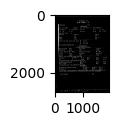

In [83]:

# testImage = ConvertToGrayScale(imread(".\\TestImages\\Screenshot 2023-05-15 130851.png"))
# imagePath = ".\\TestImages\\00000808.png"
# imagePath = ".\\TestImages\\00001188.png"
# imagePath = ".\\TestImages\\Chineese1.png"
# imagePath = ".\\TestImages\\CyrillicRecipie2.png"
# imagePath = ".\\TestImages\\russian1.png"
# imagePath = ".\\TestImages\\ukranian2.png"
# imagePath = ".\\TestImages\\bulgarian1.png"
# imagePath = ".\\TestImages\\english2.png"
# imagePath = "..\\TestImages\\indonesian1.png"
# imagePath = "..\\TestImages\\VaccinationCardEnglish.png"
imagePath = "..\\TestImages\\englishInsuranceform_lowRes.jpg"

PILImshow(imread(imagePath))
grayScaleImage = ConvertToGrayScale(imread(imagePath))
PILImshow(grayScaleImage)
binarizedImage = BinarizeImage(grayScaleImage, 0)
BinImshow(binarizedImage, 0)
BinPILImshow(binarizedImage, 0)


# 1894 x 1421 is a good image resolution but can't be used on small font sizes. If using 3028 x 4096 pixelimage, 
# the small font is picked up but the processing time is very large.




2688 1906
1/1 [==============================] - 0s 403ms/step


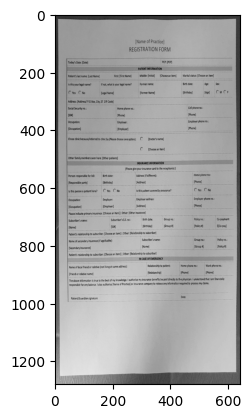

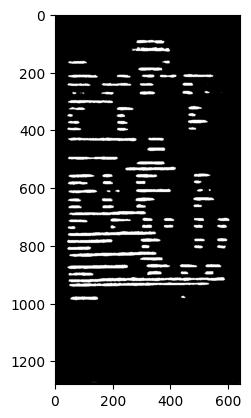

In [84]:
np.save('.\\BinarizeImage.npy', binarizedImage)
# testImage = np.load('.\\BinarizeImage.npy')

# testImageOriginal = testImage
# testImage = testImage * 1.0
originalHeight = grayScaleImage.shape[0]
originalWidth = grayScaleImage.shape[1]

print(originalHeight, originalWidth)

#Prepare testImage for model:
testImage = resize(grayScaleImage, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True)
testImage = testImage/255.0
testImage = testImage.reshape((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
predMask = model.predict(testImage)
predMask = (predMask >= 0.84).astype(int)

testImage = testImage.reshape((IMG_HEIGHT, IMG_WIDTH))
Imshow((testImage*255).astype(int))


predMask = predMask.reshape((IMG_HEIGHT, IMG_WIDTH))
BinImshow(predMask, 0)

predMask = resize(predMask, (originalHeight, originalWidth), mode='constant', preserve_range = True)
BinPILImshow(predMask, 0)

testImage = binarizedImage




# creating image object of
# above array
predMaskImage = Image.fromarray(predMask)
predMaskImage = predMaskImage.convert("L")
# saving the final output 
# as a PNG file
predMaskImage.save('predMaskImage.jpg')


# np.save('.\\BinarizeImage.npy', testImage)
# testImage = np.load('.\\BinarizeImage.npy')


# print("predMask.shape",predMask.shape)
# Imshow(testImage, predMask)


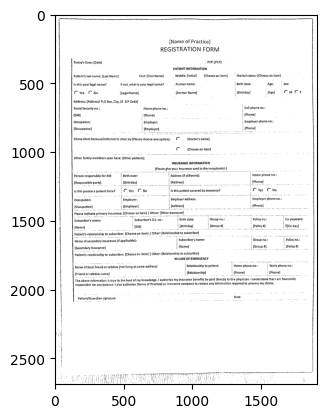

In [85]:
# imshow(testImage, cmap='gray')
BinImshow(testImage, 1)

Calculate average character height in the Image 

Calculate Connected Component algrotihm for original Image

totalLabels 5053


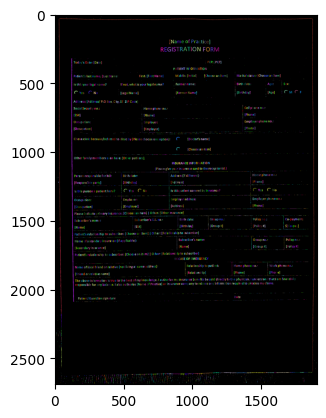

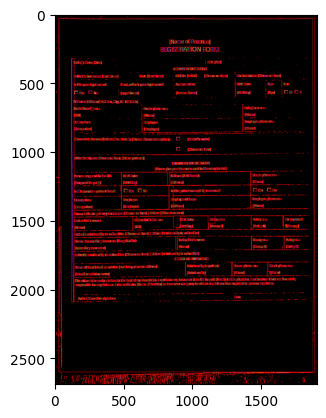

In [86]:
"""
Get Connected componenet label diagram for original image in order to calculate the 
Average Character Height.

This will be used to remove any bad textline segmentations.
"""
totalLabels, labels = ConnectedComponents(testImage.astype(int))

print("totalLabels", totalLabels)
# print("labels", labels)

colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
colors[0] =[0,0,0]

colored_components = colors[labels]

# PILImshow(colored_components, colored_components)
# imshow(colored_components)


TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries = getConnectedComponentBoundaries(totalLabels, labels)


Imshow(colored_components)

#Draw Circles on image where bounding boxes co-ordinates should be"
# https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
for i in range(0, len(TopBoundaries)):
    start_point = (LeftBoundaries[i], TopBoundaries[i])
    end_point = (RightBoundaries[i], BottomBoundaries[i])
    color = (255, 0, 0)
    thickness = 2
    image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)

Imshow(image)
PILImshow(colored_components)
# imshow(colored_components)




Plot histogram of heights for original image

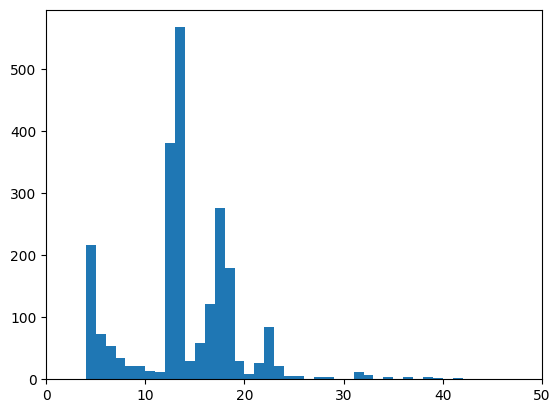

AverageCharacterHeight 13


In [87]:
# PILImshow(image, image)
#Obtain histogram of all the heights of the connected components
heights =  BottomBoundaries - TopBoundaries


#Remove CCs with 0 height:
deletingIndexArr = np.array([], dtype=np.uint)
for i in range(len(heights)):
    if heights[i] <= 3:
        deletingIndexArr = np.append(deletingIndexArr, i)

# print(deletingIndexArr)
TopBoundaries = np.delete(TopBoundaries, deletingIndexArr)
BottomBoundaries = np.delete(BottomBoundaries, deletingIndexArr)
LeftBoundaries = np.delete(LeftBoundaries, deletingIndexArr)
RightBoundaries = np.delete(RightBoundaries, deletingIndexArr)



heights =  BottomBoundaries - TopBoundaries


#specify bin width to use
w=1
plt.rcParams.update(plt.rcParamsDefault)
y, x, _ = plt.hist(heights, bins=np.arange(min(heights), max(heights) + w, w))
plt.xlim(0,50)
plt.show()

AverageCharacterHeight =  x[np.where(y == y.max())] #https://stackoverflow.com/questions/15558136/obtain-the-max-y-value-of-a-histogram
AverageCharacterHeight = int(AverageCharacterHeight[0])
print ("AverageCharacterHeight", AverageCharacterHeight)

Calculate Connected Components for Mask

totalLabels 102


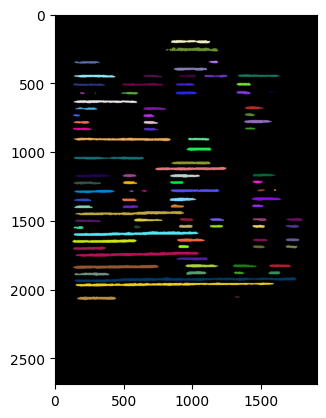

In [88]:
totalLabels, labels = ConnectedComponents(predMask.astype(int))

print("totalLabels", totalLabels)
# print("labels", labels)

colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
colors[0] =[0,0,0]

colored_components = colors[labels]

Imshow(colored_components)
PILImshow(colored_components)



Draw Textline boxes before average character height filtering:

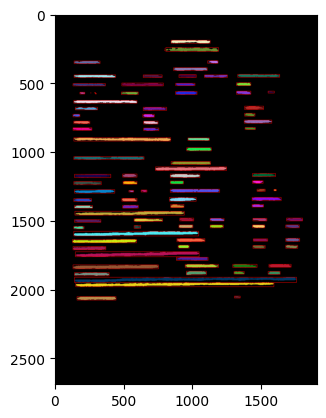

In [89]:
TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries = getConnectedComponentBoundaries(totalLabels, labels)

#Draw Circles on image where bounding boxes co-ordinates should be"
# https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
for i in range(0, len(TopBoundaries)):
    start_point = (LeftBoundaries[i], TopBoundaries[i])
    end_point = (RightBoundaries[i], BottomBoundaries[i])
    color = (255, 0, 0)
    thickness = 2
    image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)

Imshow(image)
PILImshow(image)

# After all of this the bounding boxes for the textlines have been located.

Draw Boxes after Average Character Height Filtering:

13


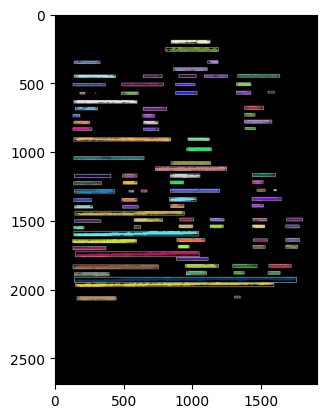

In [90]:
print(AverageCharacterHeight)
#Get rid of textline segmentations that are smaller then 0.2*AH and larger than 4*AH

heights =  BottomBoundaries - TopBoundaries

NewLeftBoundaries = np.array([])
NewRightBoundaries = np.array([])
NewTopBoundaries = np.array([])
NewBottomBoundaries = np.array([])

for i in range(0, len(heights)):
    if heights[i] > 5 and 0.4*AverageCharacterHeight < heights[i] < 4*AverageCharacterHeight:
        NewLeftBoundaries = np.append(NewLeftBoundaries, LeftBoundaries[i])
        NewRightBoundaries = np.append(NewRightBoundaries, RightBoundaries[i])
        NewTopBoundaries = np.append(NewTopBoundaries, TopBoundaries[i])
        NewBottomBoundaries = np.append(NewBottomBoundaries, BottomBoundaries[i])

TopBoundaries = NewTopBoundaries.astype(int)
BottomBoundaries = NewBottomBoundaries.astype(int)
LeftBoundaries = NewLeftBoundaries.astype(int)
RightBoundaries = NewRightBoundaries.astype(int)



# Draw Circles on image where bounding boxes co-ordinates should be"
# https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/

# testImage = np.ascontiguousarray(testImage, dtype=np.uint8)
for i in range(0, len(LeftBoundaries)):
    start_point = (LeftBoundaries[i], TopBoundaries[i])
    end_point = (RightBoundaries[i], BottomBoundaries[i])
    color = (255, 255, 255)
    thickness = 2
    image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)

Imshow(image)
PILImshow(image)

# After all of this the bounding boxes for the textlines have been located.

In [91]:
# #Binarize oiginal image to prepare for word segmentation:
# testImage = ConvertToGrayScale(imread(imagePath))
# BinarizedImage = BinarizeImage(testImage, 0)
# PILImshow(BinarizedImage, testImage)
# print(BinarizedImage.shape)
# BinPILImshow(BinarizedImage, 1)
BinarizedImage = testImage


In [92]:
def returnNumbersOnly(inputArr):
    NumberOnlyList = np.array([])
    for j in range(0, len(inputArr)):
        # print(i)
        if isinstance(inputArr[j], int) == True:
            NumberOnlyList = np.append(NumberOnlyList, inputArr[j])
    return NumberOnlyList

Calculate Word Segmentation Regions

In [93]:
""" 
Calculate the word Segmentation regions

Iterate through each textline bounding box individually and then for each bouding box, calculate the histogram
then segment the words within each bounding box and then append the co-ordinates into a new array called Words
"""

WordSegmentations = np.array([None, None, None, None]) #Top, Bottom, Left, Right. 
for i in range(0, len(TopBoundaries)): #Starting from 1 because the first connnected component is the background
    textlineSegment = BinarizedImage[TopBoundaries[i]:BottomBoundaries[i],LeftBoundaries[i]:RightBoundaries[i]]
    verticalHist = np.sum(textlineSegment,axis=0)

    # Calculate the distances of consecutive pixel widths for the foreground and background regions.
    verticalHist = verticalHist >= 1
    BackgroundList = np.array([], dtype=object)
    ForegroundList = np.array([], dtype=object)
    
    GapList = np.array([], dtype=object)
    if len(verticalHist) == 0:
        continue
    prev = verticalHist[0]
    if verticalHist[0] == 0:
        GapList = np.append(GapList, "B")
    else:
        GapList = np.append(GapList, "F")
    ConsecutiveCounter = 0
    for j in range(1,len(verticalHist)):
        current = verticalHist[j]
        if current == prev:
            ConsecutiveCounter += 1
        else:
            GapList = np.append(GapList, ConsecutiveCounter + 1)
            if prev == 0:
                GapList = np.append(GapList, "F")
            else:
                GapList = np.append(GapList, "B")

            ConsecutiveCounter = 0
        prev = current
    
    # GapList = ['F' 16 'B' 1 'F' 30 'B' 4]
    # WidthsList = [16, 1, 30, 4]
    # BackgroundList = [1, 4]

    # Need to fix last element to fix the issue : [B, 12, F, 20, B] --> [B, 12, F, 20, B, 10].
    WidthsList = returnNumbersOnly(GapList)
    GapList = np.append(GapList, int(len(verticalHist)-np.sum(WidthsList)))

    ## Find the largest background gap:
    # Obtain a BackgroundList variable:
    for j in range(0, len(GapList)):
        if GapList[j] == 'B':
            BackgroundList = np.append(BackgroundList, GapList[j+1])
    if len(BackgroundList) == 0:
        continue
    LargestSpaceEncountered = max(BackgroundList)
    # print(GapList)

    WordThreshold = LargestSpaceEncountered * 0.51
    SegmentFlagList = [None]*len(verticalHist) 
    SegmentFlagList = np.full(len(verticalHist), None)

    # If the gap is larger than the threshold then we should segment here and therefore insert a segmentation 
    # flag in the SegmentFlagList variable.
    for j in range(0, len(GapList)):
        # Check which background segments/widths are greater than the threshold:
        if isinstance(GapList[j], int) and GapList[j] >= WordThreshold and GapList[j-1] == 'B':
            WidthsList = GapList[:j] # -> ['F' 16 'B' 1 'F' 30 'B']
            WidthsList = returnNumbersOnly(WidthsList) # -> [16, 1, 30]
            NumOfIndexesBeforeFlag = int(np.sum(WidthsList)) #-> 47
            for k in range(0 , int(NumOfIndexesBeforeFlag)):
                if SegmentFlagList[k] == None: # ->[1,1,1,1,1,1*47]
                    SegmentFlagList[k] = 1
            SegmentFlagList[NumOfIndexesBeforeFlag : NumOfIndexesBeforeFlag + GapList[j]] = [0]*GapList[j] # ->[1,1,1,1,1,1,0,0,0,0]
    # Fill remaining 'None' values with 1:
    SegmentFlagList[SegmentFlagList == None] = 1
    
    ##Add word segments to the WordList array:
    prev = SegmentFlagList[0]
    segStart = 0
    segEnd = 0
    for j in range(1, len(SegmentFlagList)):
        current = SegmentFlagList[j]
        if (prev == 0 and current == 1):
            segStart = j
        elif (prev == 1 and current == 0) or (current == 1 and j == len(SegmentFlagList)-1):
            segEnd = j
            WordSegmentCoordinates = np.array([TopBoundaries[i], BottomBoundaries[i], LeftBoundaries[i] + segStart, LeftBoundaries[i] + segEnd])
            # WordSegmentCoordinates = np.array([TopBoundaries[i], BottomBoundaries[i], segStart, segEnd])
            WordSegmentations = np.vstack((WordSegmentations, WordSegmentCoordinates))
        prev = current
        
    

    # #Plotting the Histograms.
    # print(i)
    # plotLengthX = 10

    # plt.subplot(3,1,1)
    # plt.imshow(textlineSegment, cmap='gray', vmin=0, vmax=1, aspect='auto')
    # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    # plt.subplot(3,1,2)
    # x = np.arange(0, len(verticalHist))
    # y = verticalHist
    # plt.rcParams['figure.figsize'] = [plotLengthX, 1]
    # plt.bar(x,y, width=1.0)
    # plt.margins(0, 0)

    # plt.subplot(3,1,3)
    # x = np.arange(0, len(verticalHist))
    # y = (SegmentFlagList)
    # plt.rcParams['figure.figsize'] = [plotLengthX, 1]
    # plt.bar(x,y, width=1.0, color='red')
    # plt.margins(0, 0)
    # plt.show()

WordSegmentations = WordSegmentations[1:] #To get rid of the [None, None None, None] at the beginning of the array.


Draw the bounding boxes for word segmentations:

(2688, 1906)
(2688, 1906)


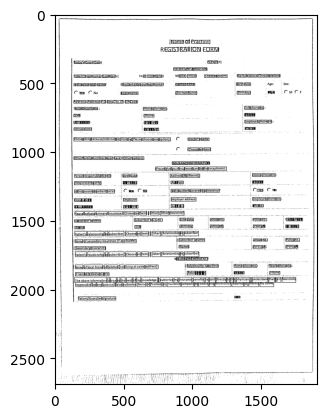

In [94]:
"""
Draw the bounding boxes for word segmentations:
"""

image = None
testImage = imread(imagePath)
testImage = np.logical_not(BinarizedImage) * 255

print(testImage.shape)
# testImage = testImage[:, :, :3]
print(testImage.shape)
testImage = np.ascontiguousarray(testImage, dtype=np.uint8)

for i in range(0, len(WordSegmentations)):
    start_point = (WordSegmentations[i][2], WordSegmentations[i][0])
    end_point = (WordSegmentations[i][3], WordSegmentations[i][1])
    color = (0, 0, 0)
    thickness = 2
    image = cv2.rectangle(testImage, start_point, end_point, color, thickness)


Imshow(image)
PILImshow(image)

Draw Bounding boxes for characters in each word segment:

In [64]:
"""
Display each cropped word segment:
Perfrom Connceted component analysis for characters in each word segment:
""" 

CharacterLocationDictionary = {}

# Convert WordSegmentations (n, 4) array in to (n, 5) array to hold UniqueWordID in
# first column
print(WordSegmentations.shape)
WordSegmentID = np.arange(0,len(WordSegmentations)) #Assign each word segment in WordSegmentations a unique label.
#to act as a key in the dictionary.
WordSegmentID = np.reshape(WordSegmentID, (len(WordSegmentations), 1))
# print(WordSegmentID)
WordSegmentationsWithID = np.append(WordSegmentID, WordSegmentations, axis = 1)


for i in range(0, len(WordSegmentationsWithID)):

    wordID = WordSegmentationsWithID[i][0]
    # print("wordID", wordID)
    
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    
    totalLabels, labels = ConnectedComponents(WordSegment.astype(int))
    # print("totalLabels", totalLabels)
    colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
    colors[0] =[0,0,0]
    colored_components = colors[labels]

    TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries = getConnectedComponentBoundaries(totalLabels, labels)
    
    # # # Draw bounding boxes for characters:
    # #Draw Circles on image where bounding boxes co-ordinates should be"
    # # https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
    # for j in range(0, len(TopBoundaries)):
    #     start_point = (LeftBoundaries[j], TopBoundaries[j])
    #     end_point = (RightBoundaries[j], BottomBoundaries[j])
    #     color = (255, 0, 0)
    #     thickness = 1
    #     image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)


    # convert TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries into 
    # a single 2d array.:
    TwoDimArray = np.zeros((len(TopBoundaries),4), dtype=int)
    # print("shape", (np.reshape(TopBoundaries, (len(TopBoundaries),1)).shape))
    # print("TwoDimArray shape", TwoDimArray.shape)
    TwoDimArray[:, 0] =  TopBoundaries
    TwoDimArray[:, 1] =  BottomBoundaries
    TwoDimArray[:, 2] =  LeftBoundaries
    TwoDimArray[:, 3] =  RightBoundaries
    # print(TwoDimArray)

    CharacterLocationDictionary[wordID] = TwoDimArray


    # print("wordID", wordID)
    # plotLengthX = 7

    # plt.subplot(2,1,1)
    # plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
    # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    # plt.subplot(2,1,2)
    # plt.imshow(image, aspect='auto', interpolation='none')
    # plt.rcParams['figure.figsize'] = [plotLengthX, 1]
    # plt.show()


#To-do List:
# 1)Segment joined characters by checking average width of connected components and segment 
# if width of joined component box is greater than threshold.
# 
# 2) join the dots of 'i's 
# 3) Remove/ identify if puctuation is present in word. - possibly by ignoring CCs smaller 
# than a certain width or height.


for i in WordSegmentationsWithID:
    wordID = i[0]
    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    TopBoundaries = CharacterCoordinatesArray[:, 0]

    if len(TopBoundaries) == 0:
        print(wordID)


# print(CharacterLocationDictionary)

startIndex = 20
endIndex = 30

(416, 4)


In [65]:
# Check for the dots of 'i's and check for colons and commas:
# Check for floating strokes or dots above characters and join them to main bottom character.

#First find the average height and width of all CC Characters in the original word segment.
for i in range(0, len(WordSegmentationsWithID)):
# for i in range(171, 174):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    print(wordID)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    # print("CharacterCoordinatesArray", CharacterCoordinatesArray)
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]

    AvgHeight = (sumOfArray(BottomBoundaries - TopBoundaries))/len(TopBoundaries)
    AvgWidth = (sumOfArray(RightBoundaries - LeftBoundaries))/len(TopBoundaries)
    print("AvgHeight", AvgHeight)
    print("AvgWidth", AvgWidth)

    totalLabels, labels = ConnectedComponents(WordSegment.astype(int))
    # print("totalLabels", totalLabels)
    colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
    colors[0] =[0,0,0]
    colored_components = colors[labels]

    deletingIndexList = np.array([], dtype = int)

    for j in range(0, len(CharacterCoordinatesArray)):
        start_point = (LeftBoundaries[j], TopBoundaries[j])
        end_point = (RightBoundaries[j], BottomBoundaries[j])

        CCHeight = BottomBoundaries[j] - TopBoundaries[j]
        CCWidth = RightBoundaries[j] - LeftBoundaries[j]

        # If the dot or stroke above a character's height is less than 0.3*AvgHeight
        # then group it to the connected component below it.
        # print("CCHeight", CCHeight) 
        # print("0.50*AvgHeight", 0.50*AvgHeight)
        if (CCHeight <= 0.6*AvgHeight): 
            #Check if there is bigger CC below the small CC:
            # therefore find horizontal midpoint of small CC:
            CCMidpoint = (CCWidth//2) + LeftBoundaries[j]
            print("CCMidpoint", CCMidpoint)
            #Find the other CCs that is directly below the smaller CC
            for k in range(0, len(CharacterCoordinatesArray)):
                print("LeftBoundaries[k]", LeftBoundaries[k])
                print("RightBoundaries[k]", RightBoundaries[k])
                if LeftBoundaries[k] <= CCMidpoint <= RightBoundaries[k] and not(LeftBoundaries[k] == LeftBoundaries[j] and RightBoundaries[k] == RightBoundaries[j] and TopBoundaries[k] == TopBoundaries[j] and BottomBoundaries[k] == BottomBoundaries[j]):
                    print("A CC found under CCMidpoint")
                    #Combine the 2 CCs by using the max boundaries of the CCs:
                    LeftBoundaries[k] = min(LeftBoundaries[k], LeftBoundaries[j])
                    RightBoundaries[k] = max(RightBoundaries[k], RightBoundaries[j])
                    TopBoundaries[k] = min(TopBoundaries[k], TopBoundaries[j])
                    BottomBoundaries[k] = max(BottomBoundaries[k], BottomBoundaries[j])

            # delete the smaller CC from the CharacterCoordinatesArray
            deletingIndexList = np.append(deletingIndexList, j)

# -----------------------------------------------------------------------------------
            # start_point = (LeftBoundaries[j], TopBoundaries[j])
            # end_point = (RightBoundaries[j], BottomBoundaries[j])
            # color = (0, 255, 0)
            # thickness = 1
            # image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)
        
            # # #Plotting the Histograms.
            # plotLengthX = 7

            # plt.subplot(2,1,1)
            # plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
            # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

            # plt.subplot(2,1,2)
            # plt.imshow(image, aspect='auto', interpolation='none')
            # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

            # plt.show()

    # Delete the smaller CC from the CharacterCoordinatesArray
    # for i in deletingIndexList:
    
    LeftBoundaries = np.delete(LeftBoundaries, deletingIndexList)
    RightBoundaries = np.delete(RightBoundaries, deletingIndexList)
    TopBoundaries = np.delete(TopBoundaries, deletingIndexList)
    BottomBoundaries = np.delete(BottomBoundaries, deletingIndexList)

    # convert TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries into 
    # a single 2d array.:
    TwoDimArray = np.zeros((len(TopBoundaries),4), dtype=int)
    # print("shape", (np.reshape(TopBoundaries, (len(TopBoundaries),1)).shape))
    # print("TwoDimArray shape", TwoDimArray.shape)
    TwoDimArray[:, 0] =  TopBoundaries
    TwoDimArray[:, 1] =  BottomBoundaries
    TwoDimArray[:, 2] =  LeftBoundaries
    TwoDimArray[:, 3] =  RightBoundaries

    CharacterLocationDictionary[wordID] = TwoDimArray


    # CharacterLocationDictionary[wordID] = CharacterCoordinatesArray

    
for i in WordSegmentationsWithID:
    wordID = i[0]
    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    TopBoundaries = CharacterCoordinatesArray[:, 0]

    if len(TopBoundaries) == 0:
        print(wordID)


    

0
AvgHeight 20.0
AvgWidth 19.25
1
AvgHeight 20.0
AvgWidth 13.5
2
AvgHeight 18.4
AvgWidth 10.7
CCMidpoint 86
LeftBoundaries[k] 0
RightBoundaries[k] 16
LeftBoundaries[k] 70
RightBoundaries[k] 80
LeftBoundaries[k] 84
RightBoundaries[k] 88
LeftBoundaries[k] 131
RightBoundaries[k] 134
LeftBoundaries[k] 35
RightBoundaries[k] 50
LeftBoundaries[k] 21
RightBoundaries[k] 32
LeftBoundaries[k] 54
RightBoundaries[k] 67
LeftBoundaries[k] 84
RightBoundaries[k] 88
A CC found under CCMidpoint
LeftBoundaries[k] 92
RightBoundaries[k] 106
LeftBoundaries[k] 108
RightBoundaries[k] 125
3
AvgHeight 15.75
AvgWidth 10.25
CCMidpoint 4
LeftBoundaries[k] 0
RightBoundaries[k] 8
LeftBoundaries[k] 12
RightBoundaries[k] 37
LeftBoundaries[k] 45
RightBoundaries[k] 49
LeftBoundaries[k] 54
RightBoundaries[k] 74
LeftBoundaries[k] 77
RightBoundaries[k] 83
LeftBoundaries[k] 85
RightBoundaries[k] 90
LeftBoundaries[k] 0
RightBoundaries[k] 6
A CC found under CCMidpoint
LeftBoundaries[k] 0
RightBoundaries[k] 8
A CC found under C

In [66]:
deletingIndexList = np.array([])
print(WordSegmentationsWithID.shape)
for i in WordSegmentationsWithID:
    wordID = i[0]
    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    TopBoundaries = CharacterCoordinatesArray[:, 0]

    if len(TopBoundaries) == 0:
        deletingIndexList = np.append(deletingIndexList, wordID)
        print(wordID)

print(deletingIndexList)

for wordID in deletingIndexList:
    wordIDs = WordSegmentationsWithID[:, 0]
    index = np.where(wordIDs == wordID)[0][0]
    WordSegmentationsWithID = np.delete(WordSegmentationsWithID, index, axis = 0)

    CharacterLocationDictionary.pop(wordID, None)

(416, 5)
[]


416
20
wordID 20
image.shape (19, 43, 3)
type(image) <class 'numpy.ndarray'>


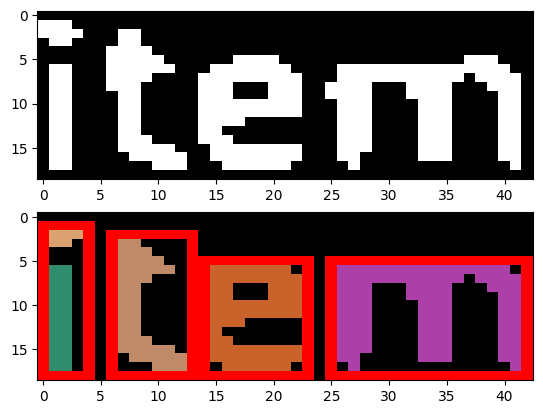

21
wordID 21
image.shape (19, 84, 3)
type(image) <class 'numpy.ndarray'>


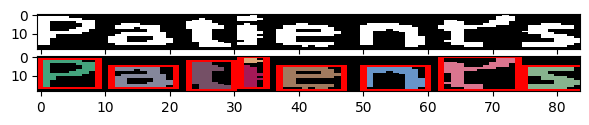

22
wordID 22
image.shape (19, 34, 3)
type(image) <class 'numpy.ndarray'>


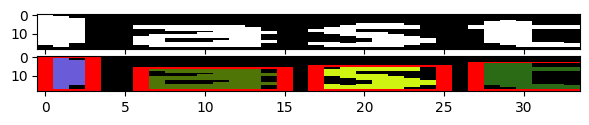

23
wordID 23
image.shape (19, 62, 3)
type(image) <class 'numpy.ndarray'>


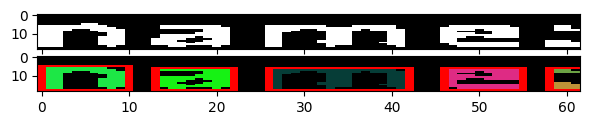

24
wordID 24
image.shape (19, 47, 3)
type(image) <class 'numpy.ndarray'>


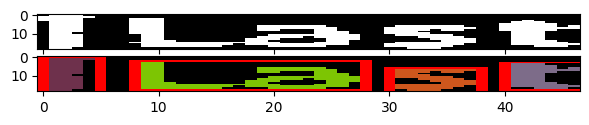

25
wordID 25
image.shape (19, 43, 3)
type(image) <class 'numpy.ndarray'>


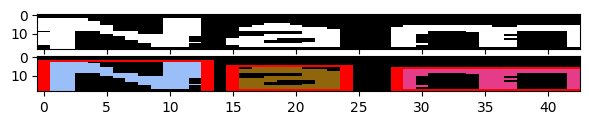

26
wordID 26
image.shape (19, 18, 3)
type(image) <class 'numpy.ndarray'>


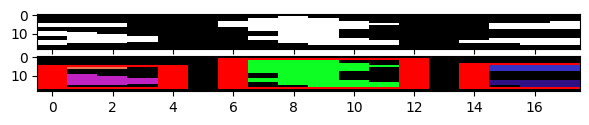

27
wordID 27
image.shape (19, 49, 3)
type(image) <class 'numpy.ndarray'>


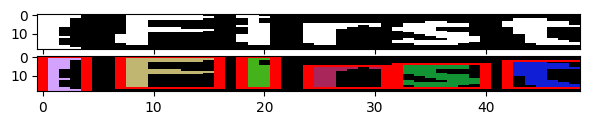

28
wordID 28
image.shape (19, 53, 3)
type(image) <class 'numpy.ndarray'>


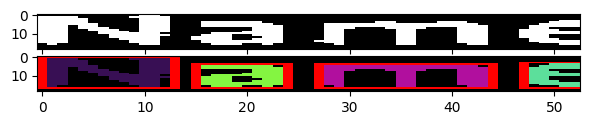

29
wordID 29
image.shape (19, 51, 3)
type(image) <class 'numpy.ndarray'>


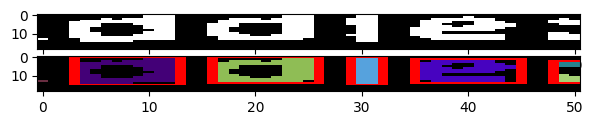

In [67]:
# WordSegmentationsWithID contains WordSegmentation boxes with corresponding word ID
# CharacterLocationDictionary contains Character Locations for each corresponding word ID.

image = None
print(len(CharacterLocationDictionary))

# for i in range(0, len(WordSegmentationsWithID)):
for i in range(startIndex, endIndex):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    print(wordID)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    # print("CharacterCoordinatesArray", CharacterCoordinatesArray)
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]


    totalLabels, labels = ConnectedComponents(WordSegment.astype(int))
    # print("totalLabels", totalLabels)
    colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
    colors[0] =[0,0,0]
    colored_components = colors[labels]

    #Draw Circles on image where bounding boxes co-ordinates should be"
    # https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
    for j in range(0, len(TopBoundaries)):
        start_point = (LeftBoundaries[j], TopBoundaries[j])
        end_point = (RightBoundaries[j], BottomBoundaries[j])
        color = (255, 0, 0)
        thickness = 1
        image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)

    
    # for i in range(0, len(CharacterCoordinatesArray)):


    # #Plotting the Histograms.
    print("wordID", wordID)
    plotLengthX = 7

    plt.subplot(2,1,1)
    plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
    plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    plt.subplot(2,1,2)
    print("image.shape", image.shape)
    print("type(image)", type(image))
    plt.imshow(image, aspect='auto', interpolation='none')
    plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    # image = "None"

    plt.show()

In [68]:
# Check for remaining colons and commas:
# Check for floating strokes or dots above characters and join them to main bottom character.

#First find the average height and width of all CC Characters in the original word segment.
for i in range(0, len(WordSegmentationsWithID)):
# for i in range(50, 100):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    print(wordID)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    # print("CharacterCoordinatesArray", CharacterCoordinatesArray)
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]

    AvgHeight = (sumOfArray(BottomBoundaries - TopBoundaries))/len(TopBoundaries)
    AvgWidth = (sumOfArray(RightBoundaries - LeftBoundaries))/len(TopBoundaries)
    print("AvgHeight", AvgHeight)
    print("AvgWidth", AvgWidth)

    totalLabels, labels = ConnectedComponents(WordSegment.astype(int))
    # print("totalLabels", totalLabels)
    colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
    colors[0] =[0,0,0]
    colored_components = colors[labels]

    deletingIndexList = np.array([], dtype = int)

    for j in range(0, len(CharacterCoordinatesArray)):
        start_point = (LeftBoundaries[j], TopBoundaries[j])
        end_point = (RightBoundaries[j], BottomBoundaries[j])

        CCHeight = BottomBoundaries[j] - TopBoundaries[j]
        CCWidth = RightBoundaries[j] - LeftBoundaries[j]

        # If the dot or stroke above character's height is less than 0.3*AvgHeight
        # then group it to the connected component below it.
        if (CCHeight < 0.6*AvgHeight): 

            print("Found CC less than 0.45*AvgHeight")
            
            # delete the smaller CC from the CharacterCoordinatesArray
            deletingIndexList = np.append(deletingIndexList, j)

            # start_point = (LeftBoundaries[j], TopBoundaries[j])
            # end_point = (RightBoundaries[j], BottomBoundaries[j])
            # color = (0, 255, 0)
            # thickness = 1
            # image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)
        
            # # #Plotting the Histograms.
            # plotLengthX = 7

            # plt.subplot(2,1,1)
            # plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
            # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

            # plt.subplot(2,1,2)
            # plt.imshow(image, aspect='auto', interpolation='none')
            # plt.rcParams['figure.figsize'] = [plotLengthX, 1]

            # plt.show()

    # Delete the smaller CC from the CharacterCoordinatesArray
    # for i in deletingIndexList:
    
    LeftBoundaries = np.delete(LeftBoundaries, deletingIndexList)
    RightBoundaries = np.delete(RightBoundaries, deletingIndexList)
    TopBoundaries = np.delete(TopBoundaries, deletingIndexList)
    BottomBoundaries = np.delete(BottomBoundaries, deletingIndexList)

    # convert TopBoundaries, BottomBoundaries, LeftBoundaries, RightBoundaries into 
    # a single 2d array.:
    TwoDimArray = np.zeros((len(TopBoundaries),4), dtype=int)
    # print("shape", (np.reshape(TopBoundaries, (len(TopBoundaries),1)).shape))
    # print("TwoDimArray shape", TwoDimArray.shape)
    TwoDimArray[:, 0] =  TopBoundaries
    TwoDimArray[:, 1] =  BottomBoundaries
    TwoDimArray[:, 2] =  LeftBoundaries
    TwoDimArray[:, 3] =  RightBoundaries

    CharacterLocationDictionary[wordID] = TwoDimArray


    # CharacterLocationDictionary[wordID] = CharacterCoordinatesArray

    


    

0
AvgHeight 20.0
AvgWidth 19.25
1
AvgHeight 20.0
AvgWidth 13.5
2
AvgHeight 20.77777777777778
AvgWidth 11.444444444444445
3
AvgHeight 26.666666666666668
AvgWidth 11.666666666666666
4
AvgHeight 28.0
AvgWidth 23.0
5
AvgHeight 27.0
AvgWidth 5.0
6
AvgHeight 27.666666666666668
AvgWidth 19.0
7
AvgHeight 29.0
AvgWidth 22.25
8
AvgHeight 13.666666666666666
AvgWidth 8.666666666666666
9
AvgHeight 15.0
AvgWidth 6.666666666666667
10
AvgHeight 14.833333333333334
AvgWidth 11.0
11
AvgHeight 13.4
AvgWidth 8.6
12
AvgHeight 14.4
AvgWidth 7.0
13
AvgHeight 16.666666666666668
AvgWidth 12.5
14
AvgHeight 16.0
AvgWidth 10.25
15
AvgHeight 16.5
AvgWidth 15.166666666666666
16
AvgHeight 14.714285714285714
AvgWidth 6.714285714285714
17
AvgHeight 13.571428571428571
AvgWidth 7.571428571428571
18
AvgHeight 14.857142857142858
AvgWidth 9.571428571428571
19
AvgHeight 12.5
AvgWidth 10.0
20
AvgHeight 14.75
AvgWidth 9.25
21
AvgHeight 14.75
AvgWidth 8.875
22
AvgHeight 14.5
AvgWidth 6.75
23
AvgHeight 12.2
AvgWidth 9.6
24
AvgHe

In [69]:
deletingIndexList = np.array([])
print(WordSegmentationsWithID.shape)
for i in WordSegmentationsWithID:
    wordID = i[0]
    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    TopBoundaries = CharacterCoordinatesArray[:, 0]

    if len(TopBoundaries) == 0:
        deletingIndexList = np.append(deletingIndexList, wordID)
        print(wordID)

print(deletingIndexList)

for wordID in deletingIndexList:
    wordIDs = WordSegmentationsWithID[:, 0]
    index = np.where(wordIDs == wordID)[0][0]
    WordSegmentationsWithID = np.delete(WordSegmentationsWithID, index, axis = 0)

    CharacterLocationDictionary.pop(wordID, None)

for i in WordSegmentationsWithID:
    wordID = i[0]
    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    TopBoundaries = CharacterCoordinatesArray[:, 0]

    # for j in range(0, len(TopBoundaries)):

    #     croppedCharacter = WordSegment[TopBoundaries[j]:BottomBoundaries[j], LeftBoundaries[j]:RightBoundaries[j]] 

    #     height = croppedCharacter.shape[0]
    #     width = croppedCharacter.shape[1]


    #     if height == 0 or width == 0:
    #         print("0 detected")



(416, 5)
[]


416
20
CharacterCoordinatesArray [[ 2 18  6 13]
 [ 5 18 14 23]
 [ 5 18 25 42]
 [ 1 18  0  4]]
wordID 20


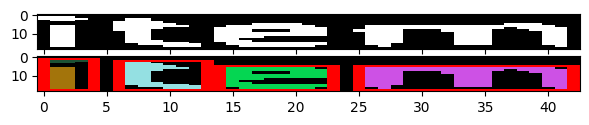

21
CharacterCoordinatesArray [[ 0 18 62 74]
 [ 1 17  0  9]
 [ 2 18 23 30]
 [ 5 17 11 21]
 [ 0 17 31 35]
 [ 5 18 37 47]
 [ 5 18 50 60]
 [ 5 18 75 84]]
wordID 21


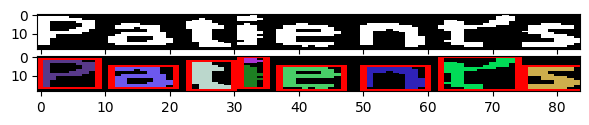

22
CharacterCoordinatesArray [[ 0 18  0  3]
 [ 3 18 27 34]
 [ 5 18 17 25]
 [ 6 18  6 15]]
wordID 22


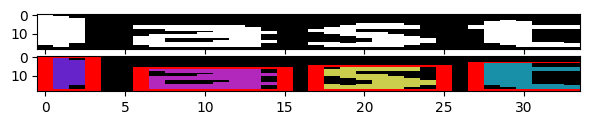

23
CharacterCoordinatesArray [[ 5 18  0 10]
 [ 6 18 13 22]
 [ 6 18 26 42]
 [ 6 18 46 55]
 [ 6 18 58 62]]
wordID 23


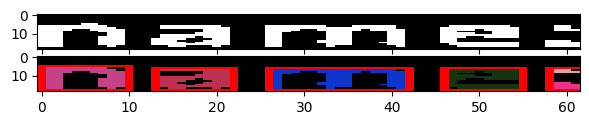

24
CharacterCoordinatesArray [[ 0 19  0  5]
 [ 2 18  8 28]
 [ 3 18 40 47]
 [ 6 19 30 38]]
wordID 24


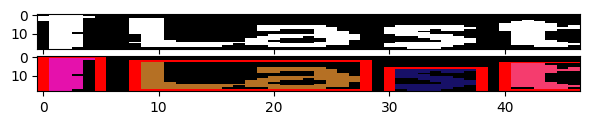

25
CharacterCoordinatesArray [[ 2 19  0 13]
 [ 5 18 15 24]
 [ 6 18 28 43]]
wordID 25


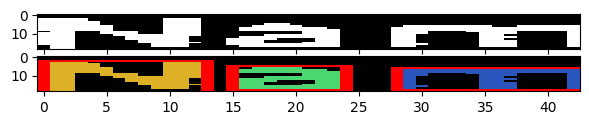

26
CharacterCoordinatesArray [[ 1 17  6 12]
 [ 5 17  0  4]
 [ 4 17 14 18]]
wordID 26


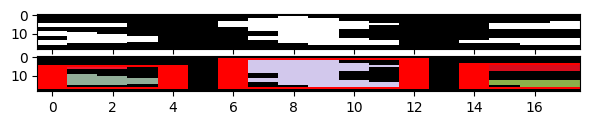

27
CharacterCoordinatesArray [[ 0 19  0  4]
 [ 0 17  7 16]
 [ 0 17 18 21]
 [ 2 17 42 49]
 [ 4 17 32 40]
 [ 5 17 24 31]]
wordID 27


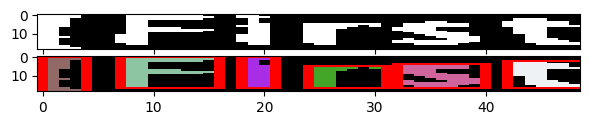

28
CharacterCoordinatesArray [[ 0 17  0 13]
 [ 3 17 47 53]
 [ 4 17 15 24]
 [ 4 17 27 44]]
wordID 28


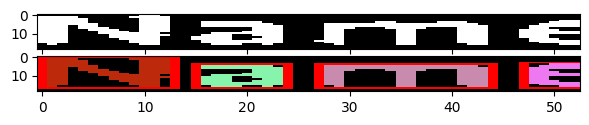

29
CharacterCoordinatesArray [[ 0 15  3 13]
 [ 0 14 16 26]
 [ 0 15 29 32]
 [ 1 14 35 45]
 [ 2 14 48 51]]
wordID 29


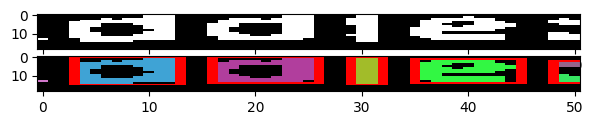

In [70]:
# WordSegmentationsWithID contains WordSegmentation boxes with corresponding word ID
# CharacterLocationDictionary contains Character Locations for each corresponding word ID.

image = None
print(len(CharacterLocationDictionary))

# for i in range(0, len(WordSegmentationsWithID)):
for i in range(startIndex, endIndex):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    print(wordID)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    print("CharacterCoordinatesArray", CharacterCoordinatesArray)
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]


    totalLabels, labels = ConnectedComponents(WordSegment.astype(int))
    # print("totalLabels", totalLabels)
    colors = np.random.randint(0, 255, size =(totalLabels, 3), dtype=np.uint8)
    colors[0] =[0,0,0]
    colored_components = colors[labels]

    #Draw Circles on image where bounding boxes co-ordinates should be"
    # https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
    for j in range(0, len(TopBoundaries)):
        start_point = (LeftBoundaries[j], TopBoundaries[j])
        end_point = (RightBoundaries[j], BottomBoundaries[j])
        color = (255, 0, 0)
        thickness = 1
        image = cv2.rectangle(colored_components, start_point, end_point, color, thickness)

    
    # for i in range(0, len(CharacterCoordinatesArray)):


    # #Plotting the Histograms.
    print("wordID", wordID)
    plotLengthX = 7

    plt.subplot(2,1,1)
    plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
    plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    plt.subplot(2,1,2)
    plt.imshow(image, aspect='auto', interpolation='none')
    plt.rcParams['figure.figsize'] = [plotLengthX, 1]

    image = "None"

    plt.show()

Sort the order of the Characters within word segment

In [71]:
#Sort the order of the Characters within word segment from left to right;
for i in range(0, len(WordSegmentationsWithID)):
    wordID = WordSegmentationsWithID[i][0]
    CharacterLocationDictionary[wordID] = CharacterLocationDictionary[wordID][CharacterLocationDictionary[wordID][:,2].argsort()]

Script Detection

Prepare inidvidual character blocks for inputting into Script Classifier ANN:

In [72]:
# model = tf.keras.models.load_model('G:\\My Drive\\EPR_420\\Code\\Omniprint_ANN_Classifier_Latin\\LatinANN_Tensorflow6.h5')


In [73]:
model = tf.keras.models.load_model(r'.\\models\\LatinCyrillicGreek_Tensorflow4.h5')

# Files containing the validation characters to identify the script:
fileGreek = open(r"..\Omniprint_ANN_Classifier_LatinCyrillicGreek_Collab\GreekCharactersCandidates.txt", "r", encoding='utf-8') 
fileCyrillic = open(r"..\Omniprint_ANN_Classifier_LatinCyrillicGreek_Collab\CyrillicCharactersCandidates.txt", "r", encoding='utf-8')
fileLatin = open(r"..\Omniprint_ANN_Classifier_LatinCyrillicGreek_Collab\LatinCharactersCandidates.txt", "r", encoding='utf-8')

GreekSet = fileGreek.read().splitlines()
CyrillicSet = fileCyrillic.read().splitlines()
LatinSet = fileLatin.read().splitlines()

LatinCounter = 0
CyrillicCounter = 0 
GreekCounter = 0

file = open(r"G:\My Drive\EPR_420\Code\Omniprint_ANN_Classifier_LatinCyrillicGreek_Collab\LatinGreekCyrillic.txt", "r", encoding='utf-8')
alphabetSet = file.read().splitlines()


for i in range(0, len(WordSegmentationsWithID)):
# for i in range(startIndex, endIndex):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    # print("wordID", wordID)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    # print(CharacterCoordinatesArray)
    
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]

    stringHolder = ""

    # Print out individual cropped out characters: 
    for j in range(0, len(TopBoundaries)):
        croppedCharacter = WordSegment[TopBoundaries[j]:BottomBoundaries[j], LeftBoundaries[j]:RightBoundaries[j]] 

        # Find the longest dimension of cropped out character:
        # Note .shape returns (height, width)     
        maxDim = croppedCharacter.shape.index(max(croppedCharacter.shape))
        # print("shape", croppedCharacter.shape)

        height = croppedCharacter.shape[0]
        width = croppedCharacter.shape[1]
        # skip any images with a width of 0.
        # if (width == 0):
        #     continue
        aspectRatio = height/width
        # print("aspectRatio", aspectRatio)

        if (maxDim): #AKA if width is longer than height
            # print("width longer than height")
            margin = 4
            croppedCharacter = resize(croppedCharacter, (aspectRatio*28, 28-margin), order = 0, mode='constant', preserve_range = True)
            height = croppedCharacter.shape[0]
            width = croppedCharacter.shape[1]
            #Now pad black pixels on top and bottom sides:
            topPadding = np.zeros((((28-height)//2), 28-margin))
            bottomPadding = np.zeros((28-height-((28-height)//2), 28-margin))
            croppedCharacter = np.vstack((topPadding, croppedCharacter, bottomPadding))
            rightPad = np.zeros((28, margin//2))
            leftPad = np.zeros((28, margin//2))
            croppedCharacter = np.hstack((leftPad, croppedCharacter, rightPad))

        
        else: #AKA if height is longer than width
            # print("height longer than width")
            margin = 2
            croppedCharacter = resize(croppedCharacter, (28-margin, 28*(1/aspectRatio)), order = 0, mode='constant', preserve_range = True)
            height = croppedCharacter.shape[0]
            width = croppedCharacter.shape[1]
            #Now pad black pixels on left and right sides:
            rightPad = np.zeros((28-margin,(28-width)//2))
            leftPad = np.zeros((28-margin, 28-width-((28-width)//2)))
            croppedCharacter = np.hstack((leftPad, croppedCharacter, rightPad))
            topPadding = np.zeros((margin//2, 28))
            bottomPadding = np.zeros((margin//2, 28))
            croppedCharacter = np.vstack((topPadding, croppedCharacter, bottomPadding))


        y_pred = model.predict(croppedCharacter.reshape(1, 28, 28), verbose=0)

        # plt.rcParams['figure.figsize'] = [1, 1]
        # plt.imshow(croppedCharacter, cmap = 'gray', interpolation='none')
        # # print(croppedCharacter.shape) 
        # plt.show() 
        # print(alphabetSet[y_pred.argmax()])
        # #https://stackoverflow.com/questions/27219774/read-special-characters-from-txt-file-in-python

        stringHolder += alphabetSet[y_pred.argmax()]
        LatinCounter += int(alphabetSet[y_pred.argmax()] in LatinSet)
        CyrillicCounter += int(alphabetSet[y_pred.argmax()] in CyrillicSet)
        GreekCounter += int(alphabetSet[y_pred.argmax()] in GreekSet)




fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1) 
plt.cla()
plt.rcParams['figure.figsize'] = [4, 4]
bars  = plt.bar(["Latin", "Cyrillic", "Greek"], [LatinCounter, CyrillicCounter, GreekCounter], color ='maroon',
    width = 0.4)

display(fig)    
# clear_output(wait = True)


# print(LatinCounter)
# print(CyrillicCounter)
# print(GreekCounter)



KeyboardInterrupt: 

In [ ]:
#Load the OCR model, alphabet set, and language dictionaries for the detected script:

if max([LatinCounter, CyrillicCounter, GreekCounter]) == LatinCounter:
    print("Latin Script detected")
    model = tf.keras.models.load_model(r'..\Omniprint_ANN_Classifier_Latin\LatinANN_Tensorflow6.h5')

    file = open(r"..\Omniprint_ANN_Classifier_Latin\basic_latin_lowercase.txt", "r", encoding='utf-8')
    alphabetSet = file.read().splitlines()
    print(alphabetSet)

    with open('.\dictionaries\english_words_dictionary.json') as json_file:
        engDictionary = json.load(json_file)

    with open('.\dictionaries\indonesian_words_dictionary.json') as json_file:
        indoDictionary = json.load(json_file)

    with open('.\dictionaries\dutch_words_dictionary.json') as json_file:
        dutchDictionary = json.load(json_file)

    with open('.\dictionaries\spanish_words_dictionary.json') as json_file:
        spanishDictionary = json.load(json_file)


    

    AvailableDictionariesNames = ['engDictionary', 'indoDictionary', 'dutchDictionary', 'spanishDictionary']
    AvailableDictionaries = [engDictionary, indoDictionary, dutchDictionary, spanishDictionary]
    print("AvailableDictionaries: ", AvailableDictionariesNames)



elif max([LatinCounter, CyrillicCounter, GreekCounter]) == CyrillicCounter:
    print("Cyrillic Script detected")
    model = tf.keras.models.load_model(r'..\Omniprint_ANN_Classifier_Cyrillic\CyrillicANN_Tensorflow2.h5')

    file = open(r"..\Omniprint_ANN_Classifier_Cyrillic\TrainingCharacters\combinedCyrillic.txt", "r", encoding='utf-8')
    alphabetSet = file.read().splitlines()
    print(alphabetSet)

    with open(r'.\dictionaries\bulgarian_words_dictionary.json') as json_file:
        bulDictionary = json.load(json_file)
    
    with open(r'.\dictionaries\belarusian_words_dictionary.json') as json_file:
        belDictionary = json.load(json_file)

    with open(r'.\dictionaries\ukranian_words_dictionary.json') as json_file:
        ukrainianDictionary = json.load(json_file)

    with open(r'.\dictionaries\russian_words_dictionary.json') as json_file:
        russianDictionary = json.load(json_file)


        
    AvailableDictionariesNames = ['bulDictionary', 'belDictionary', 'ukrainianDictionary', 'russianDictionary']
    AvailableDictionaries = [bulDictionary, belDictionary, ukrainianDictionary, russianDictionary]
    print("AvailableDictionaries: ", AvailableDictionariesNames)

elif max([LatinCounter, CyrillicCounter, GreekCounter]) == GreekCounter:
    print("Greek Script detected")

Latin Script detected
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
AvailableDictionaries:  ['engDictionary', 'indoDictionary', 'dutchDictionary', 'spanishDictionary']


In [ ]:
fig = plt.figure()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

wordID 0
i 0


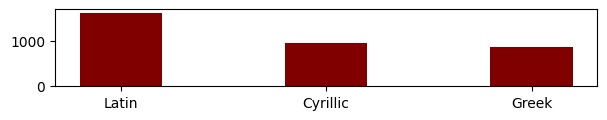

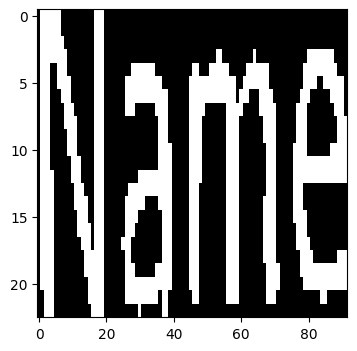

Name
wordID 1
i 1


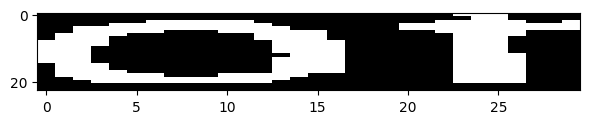

ot
wordID 2
i 2


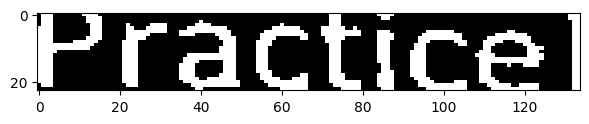

rraCticel
wordID 3
i 3


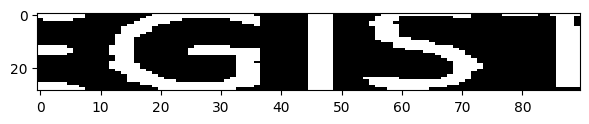

JZGIsl
wordID 4
i 4


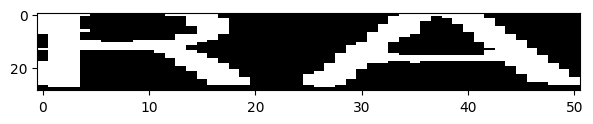

HA
wordID 5
i 5


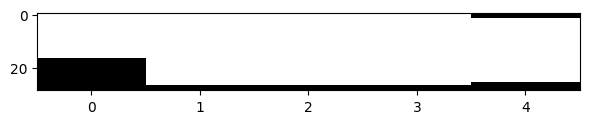

l
wordID 6
i 6


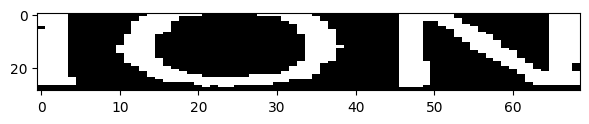

lUN
wordID 7
i 7


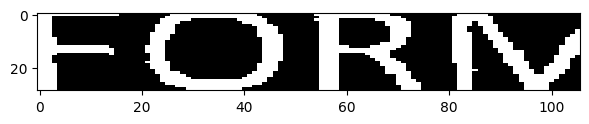

FORl
wordID 8
i 8


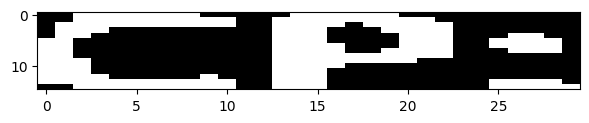

Cpt
wordID 9
i 9


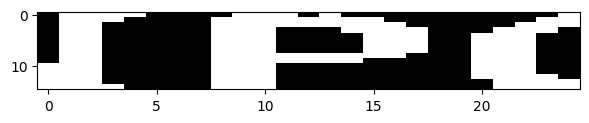

IPl
wordID 10
i 10


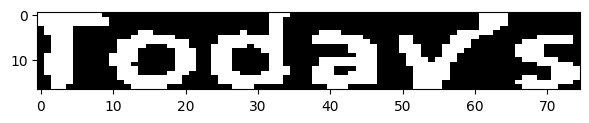

rOdaws
wordID 11
i 11


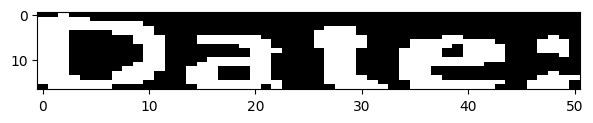

Uate1
wordID 12
i 12


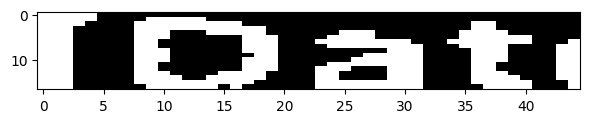

rD3t1
wordID 13
i 13


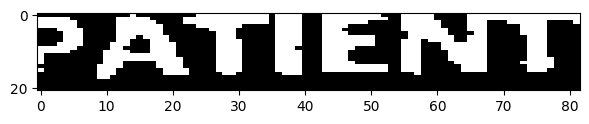

pATiER
wordID 14
i 14


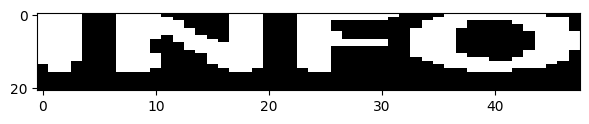

iNFo
wordID 15
i 15


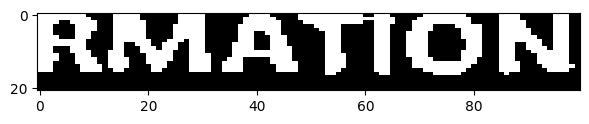

RMAnoN
wordID 16
i 16


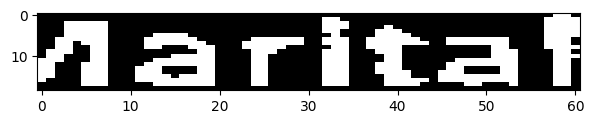

narita1
wordID 17
i 17


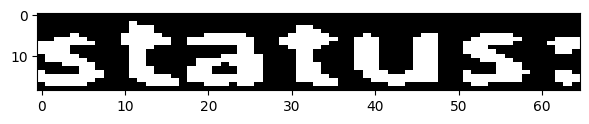

statusI
wordID 18
i 18


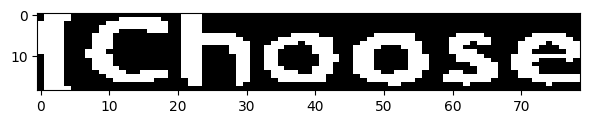

lchoose
wordID 19
i 19


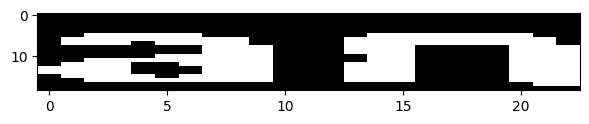

an
wordID 20
i 20


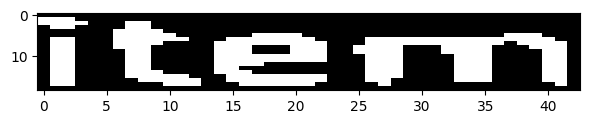

item
wordID 21
i 21


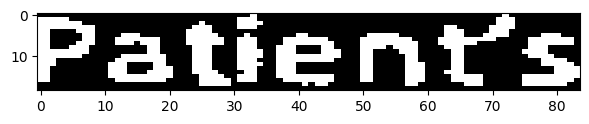

Patiencs
wordID 22
i 22


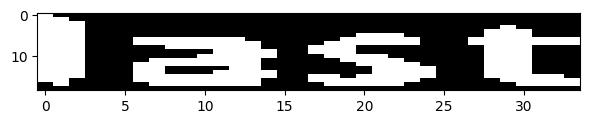

1ast
wordID 23
i 23


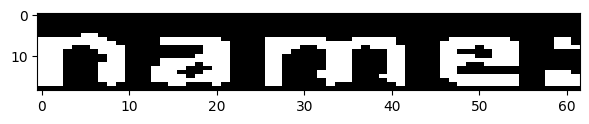

namel
wordID 24
i 24


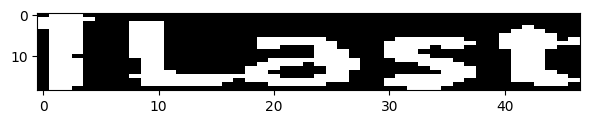

1ust
wordID 25
i 25


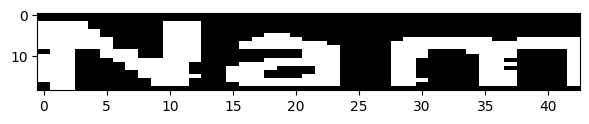

Nam
wordID 26
i 26


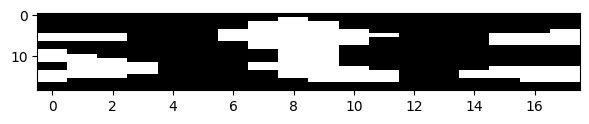

itI
wordID 27
i 27


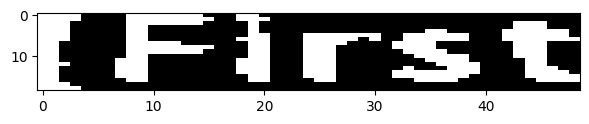

Ifirst
wordID 28
i 28


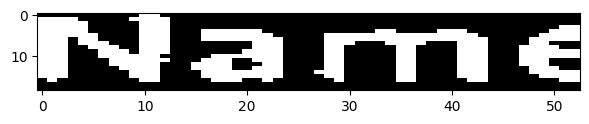

Namf
wordID 29
i 29


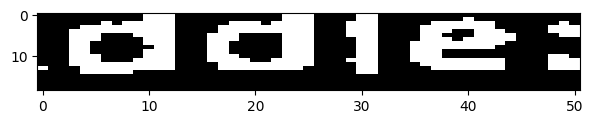

dd1e1
wordID 30
i 30


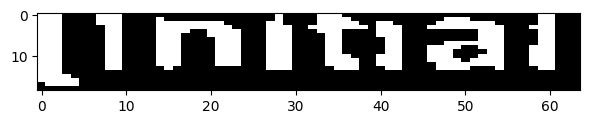

l1nit1al
wordID 31
i 31


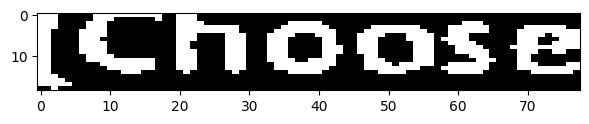

lcNoOse
wordID 32
i 32


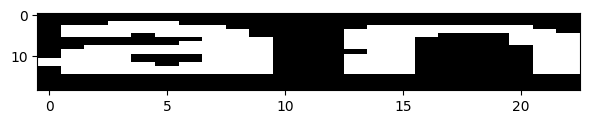

an
wordID 33
i 33


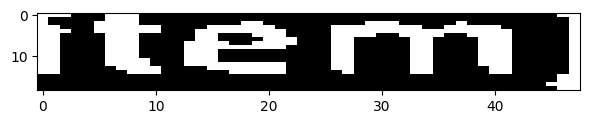

iteMl
wordID 34
i 34


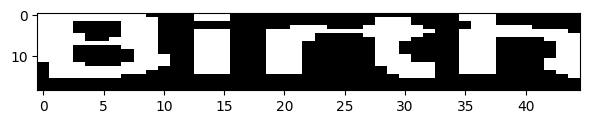

Binh
wordID 35
i 35


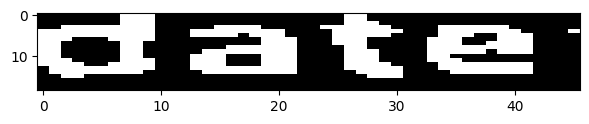

cate
wordID 36
i 36


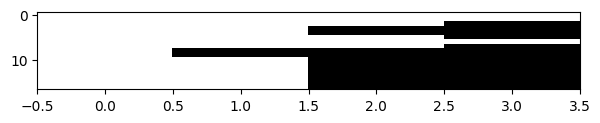

f
wordID 37
i 37


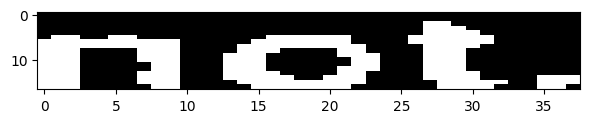

nOt
wordID 38
i 38


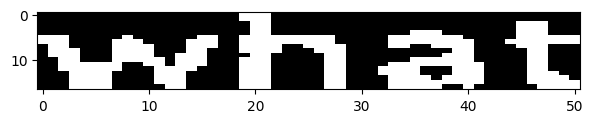

What
wordID 39
i 39


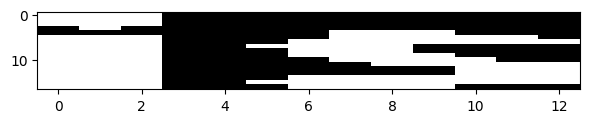

is
wordID 40
i 40


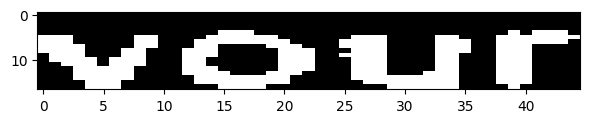

vOur
wordID 41
i 41


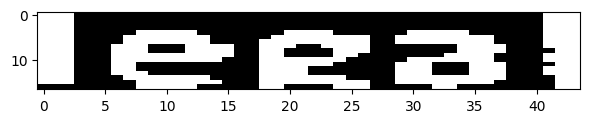

leRa1
wordID 42
i 42


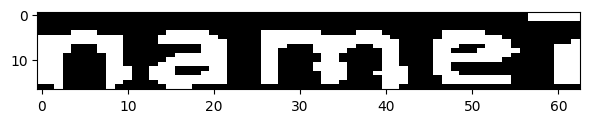

namei
wordID 43
i 43


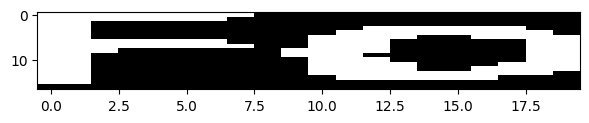

Fo
wordID 44
i 44


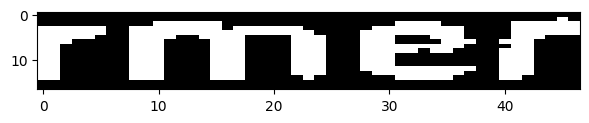

rmer
wordID 45
i 45


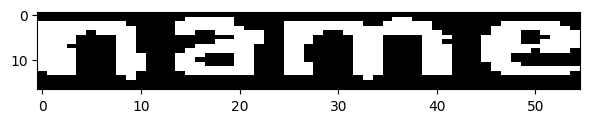

n3me
wordID 46
i 46


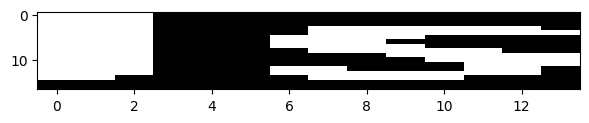

is
wordID 47
i 47


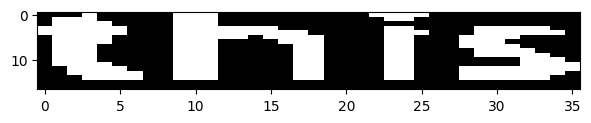

this
wordID 48
i 48


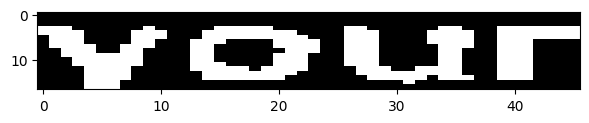

y2ur
wordID 49
i 49


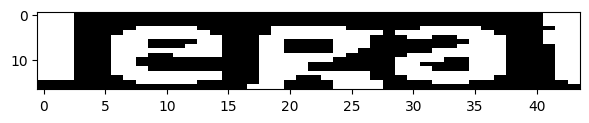

leRa1
wordID 50
i 50


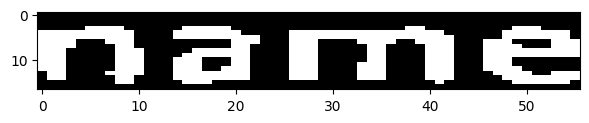

name
wordID 51
i 51


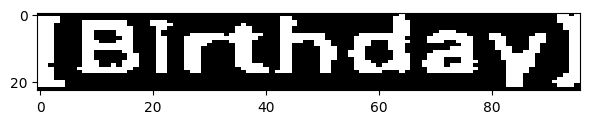

lBinhdaY1
wordID 52
i 52


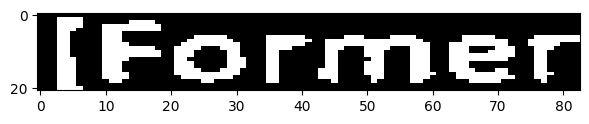

iformer
wordID 53
i 53


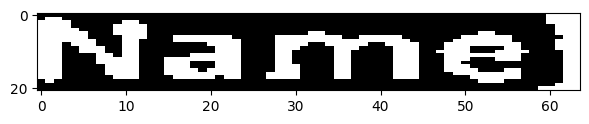

Name1
wordID 54
i 54


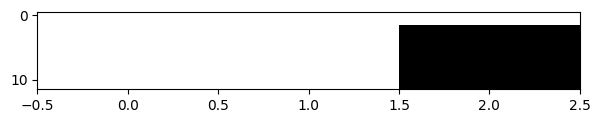

I
wordID 55
i 55


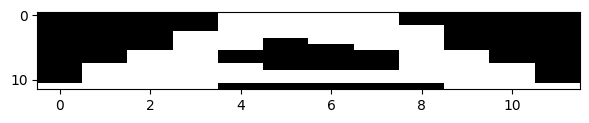

a
wordID 56
i 56


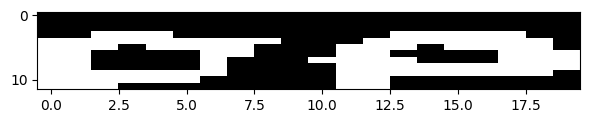

7A
wordID 57
i 57


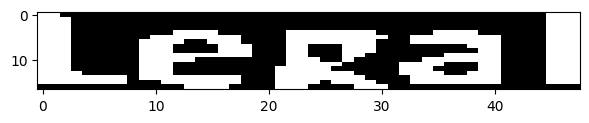

LeRal
wordID 58
i 58


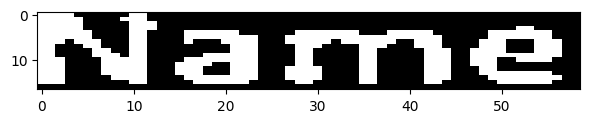

Name
wordID 59
i 59


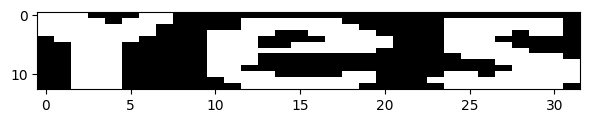

Ye5
wordID 60
i 60


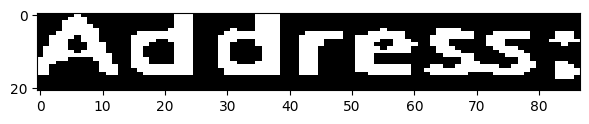

Addren1
wordID 61
i 61


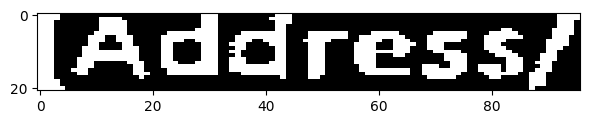

lAddre5sl
wordID 62
i 62


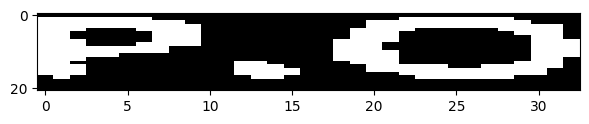

Po
wordID 63
i 63


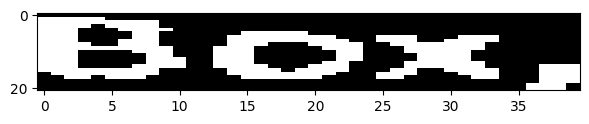

BDx
wordID 64
i 64


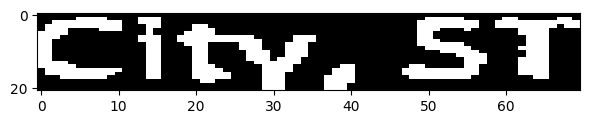

CiwsT
wordID 65
i 65


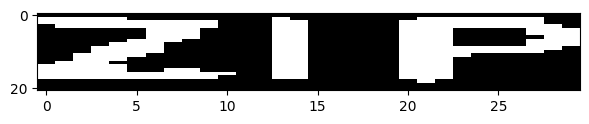

ZlP
wordID 66
i 66


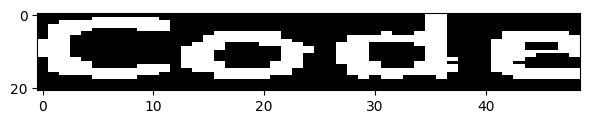

cOde
wordID 67
i 67


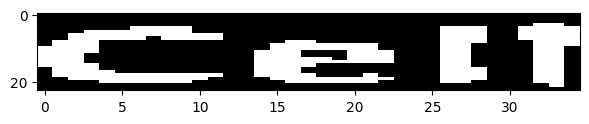

ceI1
wordID 68
i 68


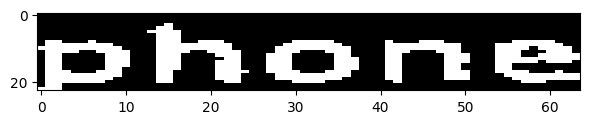

phone
wordID 69
i 69


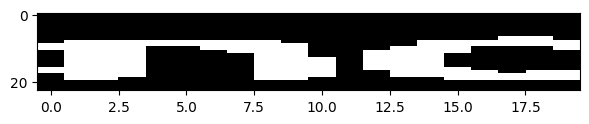

nc
wordID 70
i 70


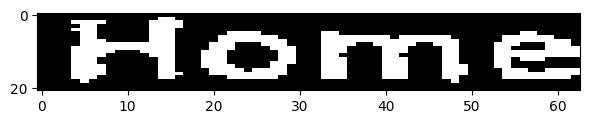

HOme
wordID 71
i 71


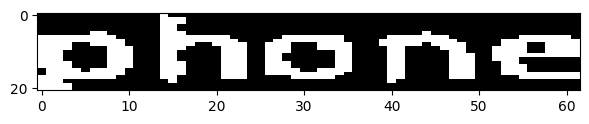

phone
wordID 72
i 72


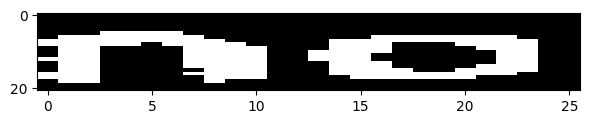

no
wordID 73
i 73


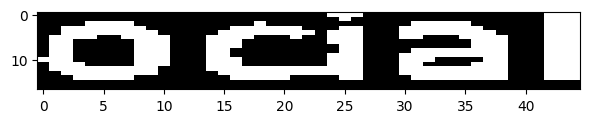

Oaal
wordID 74
i 74


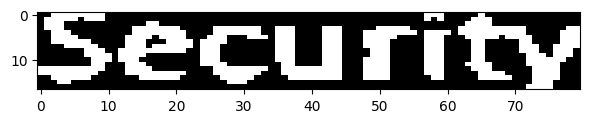

5ecuriw
wordID 75
i 75


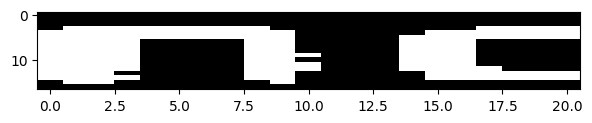

nC
wordID 76
i 76


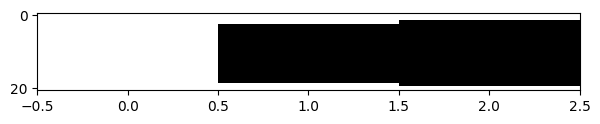

l
wordID 77
i 77


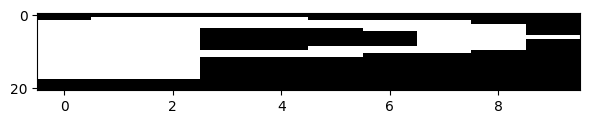

P
wordID 78
i 78


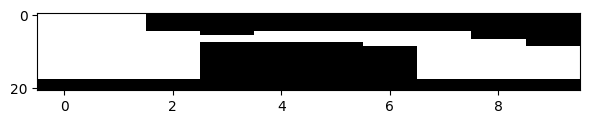

h
wordID 79
i 79


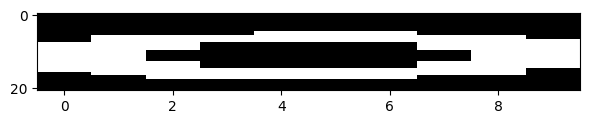

o
wordID 80
i 80


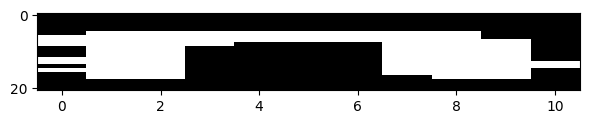

n
wordID 81
i 81


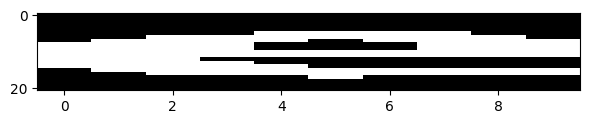

e
wordID 82
i 82


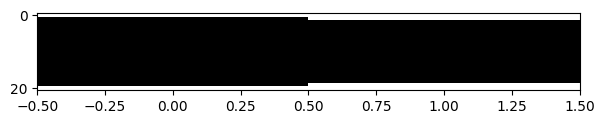

qJ
wordID 83
i 83


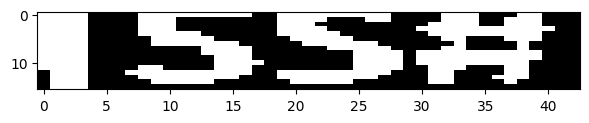

i55X
wordID 84
i 84


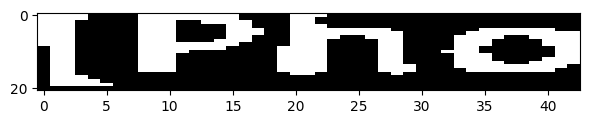

lPho
wordID 85
i 85


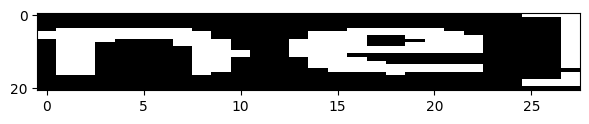

nel
wordID 86
i 86


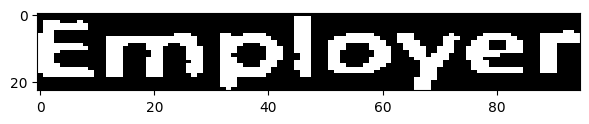

EmplOYer
wordID 87
i 87


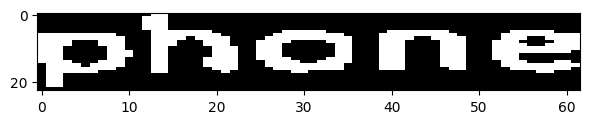

phone
wordID 88
i 88


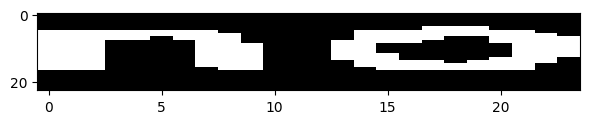

no
wordID 89
i 89


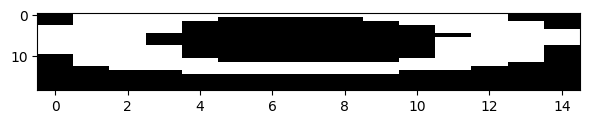

O
wordID 90
i 90


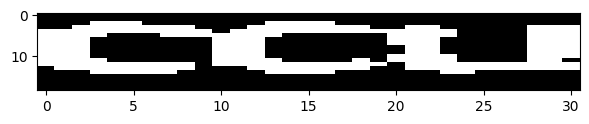

w
wordID 91
i 91


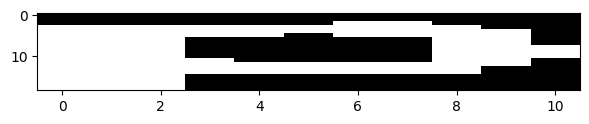

p
wordID 92
i 92


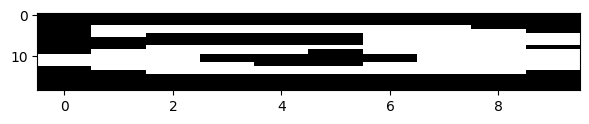

a
wordID 93
i 93


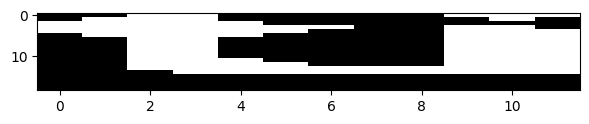

U
wordID 94
i 94


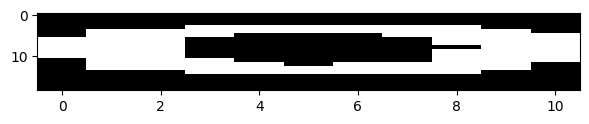

O
wordID 95
i 95


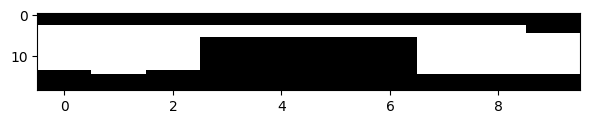

n
wordID 96
i 96


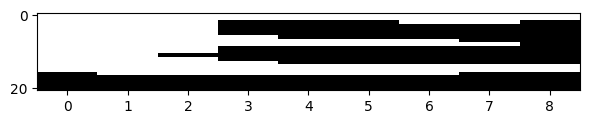

E
wordID 97
i 97


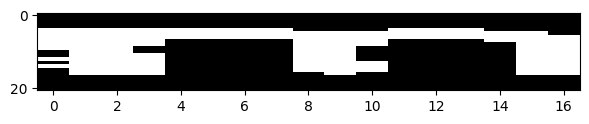

m
wordID 98
i 98


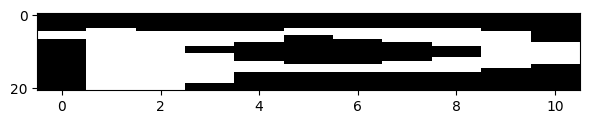

p
wordID 99
i 99


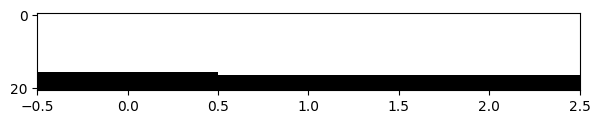

l
wordID 100
i 100


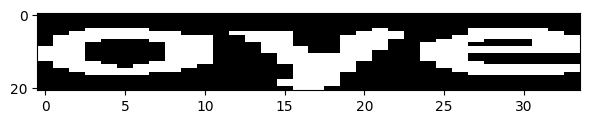

Oye
wordID 101
i 101


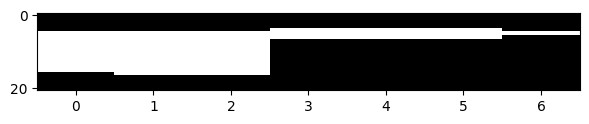

r
wordID 102
i 102


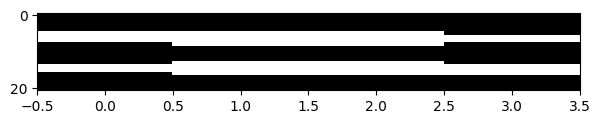

oQ
wordID 103
i 103


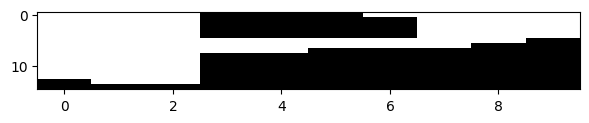

e
wordID 104
i 104


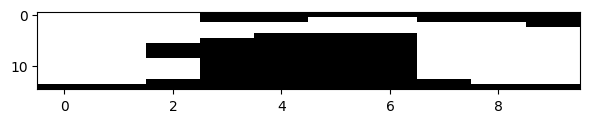

n
wordID 105
i 105


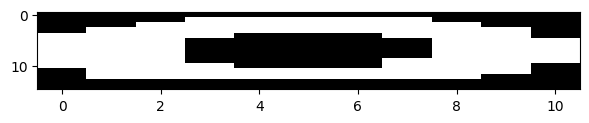

O
wordID 106
i 106


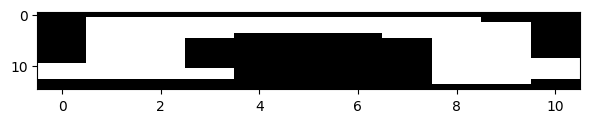

n
wordID 107
i 107


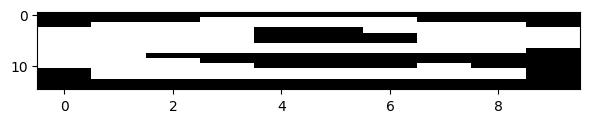

e
wordID 108
i 108


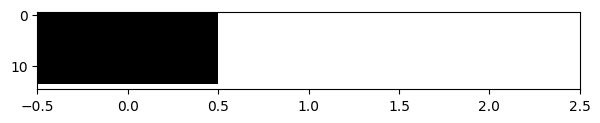

l
wordID 109
i 109


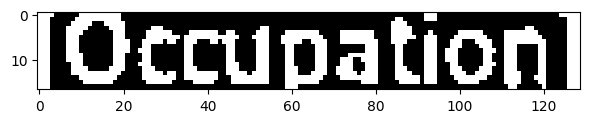

IOcNDatiOn1
wordID 110
i 110


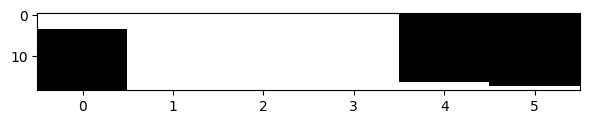

l
wordID 111
i 111


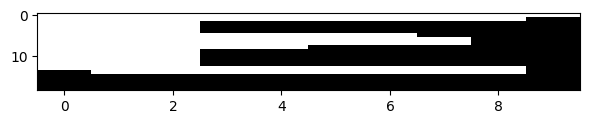

E
wordID 112
i 112


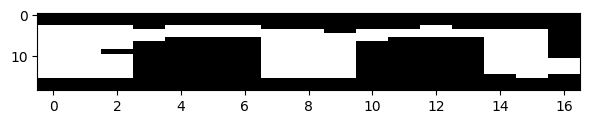

m
wordID 113
i 113


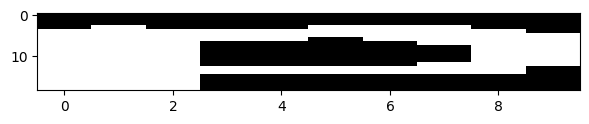

p
wordID 114
i 114


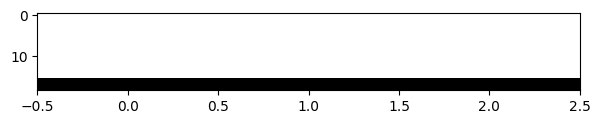

l
wordID 115
i 115


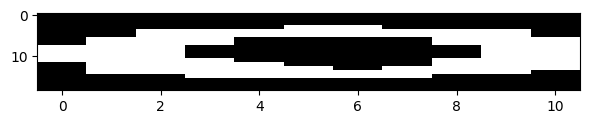

O
wordID 116
i 116


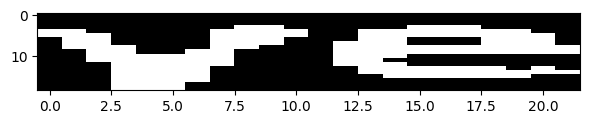

Ye
wordID 117
i 117


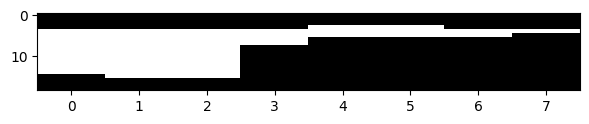

r
wordID 118
i 118


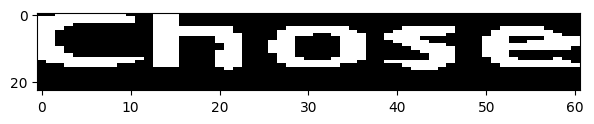

ChOse
wordID 119
i 119


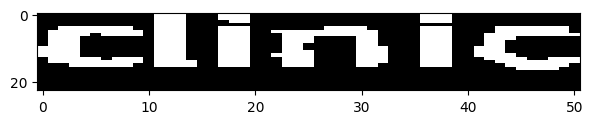

clinlc
wordID 120
i 120


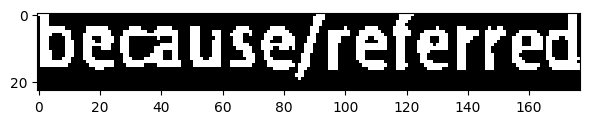

beuuselreferred
wordID 121
i 121


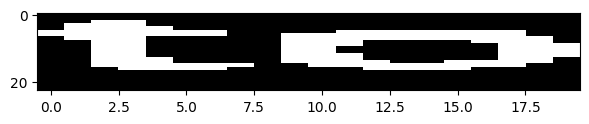

tO
wordID 122
i 122


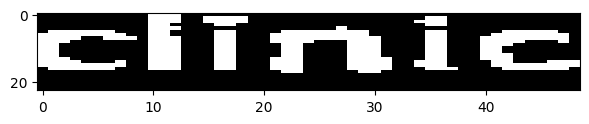

ClinlC
wordID 123
i 123


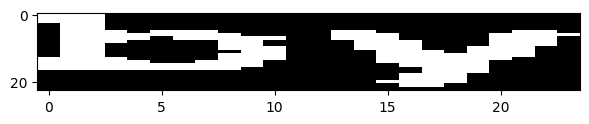

bY
wordID 124
i 124


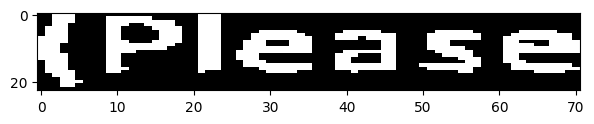

lP1ease
wordID 125
i 125


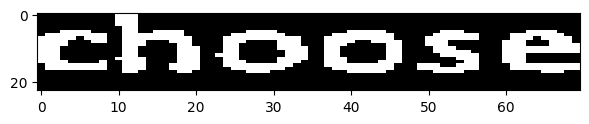

choose
wordID 126
i 126


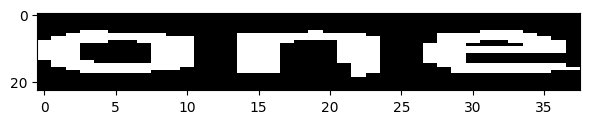

One
wordID 127
i 127


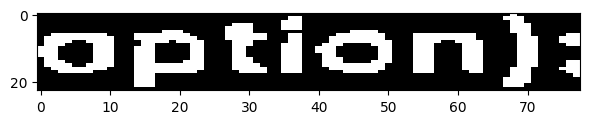

Option11
wordID 128
i 128


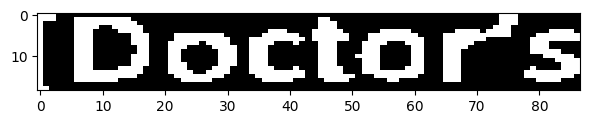

pDOCtocs
wordID 129
i 129


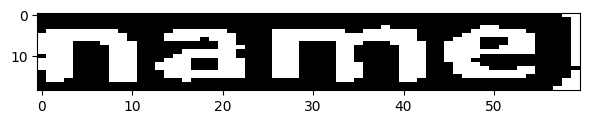

namel
wordID 130
i 130


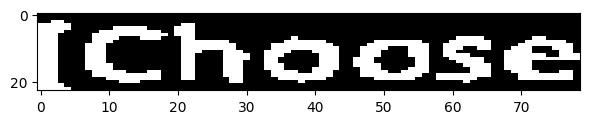

Ichoose
wordID 131
i 131


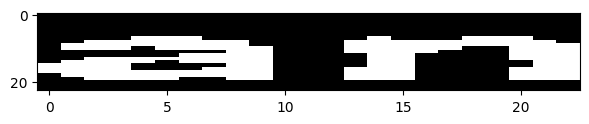

an
wordID 132
i 132


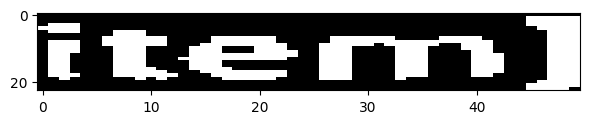

item1
wordID 133
i 133


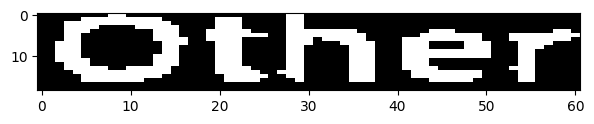

other
wordID 134
i 134


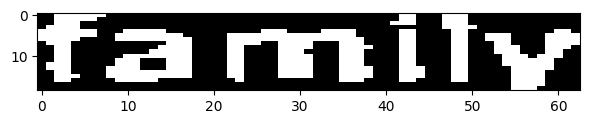

f3mllY
wordID 135
i 135


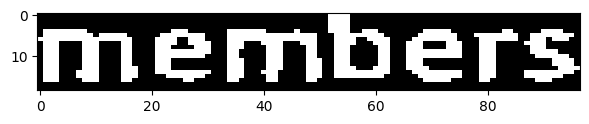

memberS
wordID 136
i 136


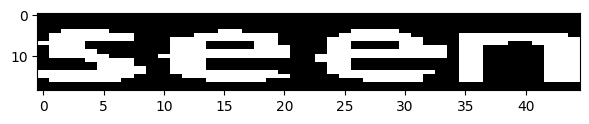

seen
wordID 137
i 137


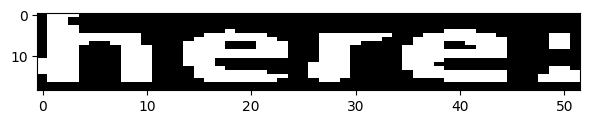

hereI
wordID 138
i 138


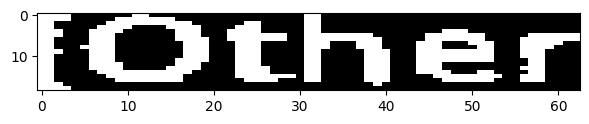

iother
wordID 139
i 139


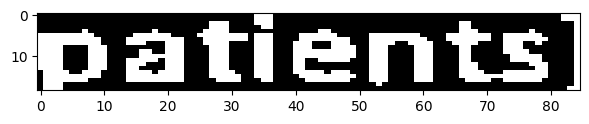

vatienu1
wordID 140
i 140


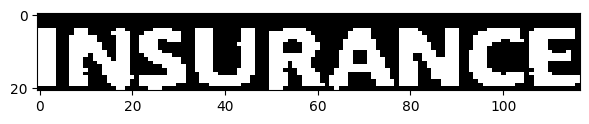

iNSURANcE
wordID 141
i 141


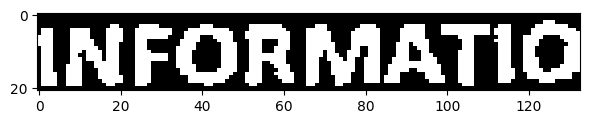

1NFORMAT1o
wordID 142
i 142


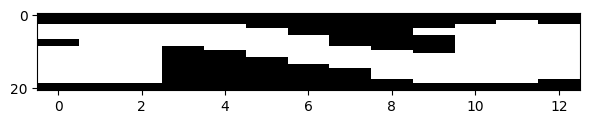

N
wordID 143
i 143


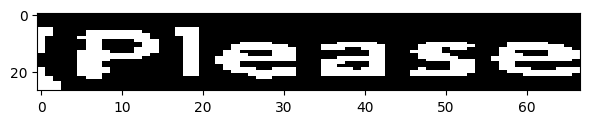

rip1ease
wordID 144
i 144


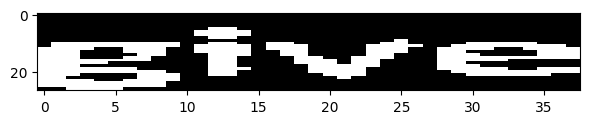

give
wordID 145
i 145


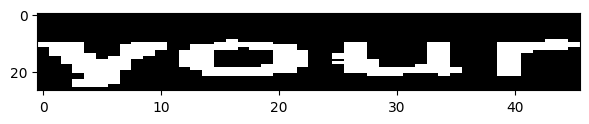

your
wordID 146
i 146


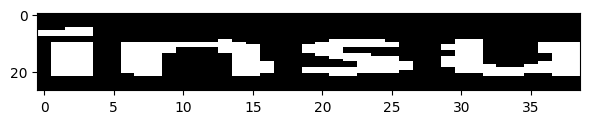

insu
wordID 147
i 147


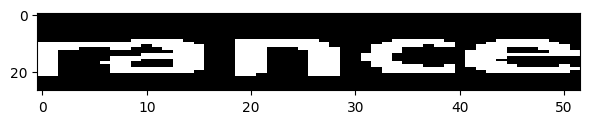

mnce
wordID 148
i 148


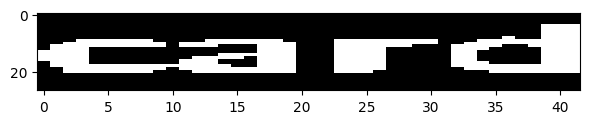

ard
wordID 149
i 149


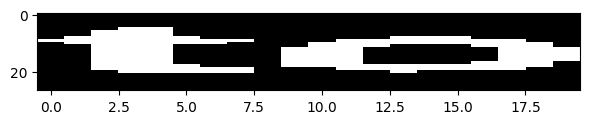

to
wordID 150
i 150


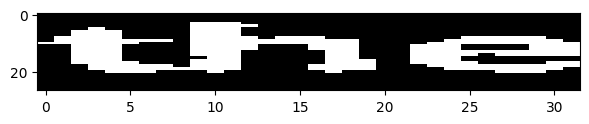

0e
wordID 151
i 151


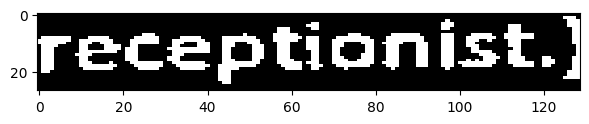

receptionist1
wordID 152
i 152


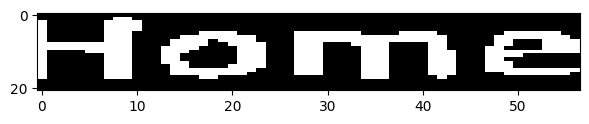

4ome
wordID 153
i 153


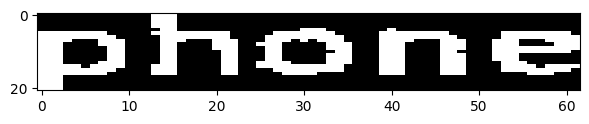

phOne
wordID 154
i 154


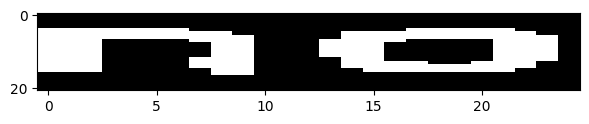

nO
wordID 155
i 155


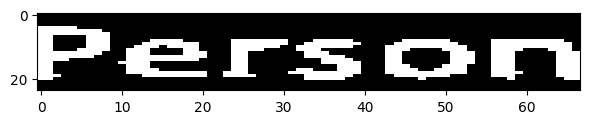

person
wordID 156
i 156


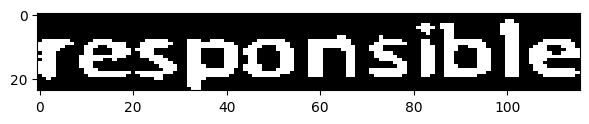

respOnsib1e
wordID 157
i 157


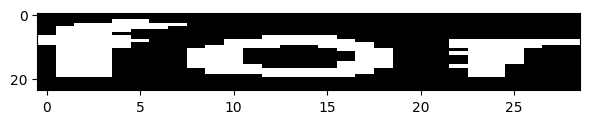

for
wordID 158
i 158


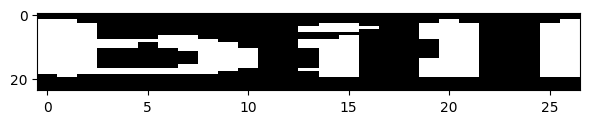

bi1l
wordID 159
i 159


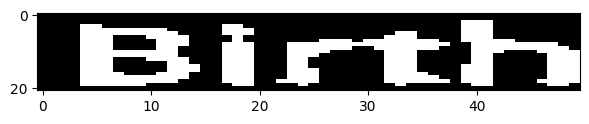

Binh
wordID 160
i 160


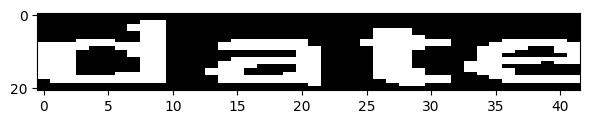

date
wordID 161
i 161


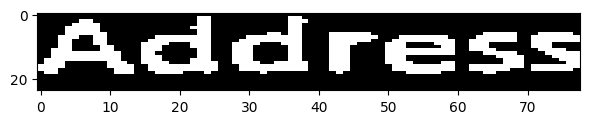

AddreSS
wordID 162
i 162


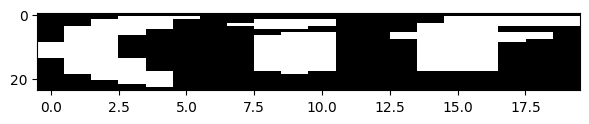

f1f
wordID 163
i 163


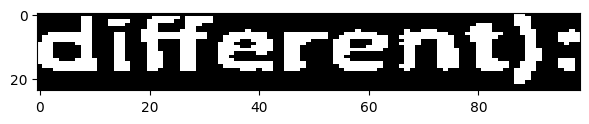

digerent1r
wordID 164
i 164


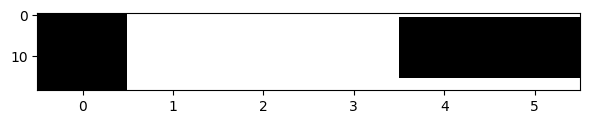

l
wordID 165
i 165


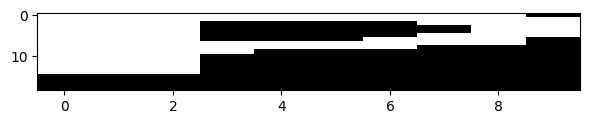

P
wordID 166
i 166


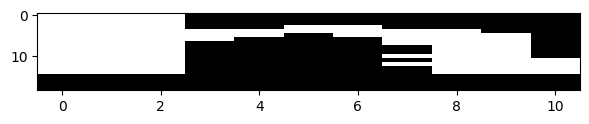

h
wordID 167
i 167


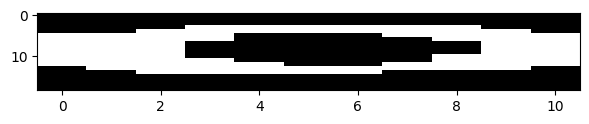

o
wordID 168
i 168


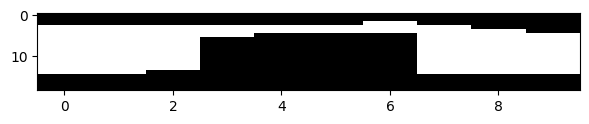

n
wordID 169
i 169


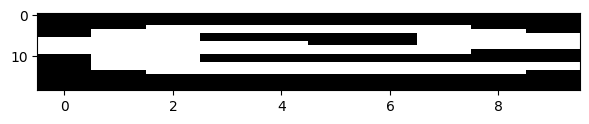

e
wordID 170
i 170


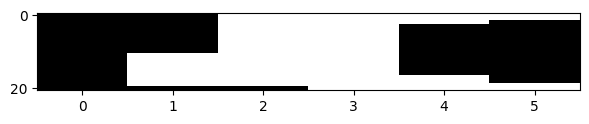

l
wordID 171
i 171


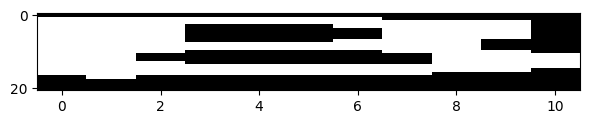

R
wordID 172
i 172


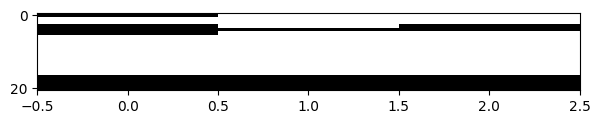

i
wordID 173
i 173


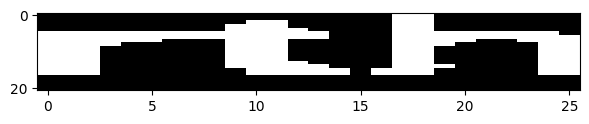

nh
wordID 174
i 174


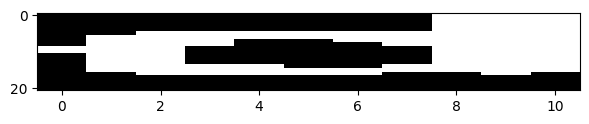

d
wordID 175
i 175


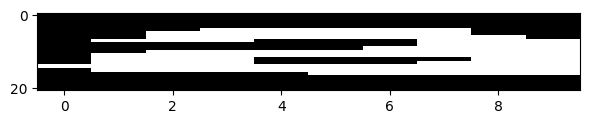

a
wordID 176
i 176


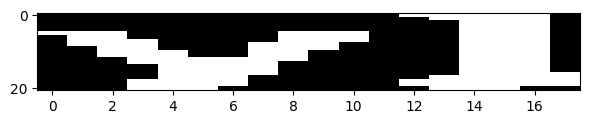

yJ
wordID 177
i 177


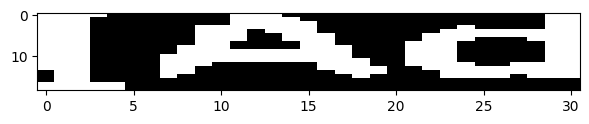

lAd
wordID 178
i 178


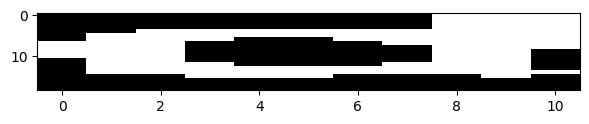

d
wordID 179
i 179


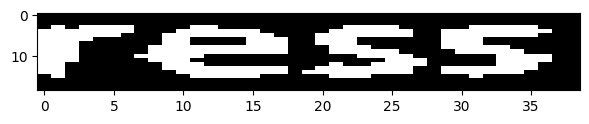

resS
wordID 180
i 180


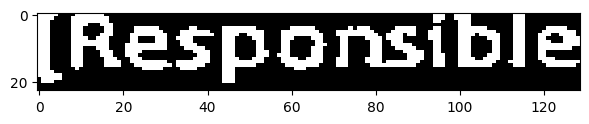

lReSPomib1e
wordID 181
i 181


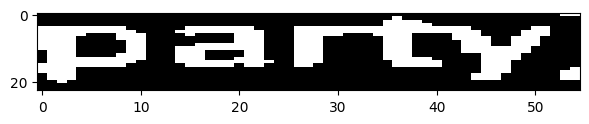

paMi
wordID 182
i 182


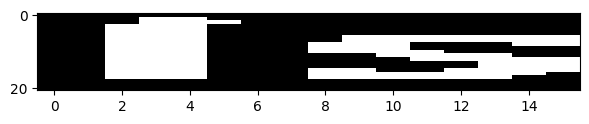

Is
wordID 183
i 183


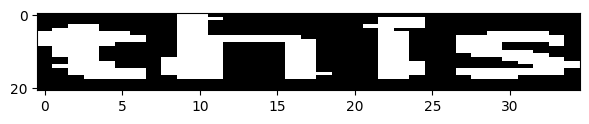

thiS
wordID 184
i 184


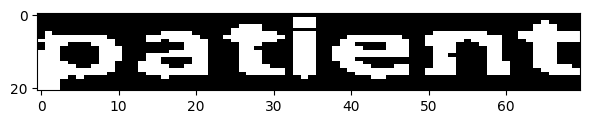

pat1ent
wordID 185
i 185


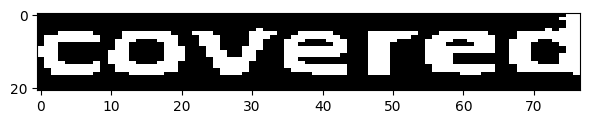

cOvered
wordID 186
i 186


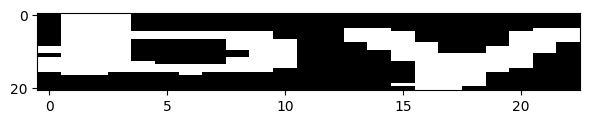

bY
wordID 187
i 187


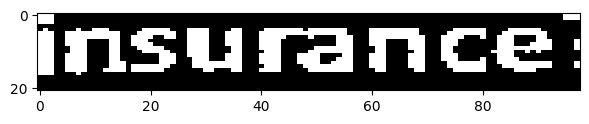

insuqnGeI
wordID 188
i 188


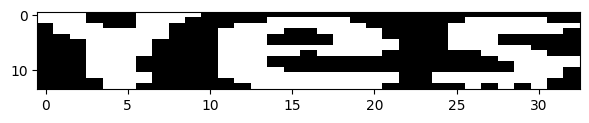

Yes
wordID 189
i 189


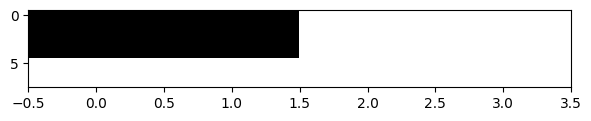

J
wordID 190
i 190


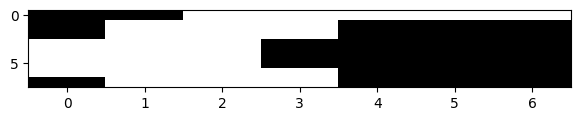

c
wordID 191
i 191


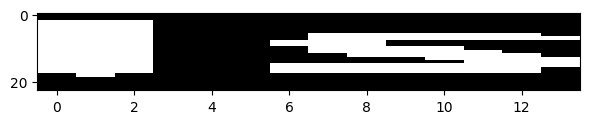

1s
wordID 192
i 192


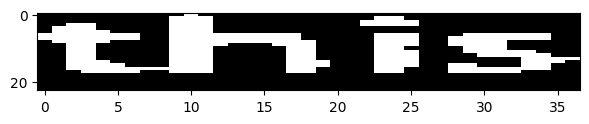

siS
wordID 193
i 193


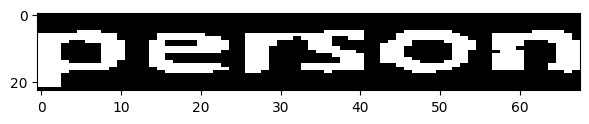

penOn
wordID 194
i 194


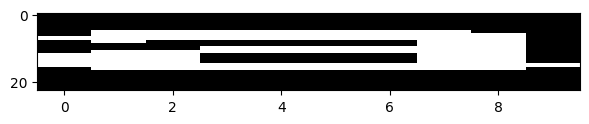

a
wordID 195
i 195


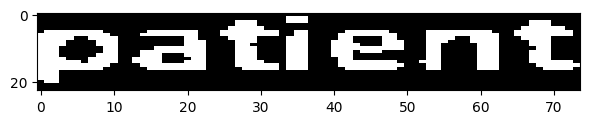

patient
wordID 196
i 196


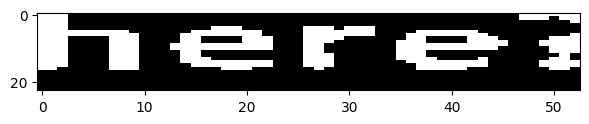

herei
wordID 197
i 197


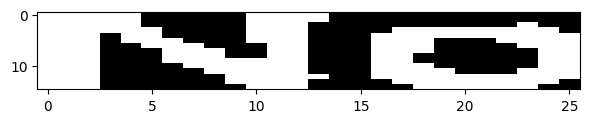

Nc
wordID 198
i 198


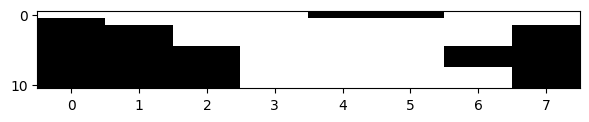

Y
wordID 199
i 199


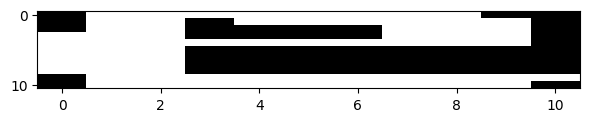

e
wordID 200
i 200


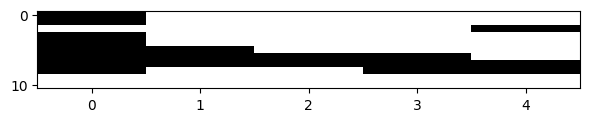

1
wordID 201
i 201


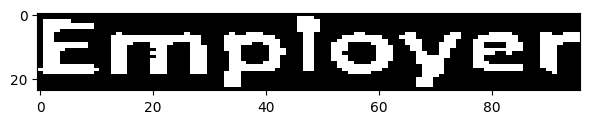

Emp1oyer
wordID 202
i 202


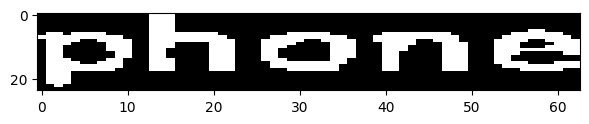

phOne
wordID 203
i 203


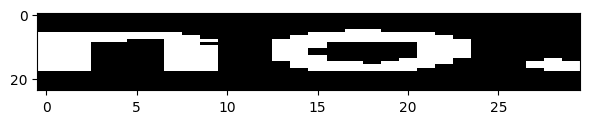

nO
wordID 204
i 204


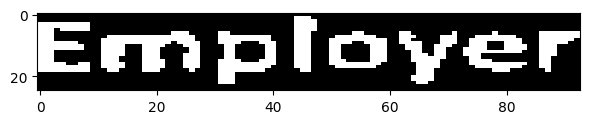

EmploYer
wordID 205
i 205


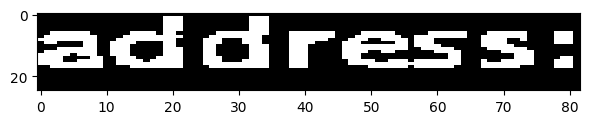

addrcsI
wordID 206
i 206


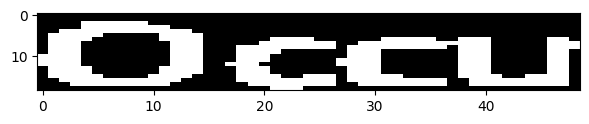

ocN
wordID 207
i 207


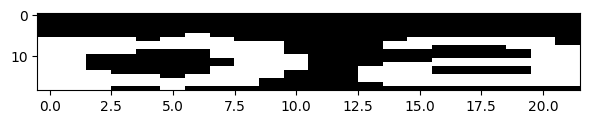

oa
wordID 208
i 208


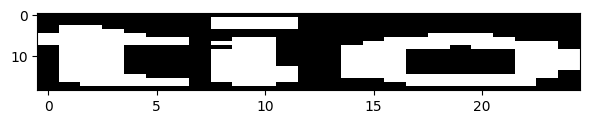

tiO
wordID 209
i 209


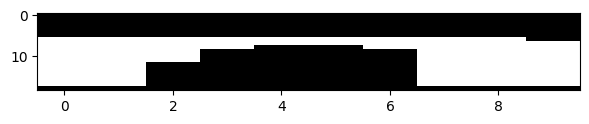

n
wordID 210
i 210


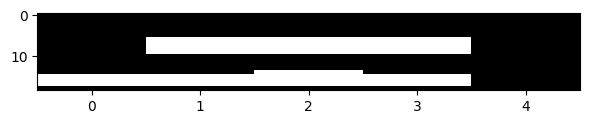

Ax
wordID 211
i 211


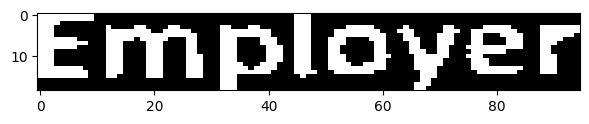

EmplOyer
wordID 212
i 212


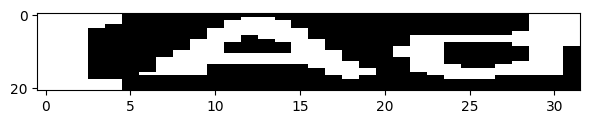

lAd
wordID 213
i 213


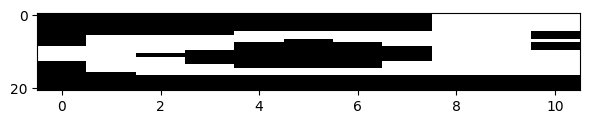

d
wordID 214
i 214


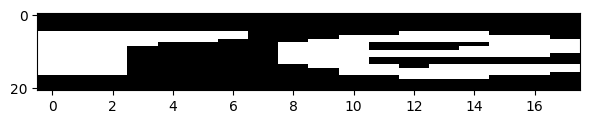

re
wordID 215
i 215


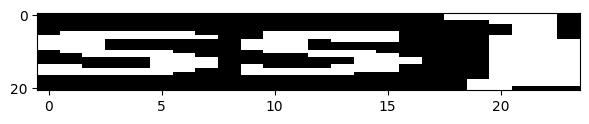

ssj
wordID 216
i 216


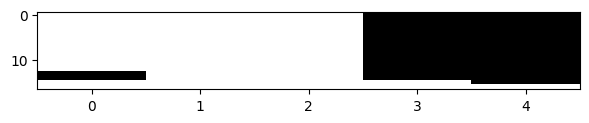

l
wordID 217
i 217


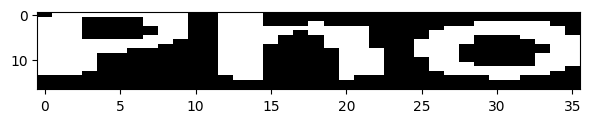

Pno
wordID 218
i 218


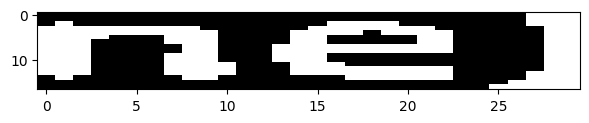

ne1
wordID 219
i 219


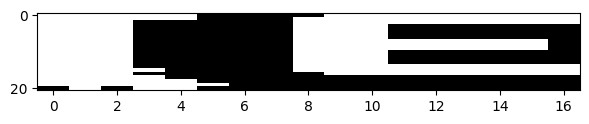

lE
wordID 220
i 220


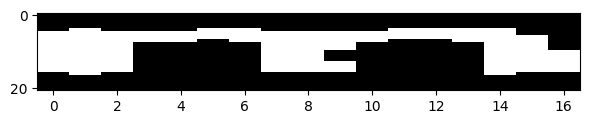

m
wordID 221
i 221


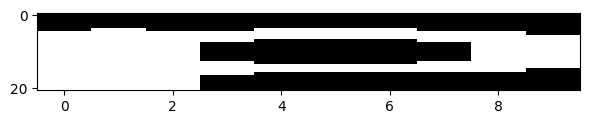

p
wordID 222
i 222


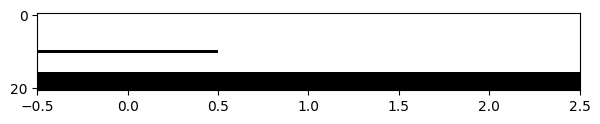

l
wordID 223
i 223


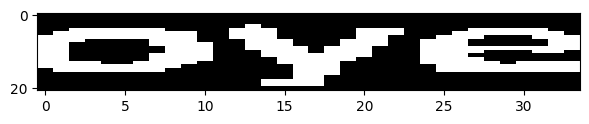

OYe
wordID 224
i 224


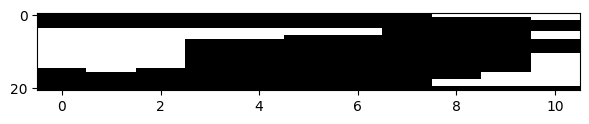

ri
wordID 225
i 225


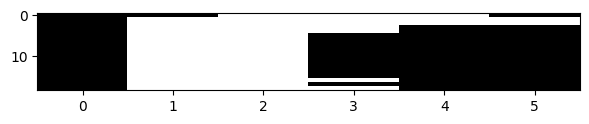

r
wordID 226
i 226


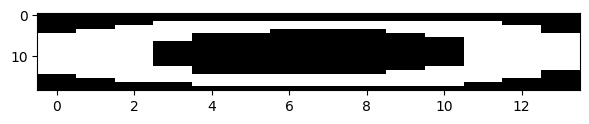

o
wordID 227
i 227


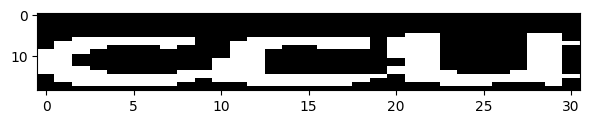

m
wordID 228
i 228


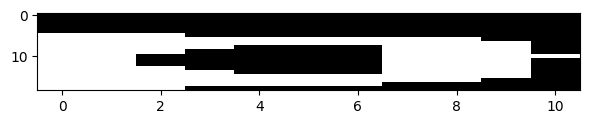

o
wordID 229
i 229


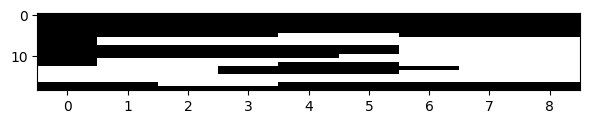

a
wordID 230
i 230


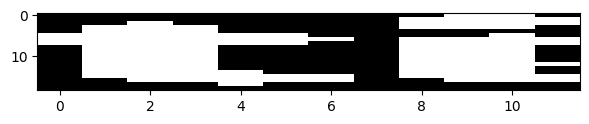

ti
wordID 231
i 231


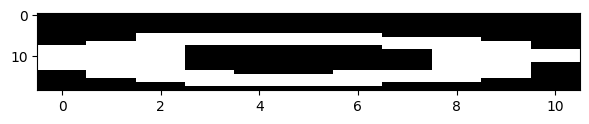

o
wordID 232
i 232


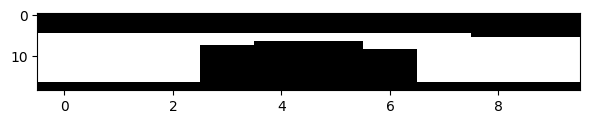

n
wordID 233
i 233


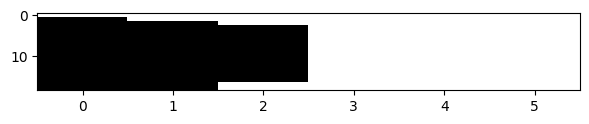

1
wordID 234
i 234


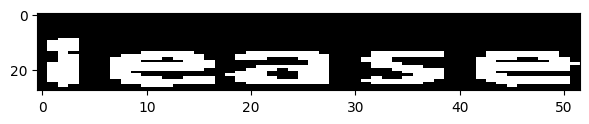

iease
wordID 235
i 235


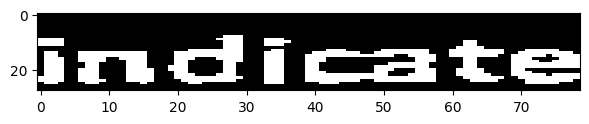

indiute
wordID 236
i 236


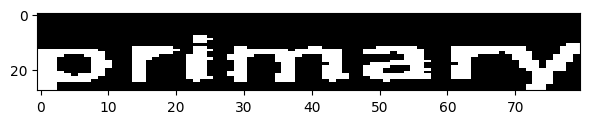

primaN
wordID 237
i 237


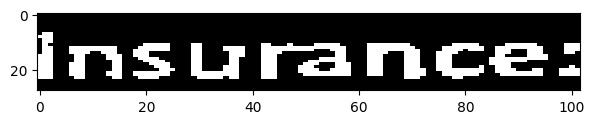

inSumnceI
wordID 238
i 238


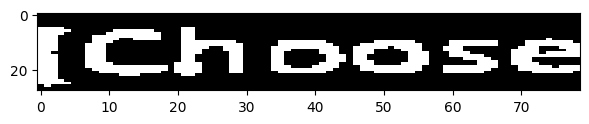

lchDO5e
wordID 239
i 239


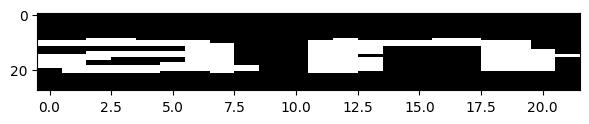

an
wordID 240
i 240


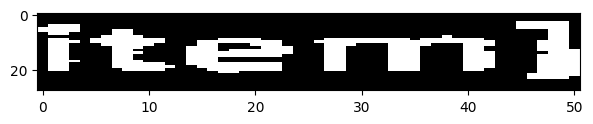

item1
wordID 241
i 241


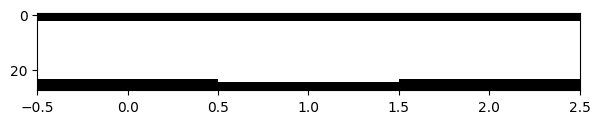

I
wordID 242
i 242


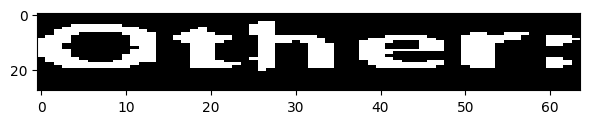

otherr
wordID 243
i 243


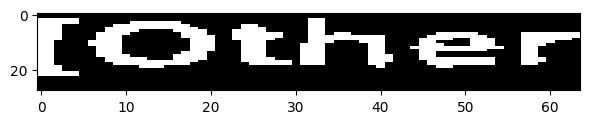

lother
wordID 244
i 244


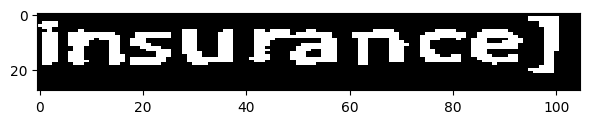

1nsumnCe1
wordID 245
i 245


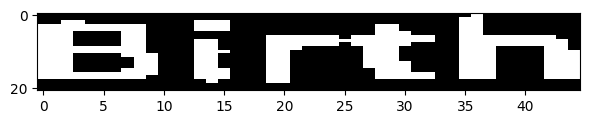

Binh
wordID 246
i 246


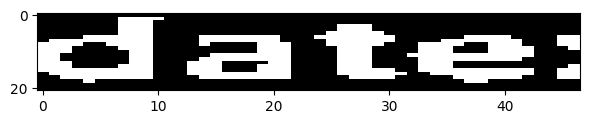

dateI
wordID 247
i 247


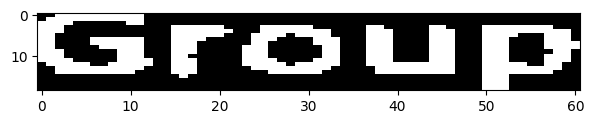

Group
wordID 248
i 248


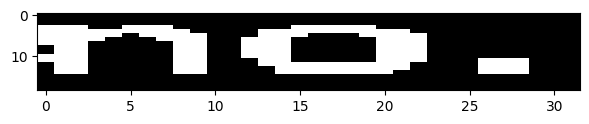

nO
wordID 249
i 249


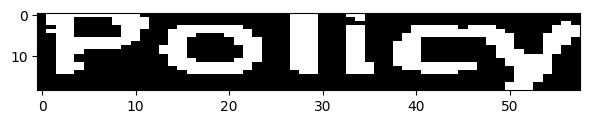

Poliq
wordID 250
i 250


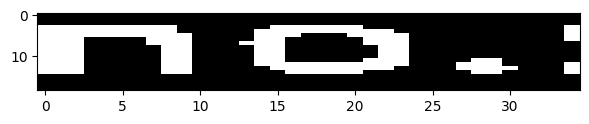

no1
wordID 251
i 251


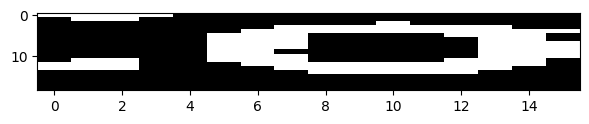

io
wordID 252
i 252


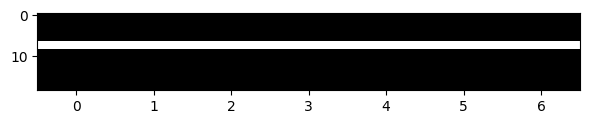

m
wordID 253
i 253


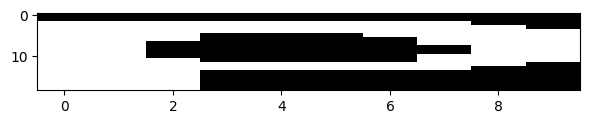

P
wordID 254
i 254


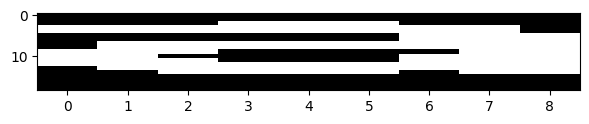

a
wordID 255
i 255


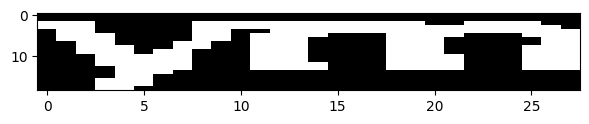

p
wordID 256
i 256


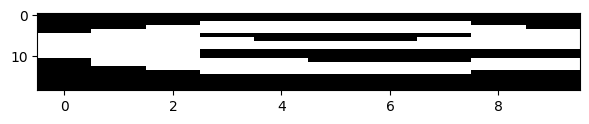

e
wordID 257
i 257


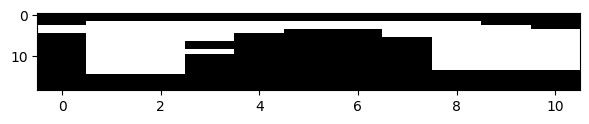

n
wordID 258
i 258


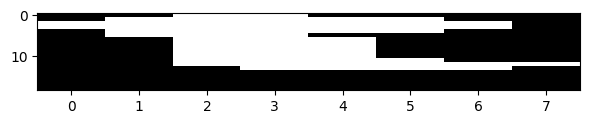

t
wordID 259
i 259


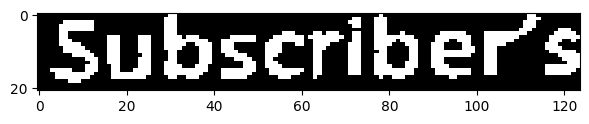

sUbscribecs
wordID 260
i 260


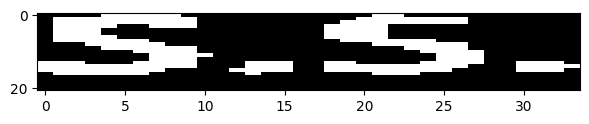

SS
wordID 261
i 261


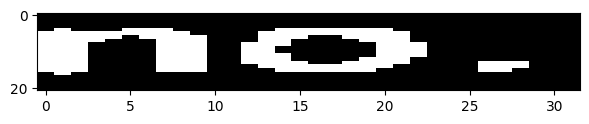

nO
wordID 262
i 262


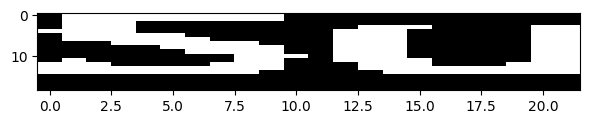

su
wordID 263
i 263


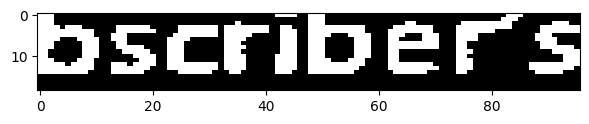

bscrjbers
wordID 264
i 264


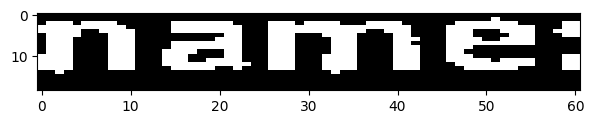

name1
wordID 265
i 265


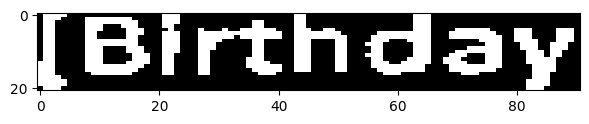

lBinhdaY
wordID 266
i 266


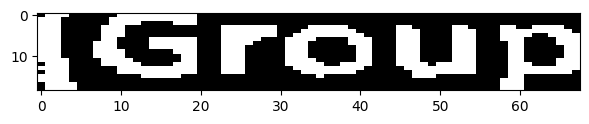

lGroup
wordID 267
i 267


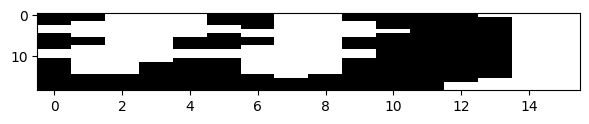

Nl
wordID 268
i 268


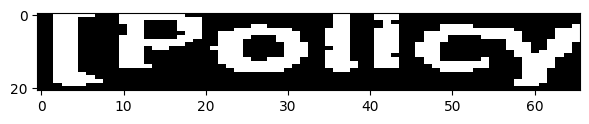

lPOliY
wordID 269
i 269


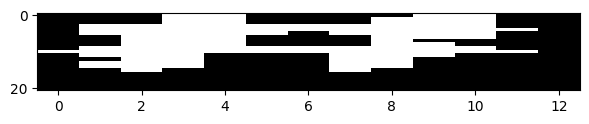

n
wordID 270
i 270


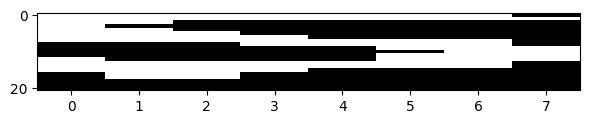

j
wordID 271
i 271


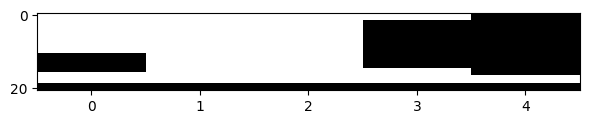

I
wordID 272
i 272


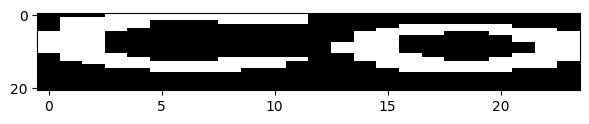

cc
wordID 273
i 273


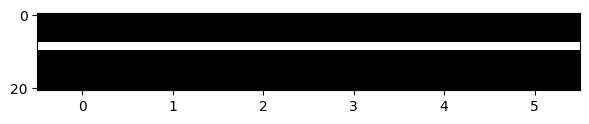

M
wordID 274
i 274


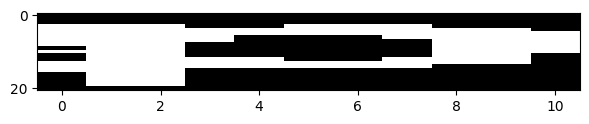

p
wordID 275
i 275


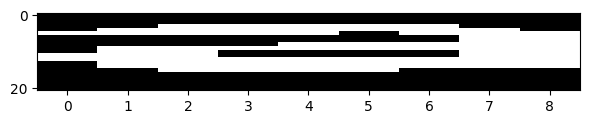

a
wordID 276
i 276


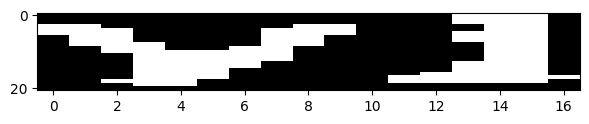

Yl
wordID 277
i 277


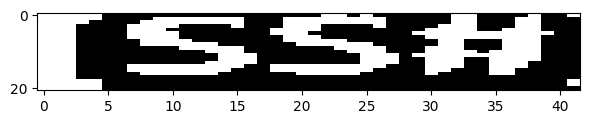

lSSnj
wordID 278
i 278


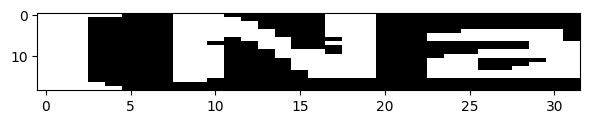

lNa
wordID 279
i 279


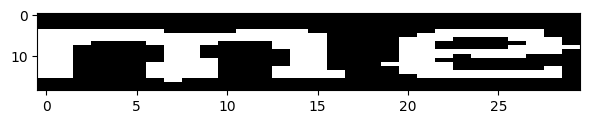

me
wordID 280
i 280


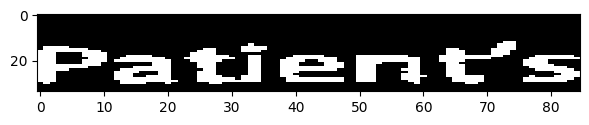

pacencs
wordID 281
i 281


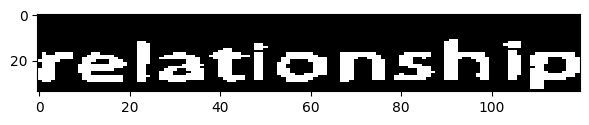

re1atIOnship
wordID 282
i 282


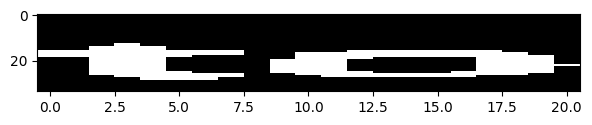

tO
wordID 283
i 283


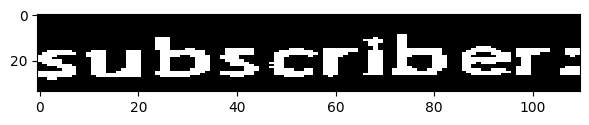

subscr1berI
wordID 284
i 284


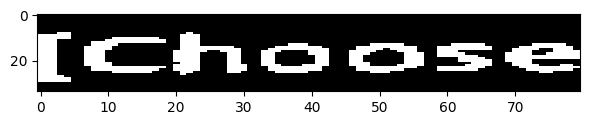

IchoOse
wordID 285
i 285


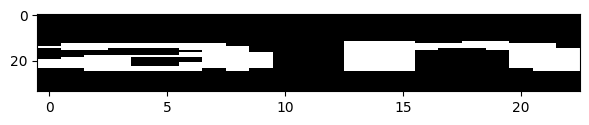

an
wordID 286
i 286


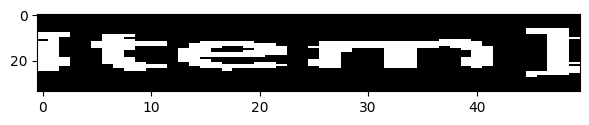

itemJ
wordID 287
i 287


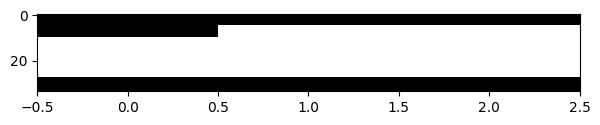

l
wordID 288
i 288


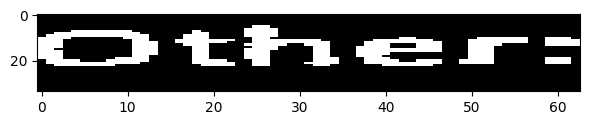

otherr
wordID 289
i 289


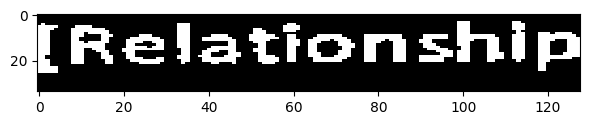

lRe1atiOnship
wordID 290
i 290


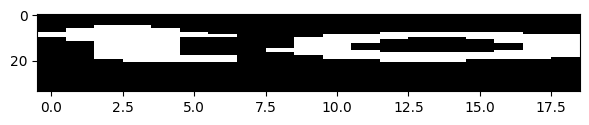

to
wordID 291
i 291


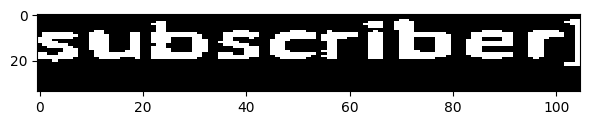

5ubscriberl
wordID 292
i 292


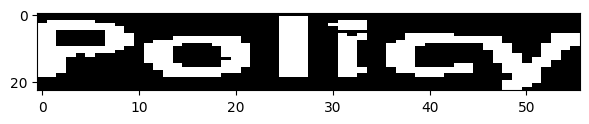

Pollw
wordID 293
i 293


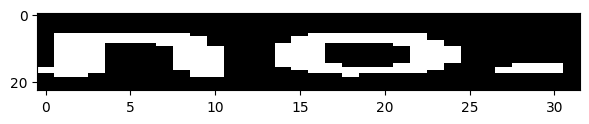

no
wordID 294
i 294


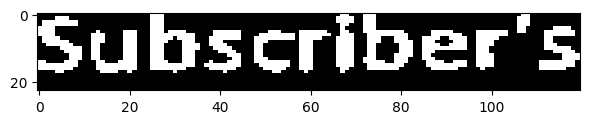

subscriberS
wordID 295
i 295


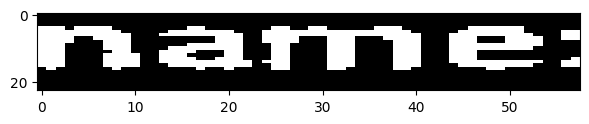

name1
wordID 296
i 296


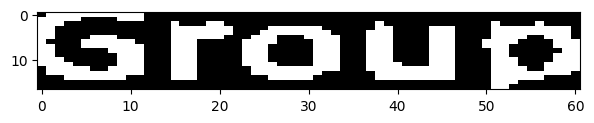

GrOun
wordID 297
i 297


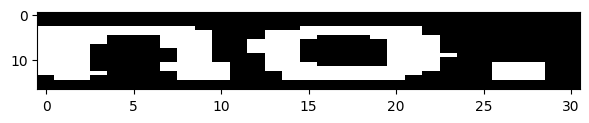

ng
wordID 298
i 298


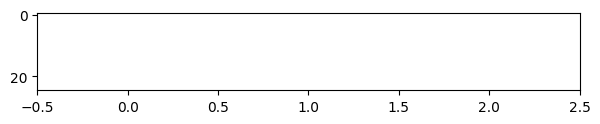

l
wordID 299
i 299


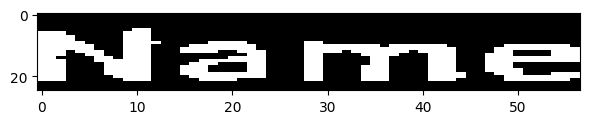

Name
wordID 300
i 300


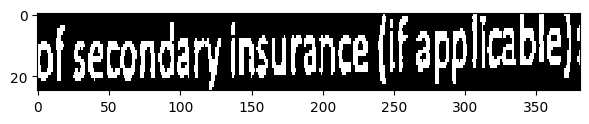

of5emndaainsurancellfaPp1i4bleJI
wordID 301
i 301


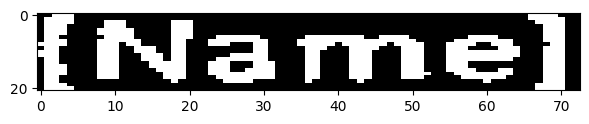

IName1
wordID 302
i 302


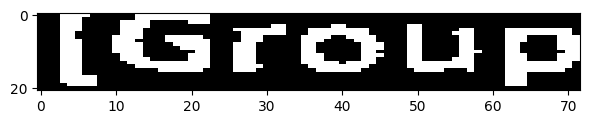

lGroup
wordID 303
i 303


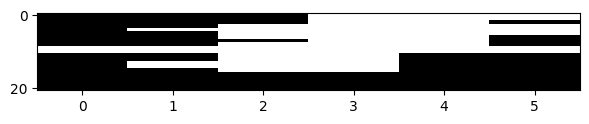

I
wordID 304
i 304


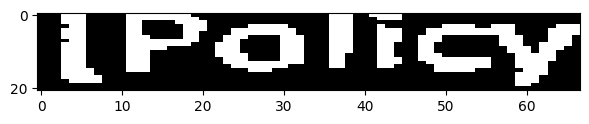

lPo1iq
wordID 305
i 305


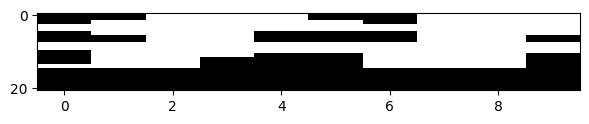

N
wordID 306
i 306


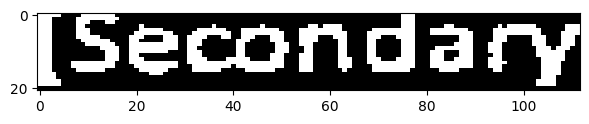

lSenndaT
wordID 307
i 307


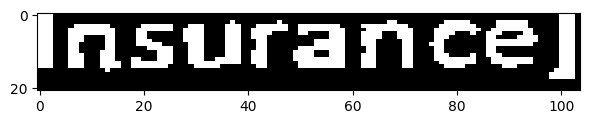

lnSUrance1
wordID 308
i 308


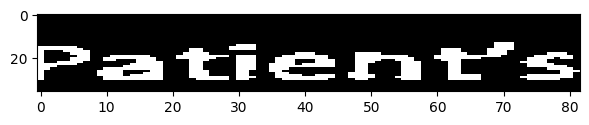

Patienfs
wordID 309
i 309


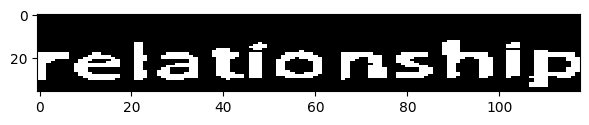

relatioaship
wordID 310
i 310


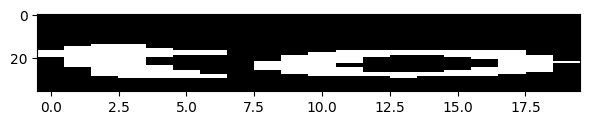

to
wordID 311
i 311


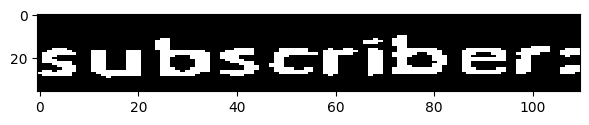

subsCriberI
wordID 312
i 312


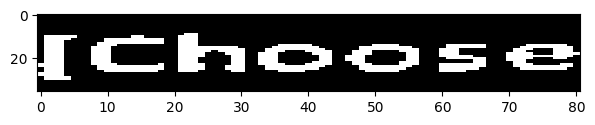

lChoo5e
wordID 313
i 313


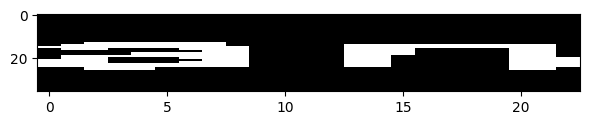

an
wordID 314
i 314


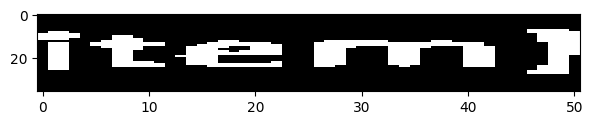

Item1
wordID 315
i 315


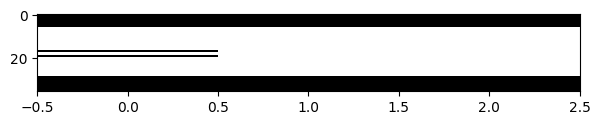

l
wordID 316
i 316


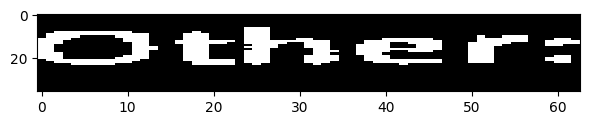

otherr
wordID 317
i 317


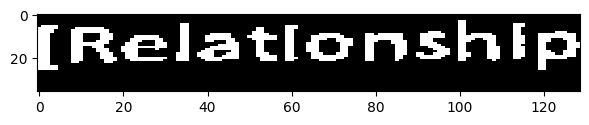

lRel3tIonship
wordID 318
i 318


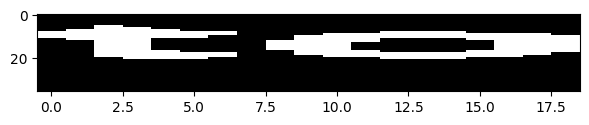

to
wordID 319
i 319


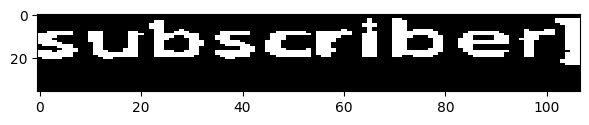

sub5criber1
wordID 320
i 320


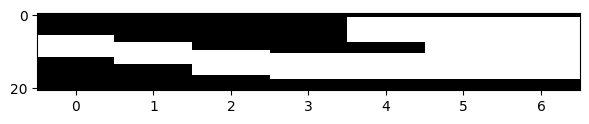

i
wordID 321
i 321


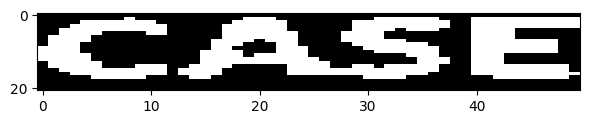

cME
wordID 322
i 322


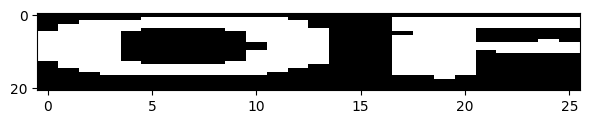

OF
wordID 323
i 323


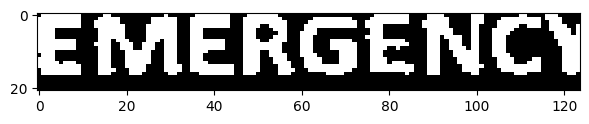

EMERGENCN
wordID 324
i 324


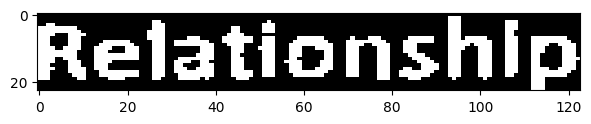

Re1ationship
wordID 325
i 325


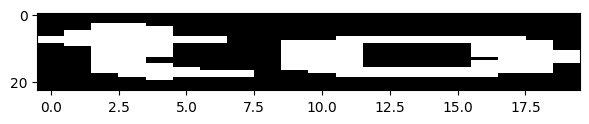

tO
wordID 326
i 326


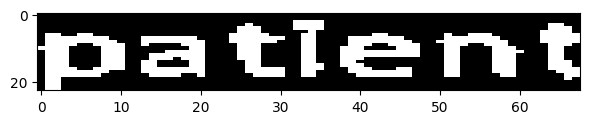

pat1ent
wordID 327
i 327


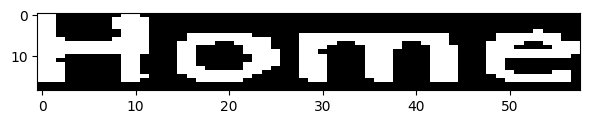

HOme
wordID 328
i 328


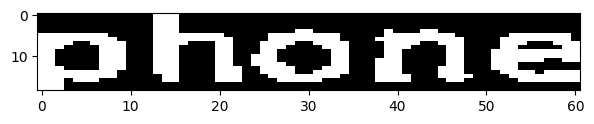

phcne
wordID 329
i 329


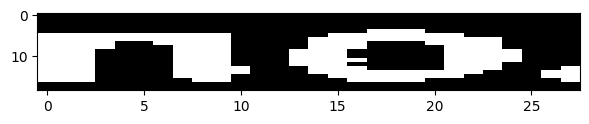

no
wordID 330
i 330


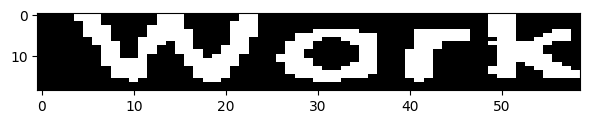

work
wordID 331
i 331


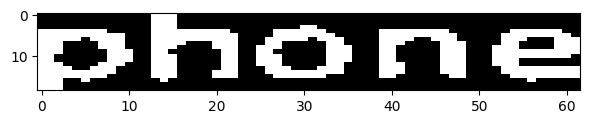

phone
wordID 332
i 332


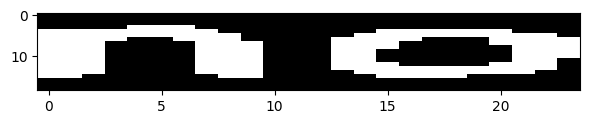

nO
wordID 333
i 333


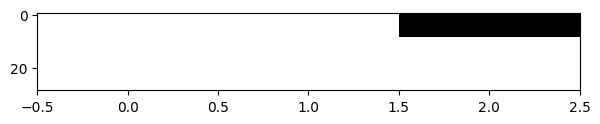

l
wordID 334
i 334


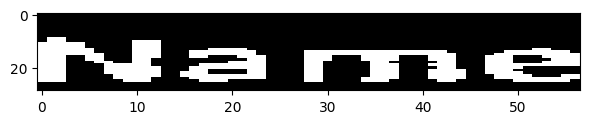

Name
wordID 335
i 335


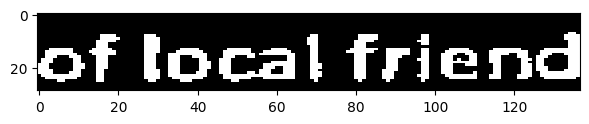

OflOu1fr1end
wordID 336
i 336


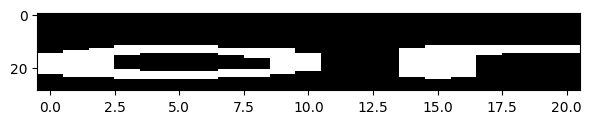

or
wordID 337
i 337


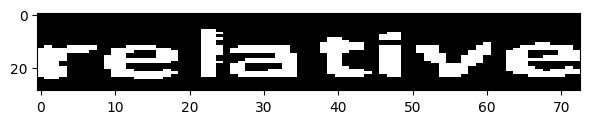

re1ative
wordID 338
i 338


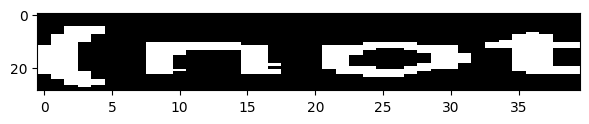

lnOt
wordID 339
i 339


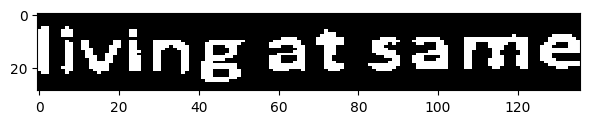

11vingatsame
wordID 340
i 340


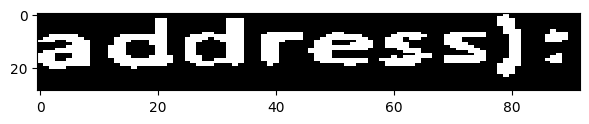

address1t
wordID 341
i 341


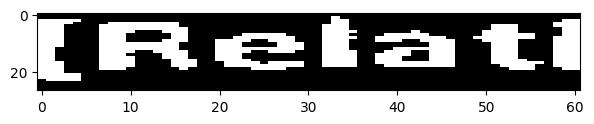

lRelati
wordID 342
i 342


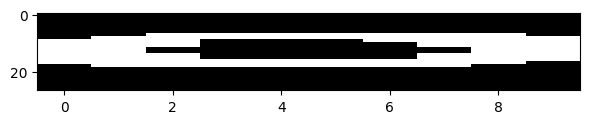

o
wordID 343
i 343


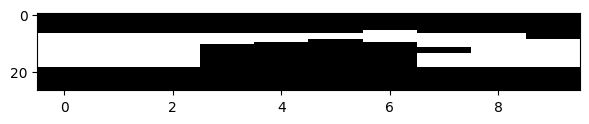

n
wordID 344
i 344


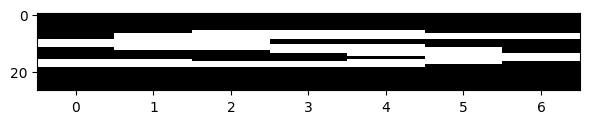

s
wordID 345
i 345


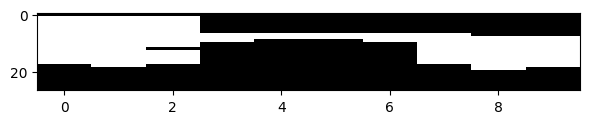

h
wordID 346
i 346


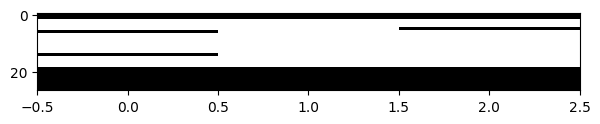

1
wordID 347
i 347


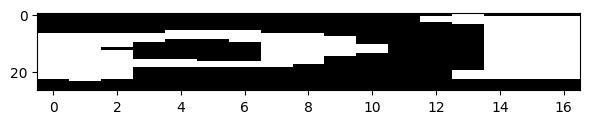

p1
wordID 348
i 348


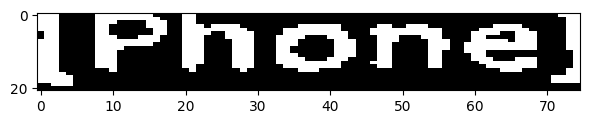

lPhonel
wordID 349
i 349


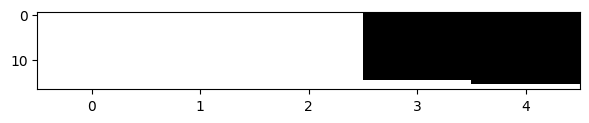

l
wordID 350
i 350


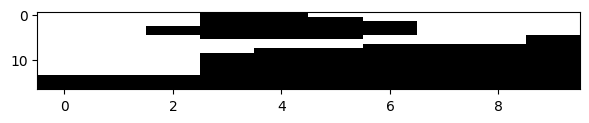

P
wordID 351
i 351


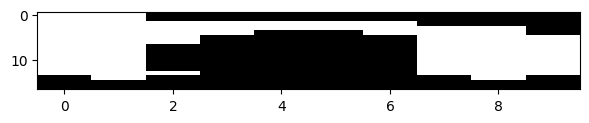

n
wordID 352
i 352


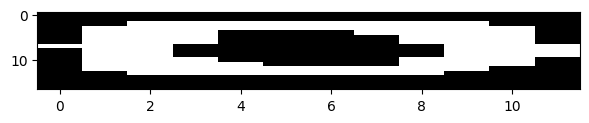

O
wordID 353
i 353


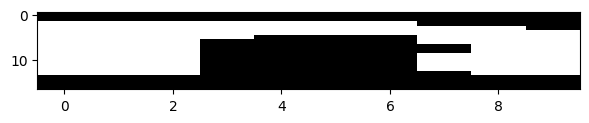

n
wordID 354
i 354


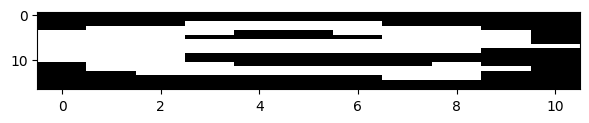

e
wordID 355
i 355


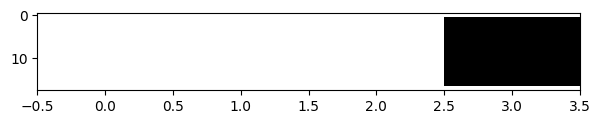

l
wordID 356
i 356


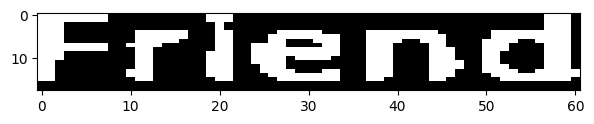

Friend
wordID 357
i 357


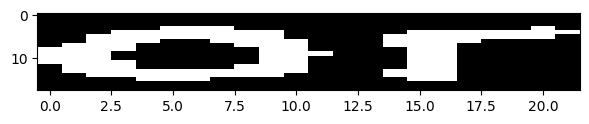

or
wordID 358
i 358


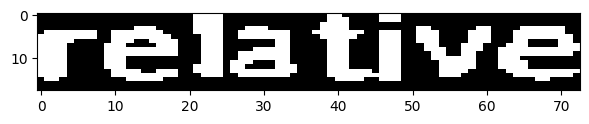

re1aUve
wordID 359
i 359


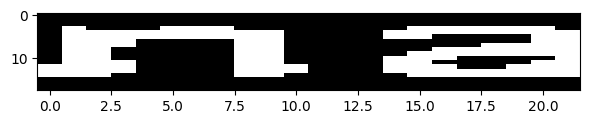

na
wordID 360
i 360


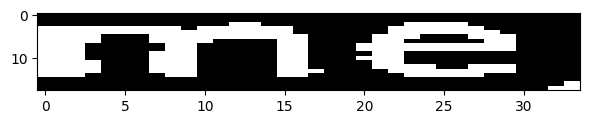

me
wordID 361
i 361


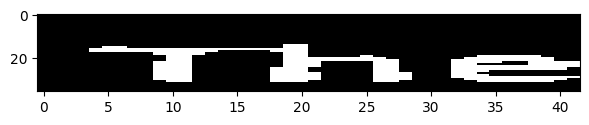

ne
wordID 362
i 362


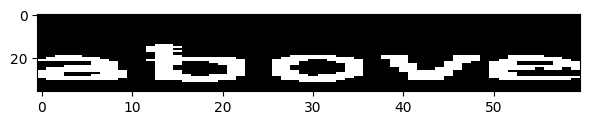

abcVe
wordID 363
i 363


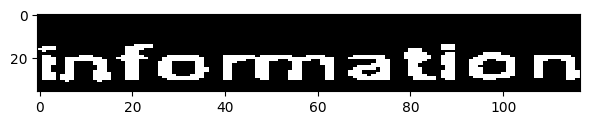

infOwaticn
wordID 364
i 364


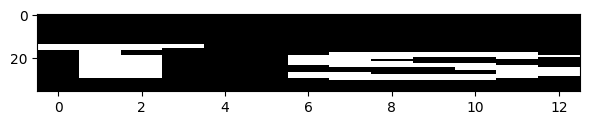

i5
wordID 365
i 365


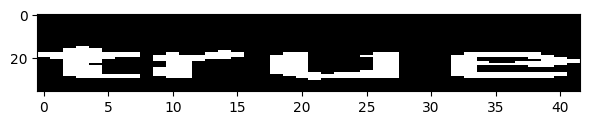

true
wordID 366
i 366


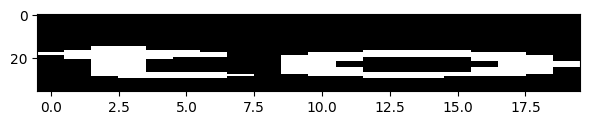

to
wordID 367
i 367


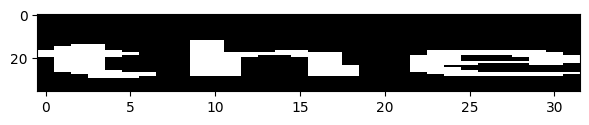

the
wordID 368
i 368


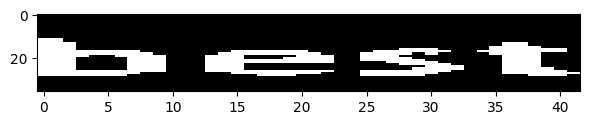

best
wordID 369
i 369


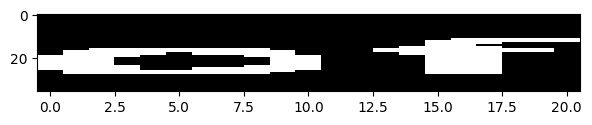

of
wordID 370
i 370


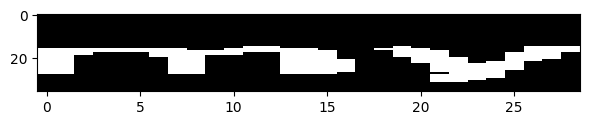

mY
wordID 371
i 371


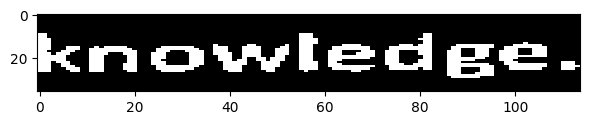

knOoledge
wordID 372
i 372


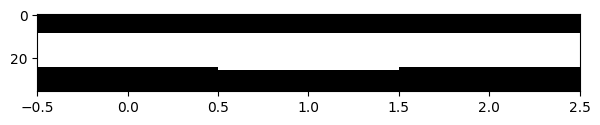

1
wordID 373
i 373


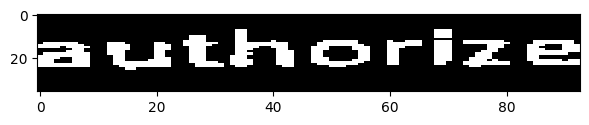

authorize
wordID 374
i 374


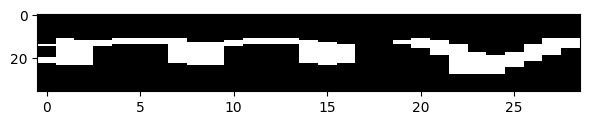

mY
wordID 375
i 375


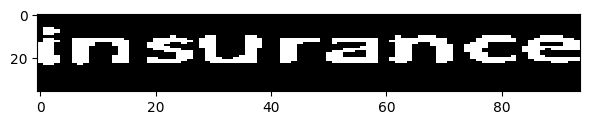

insurance
wordID 376
i 376


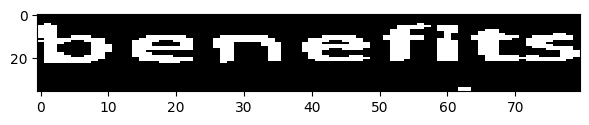

benefib
wordID 377
i 377


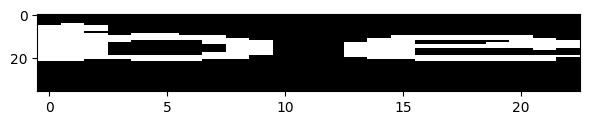

be
wordID 378
i 378


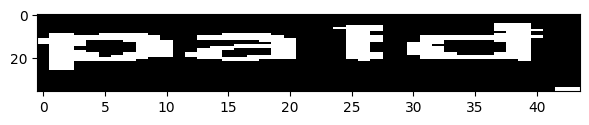

pa1d
wordID 379
i 379


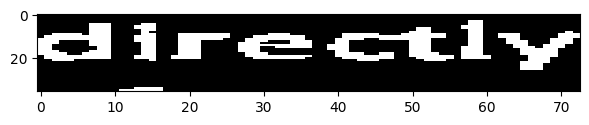

dlrejlY
wordID 380
i 380


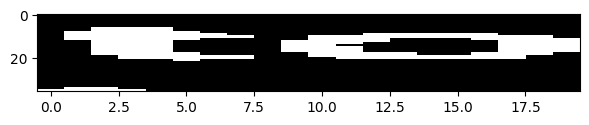

t
wordID 381
i 381


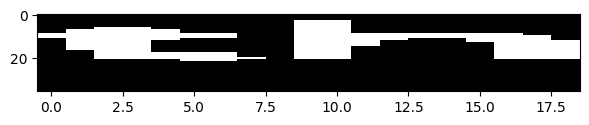

th
wordID 382
i 382


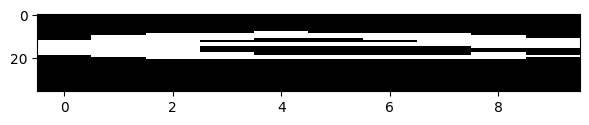

e
wordID 383
i 383


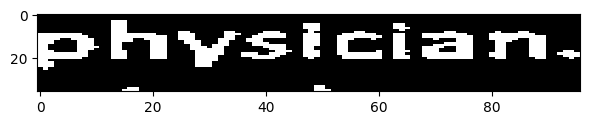

pyYstClan
wordID 384
i 384


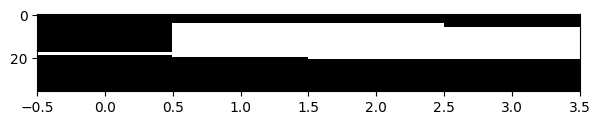

1
wordID 385
i 385


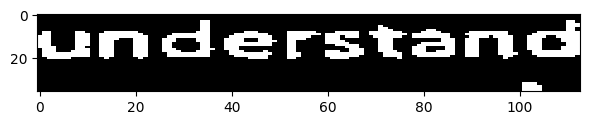

Understanp
wordID 386
i 386


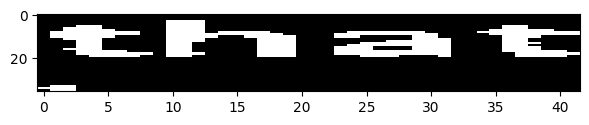

Zhat
wordID 387
i 387


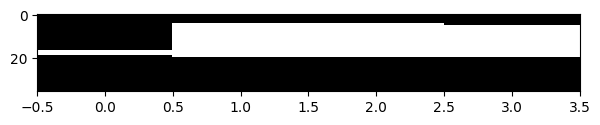

1
wordID 388
i 388


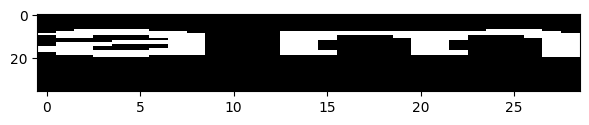

am
wordID 389
i 389


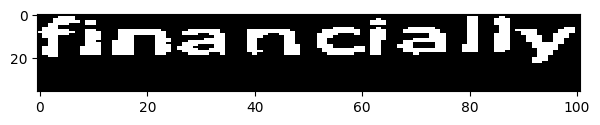

financfal1y
wordID 390
i 390


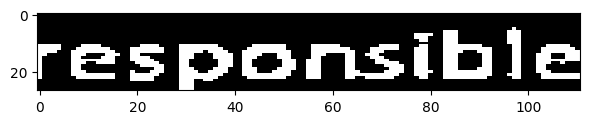

respOmib1e
wordID 391
i 391


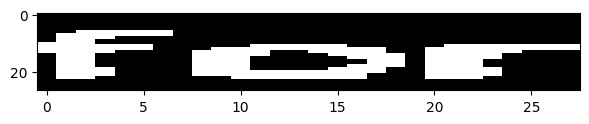

fOr
wordID 392
i 392


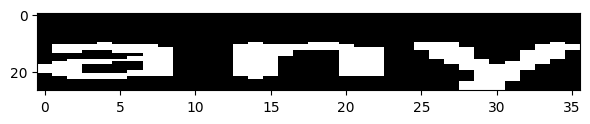

3nY
wordID 393
i 393


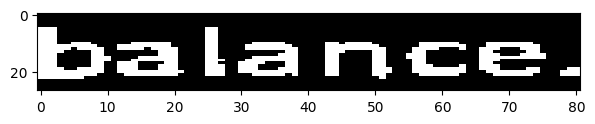

balance
wordID 394
i 394


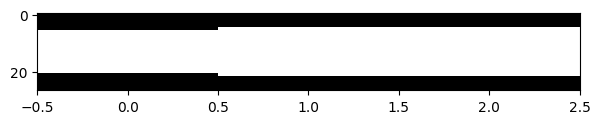

1
wordID 395
i 395


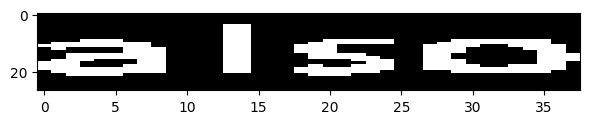

al5O
wordID 396
i 396


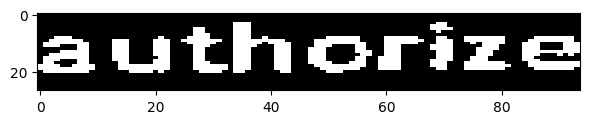

authorize
wordID 397
i 397


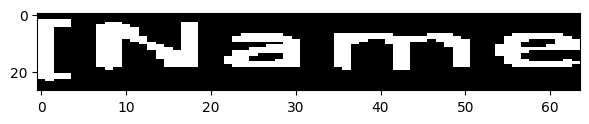

iName
wordID 398
i 398


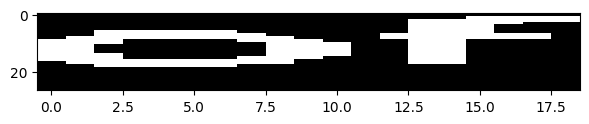

of
wordID 399
i 399


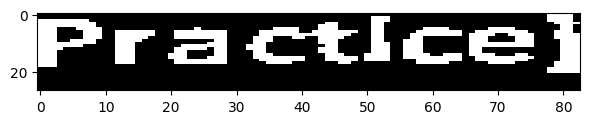

PraNice1
wordID 400
i 400


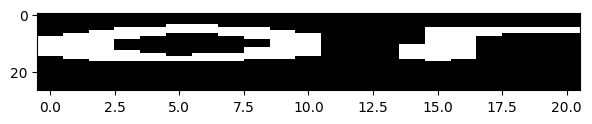

or
wordID 401
i 401


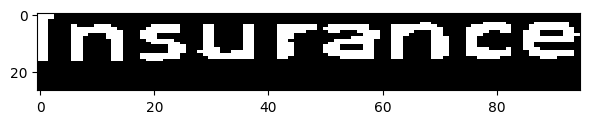

In5urance
wordID 402
i 402


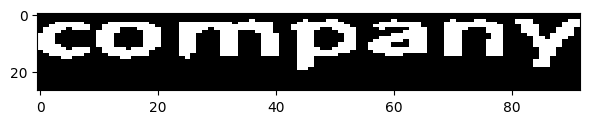

companY
wordID 403
i 403


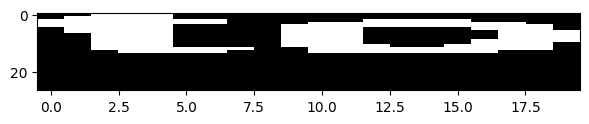

tO
wordID 404
i 404


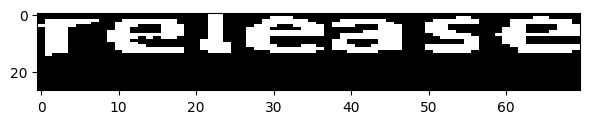

rele3se
wordID 405
i 405


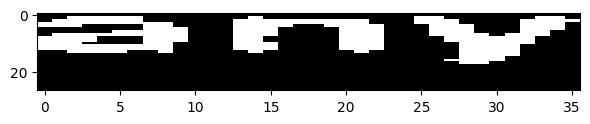

anY
wordID 406
i 406


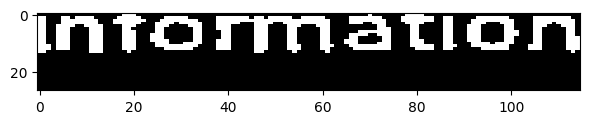

IntoPatlOn
wordID 407
i 407


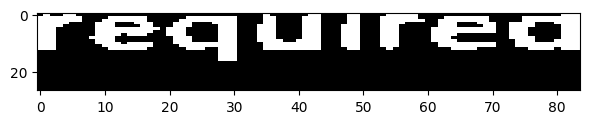

requirea
wordID 408
i 408


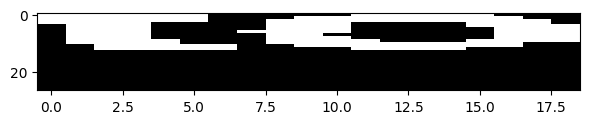

rO
wordID 409
i 409


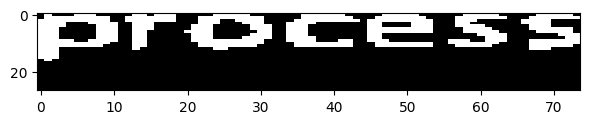

proCes5
wordID 410
i 410


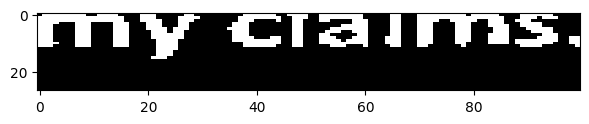

myGIaims
wordID 411
i 411


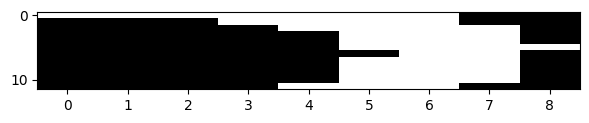

1
wordID 412
i 412


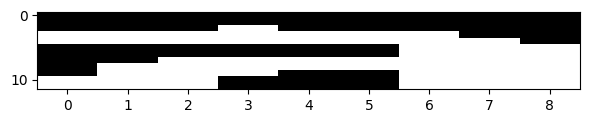

a
wordID 413
i 413


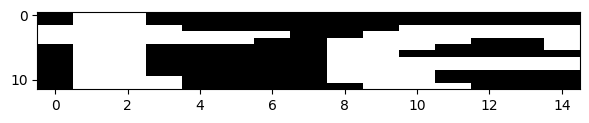

tG
wordID 414
i 414


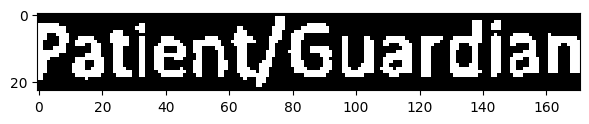

Pat1envGuardian
wordID 415
i 415


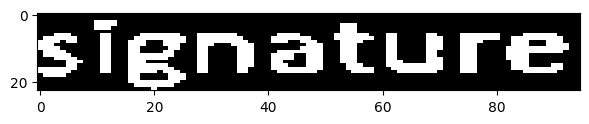

siinature
{0: 'name', 1: 'ot', 2: 'rracticel', 3: 'jzgisl', 4: 'ha', 5: 'l', 6: 'lun', 7: 'forl', 8: 'cpt', 9: 'ipl', 10: 'rodaws', 11: 'uate1', 12: 'rd3t1', 13: 'patier', 14: 'info', 15: 'rmanon', 16: 'narita1', 17: 'statusi', 18: 'lchoose', 19: 'an', 20: 'item', 21: 'patiencs', 22: '1ast', 23: 'namel', 24: '1ust', 25: 'nam', 26: 'iti', 27: 'ifirst', 28: 'namf', 29: 'dd1e1', 30: 'l1nit1al', 31: 'lcnoose', 32: 'an', 33: 'iteml', 34: 'binh', 35: 'cate', 36: 'f', 37: 'not', 38: 'what', 39: 'is', 40: 'vour', 41: 'lera1', 42: 'namei', 43: 'fo', 44: 'rmer', 45: 'n3me', 46: 'is', 47: 'this', 48: 'y2ur', 49: 'lera1', 50: 'name', 51: 'lbinhday1', 52: 'iformer', 53: 'name1', 54: 'i', 55: 'a', 56: '7a', 57: 'leral', 58: 'name', 59: 'ye5', 60: 'addren1', 61: 'laddre5sl', 62: 'po', 63: 'bdx', 64: 'ciwst', 65: 'zlp', 66: 'code', 67: 'cei1', 68: 'phone', 69: 'nc', 70: 'home', 71: 'phone', 72: 'no', 73: 'oaal', 74: '5ecuriw', 75: 'nc', 76: 'l', 77: 'p', 78: 'h', 79: 'o', 80: 'n', 81: 'e', 82: 'qj', 8

In [ ]:
startIndex = 0
endIndex = len(WordSegmentationsWithID)
foundWordsDict = {}
# for i in range(0, len(WordSegmentationsWithID)):
for i in range(startIndex, endIndex):
    image = None
    WordSegment = BinarizedImage[WordSegmentationsWithID[i][1]:WordSegmentationsWithID[i][2],WordSegmentationsWithID[i][3]:WordSegmentationsWithID[i][4]]
    wordID = WordSegmentationsWithID[i][0]
    print("wordID", wordID)
    print("i", i)

    CharacterCoordinatesArray = CharacterLocationDictionary[wordID]
    # print(CharacterCoordinatesArray)
    
    TopBoundaries = CharacterCoordinatesArray[:, 0]
    BottomBoundaries = CharacterCoordinatesArray[:, 1]
    LeftBoundaries = CharacterCoordinatesArray[:, 2]
    RightBoundaries = CharacterCoordinatesArray[:, 3]

    stringHolder = ""

    #Showing Word Segment:
    # print("wordID", wordID)
    plotLengthX = 7

    plt.rcParams['figure.figsize'] = [plotLengthX, 1]
    plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
    plt.show()

    # Print out individual cropped out characters: 
    for j in range(0, len(TopBoundaries)):
        croppedCharacter = WordSegment[TopBoundaries[j]:BottomBoundaries[j], LeftBoundaries[j]:RightBoundaries[j]] 

        # Find the longest dimension of cropped out character:
        # Note .shape returns (height, width)     
        maxDim = croppedCharacter.shape.index(max(croppedCharacter.shape))
        # print("shape", croppedCharacter.shape)

        height = croppedCharacter.shape[0]
        width = croppedCharacter.shape[1]
        # skip any images with a width of 0.
        # if (width == 0):
        #     continue
        aspectRatio = height/width
        # print("aspectRatio", aspectRatio)

        if (maxDim): #AKA if width is longer than height
            # print("width longer than height")
            margin = 4
            croppedCharacter = resize(croppedCharacter, (aspectRatio*28, 28-margin), order = 0, mode='constant', preserve_range = True)
            height = croppedCharacter.shape[0]
            width = croppedCharacter.shape[1]
            #Now pad black pixels on top and bottom sides:
            topPadding = np.zeros((((28-height)//2), 28-margin))
            bottomPadding = np.zeros((28-height-((28-height)//2), 28-margin))
            croppedCharacter = np.vstack((topPadding, croppedCharacter, bottomPadding))
            rightPad = np.zeros((28, margin//2))
            leftPad = np.zeros((28, margin//2))
            croppedCharacter = np.hstack((leftPad, croppedCharacter, rightPad))

        
        else: #AKA if height is longer than width
            # print("height longer than width")
            margin = 2
            croppedCharacter = resize(croppedCharacter, (28-margin, 28*(1/aspectRatio)), order = 0, mode='constant', preserve_range = True)
            height = croppedCharacter.shape[0]
            width = croppedCharacter.shape[1]
            #Now pad black pixels on left and right sides:
            rightPad = np.zeros((28-margin,(28-width)//2))
            leftPad = np.zeros((28-margin, 28-width-((28-width)//2)))
            croppedCharacter = np.hstack((leftPad, croppedCharacter, rightPad))
            topPadding = np.zeros((margin//2, 28))
            bottomPadding = np.zeros((margin//2, 28))
            croppedCharacter = np.vstack((topPadding, croppedCharacter, bottomPadding))


        y_pred = model.predict(croppedCharacter.reshape(1, 28, 28), verbose=0)

        # plt.rcParams['figure.figsize'] = [1, 1]
        # plt.imshow(croppedCharacter, cmap = 'gray', interpolation='none')
        # print(croppedCharacter.shape) 
        # plt.show() 
        # print(alphabetSet[y_pred.argmax()])

        stringHolder += alphabetSet[y_pred.argmax()]
    print(stringHolder)
    foundWordsDict[wordID] = stringHolder.lower()
    # foundWordsList.append(stringHolder.lower())

print(foundWordsDict)


Language Detection

In [ ]:
numOfLanguages = len(AvailableDictionariesNames)
languageCounter = np.zeros(numOfLanguages)

for i in range(numOfLanguages):
    languageDictionary = AvailableDictionaries[i]
    for word in foundWordsDict.values():
        if word in languageDictionary:
            languageCounter[i] += 1

print("Total words =", len(foundWordsDict))
print(AvailableDictionariesNames)
print(languageCounter)

detectedDictionaryName = AvailableDictionariesNames[np.argmax(languageCounter)]
detectedDictionary = AvailableDictionaries[np.argmax(languageCounter)]
print(detectedDictionaryName, "detected")



if detectedDictionaryName == "engDictionary":
    spellCheckerAlphabetPath = r".\SpellChecker\english_lowercase_spellchecker.txt"

elif detectedDictionaryName == "indoDictionary":
    spellCheckerAlphabetPath = r".\SpellChecker\indonesian_lowercase_spellchecker.txt"

elif detectedDictionaryName == "bulDictionary":
    spellCheckerAlphabetPath = r".\SpellChecker\bulgarian_lowercase_spellchecker.txt"

elif detectedDictionaryName == "belDictionary":
    spellCheckerAlphabetPath = r".\SpellChecker\belarusian_lowercase_spellchecker.txt"
    

fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1) 
plt.cla()
plt.rcParams['figure.figsize'] = [4, 4]
bars  = plt.bar(["Latin", "Cyrillic", "Greek"], [LatinCounter, CyrillicCounter, GreekCounter], color ='maroon',
    width = 0.4)

Total words = 416
['engDictionary', 'indoDictionary', 'dutchDictionary', 'spanishDictionary']
[225. 174. 210. 202.]
engDictionary detected


Detect spelling errors

In [ ]:
spellingErrorsDict = {word:foundWordsDict[word] for word in foundWordsDict.keys() if foundWordsDict[word] not in detectedDictionary}

print(spellingErrorsDict)
print(len(spellingErrorsDict))

{2: 'rracticel', 3: 'jzgisl', 6: 'lun', 7: 'forl', 10: 'rodaws', 11: 'uate1', 12: 'rd3t1', 13: 'patier', 15: 'rmanon', 16: 'narita1', 17: 'statusi', 18: 'lchoose', 21: 'patiencs', 22: '1ast', 23: 'namel', 24: '1ust', 26: 'iti', 27: 'ifirst', 28: 'namf', 29: 'dd1e1', 30: 'l1nit1al', 31: 'lcnoose', 33: 'iteml', 40: 'vour', 41: 'lera1', 42: 'namei', 44: 'rmer', 45: 'n3me', 48: 'y2ur', 49: 'lera1', 51: 'lbinhday1', 52: 'iformer', 53: 'name1', 56: '7a', 57: 'leral', 59: 'ye5', 60: 'addren1', 61: 'laddre5sl', 63: 'bdx', 64: 'ciwst', 65: 'zlp', 67: 'cei1', 69: 'nc', 73: 'oaal', 74: '5ecuriw', 75: 'nc', 82: 'qj', 83: 'i55x', 84: 'lpho', 85: 'nel', 100: 'oye', 102: 'oq', 109: 'iocndation1', 119: 'clinlc', 120: 'beuuselreferred', 122: 'clinlc', 124: 'lp1ease', 127: 'option11', 128: 'pdoctocs', 129: 'namel', 130: 'ichoose', 132: 'item1', 134: 'f3mlly', 137: 'herei', 138: 'iother', 139: 'vatienu1', 141: '1nformat1o', 143: 'rip1ease', 146: 'insu', 147: 'mnce', 148: 'ard', 150: '0e', 151: 'reception

Fix Spelling Errors

In [ ]:
import SpellChecker.SpellChecker as sp

file = open(spellCheckerAlphabetPath, "r", encoding='utf-8')
spellCheckerAlphabet = file.read().splitlines()

spellCheckerObj = sp.SpellChecker(spellCheckerAlphabet, detectedDictionary)
corrections = {w:spellCheckerObj.correctSpelling(spellingErrorsDict[w]) for w in spellingErrorsDict.keys()}

print(spellingErrorsDict)
print("")
print(corrections)


{2: 'rracticel', 3: 'jzgisl', 6: 'lun', 7: 'forl', 10: 'rodaws', 11: 'uate1', 12: 'rd3t1', 13: 'patier', 15: 'rmanon', 16: 'narita1', 17: 'statusi', 18: 'lchoose', 21: 'patiencs', 22: '1ast', 23: 'namel', 24: '1ust', 26: 'iti', 27: 'ifirst', 28: 'namf', 29: 'dd1e1', 30: 'l1nit1al', 31: 'lcnoose', 33: 'iteml', 40: 'vour', 41: 'lera1', 42: 'namei', 44: 'rmer', 45: 'n3me', 48: 'y2ur', 49: 'lera1', 51: 'lbinhday1', 52: 'iformer', 53: 'name1', 56: '7a', 57: 'leral', 59: 'ye5', 60: 'addren1', 61: 'laddre5sl', 63: 'bdx', 64: 'ciwst', 65: 'zlp', 67: 'cei1', 69: 'nc', 73: 'oaal', 74: '5ecuriw', 75: 'nc', 82: 'qj', 83: 'i55x', 84: 'lpho', 85: 'nel', 100: 'oye', 102: 'oq', 109: 'iocndation1', 119: 'clinlc', 120: 'beuuselreferred', 122: 'clinlc', 124: 'lp1ease', 127: 'option11', 128: 'pdoctocs', 129: 'namel', 130: 'ichoose', 132: 'item1', 134: 'f3mlly', 137: 'herei', 138: 'iother', 139: 'vatienu1', 141: '1nformat1o', 143: 'rip1ease', 146: 'insu', 147: 'mnce', 148: 'ard', 150: '0e', 151: 'reception

Display Spelling Errors

2
wordID 2


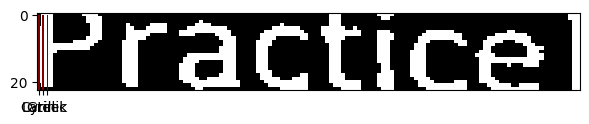

rracticel
practice
3
wordID 3


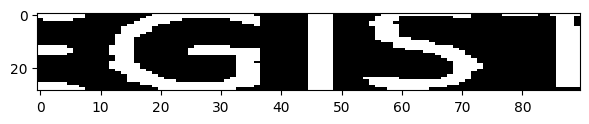

jzgisl
jzgisl
6
wordID 6


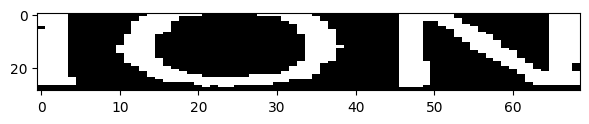

lun
sun
7
wordID 7


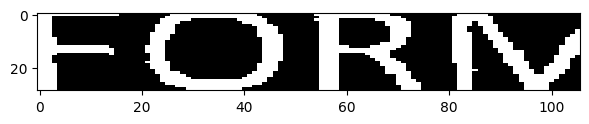

forl
for
10
wordID 10


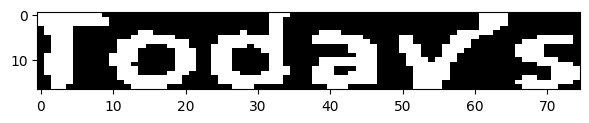

rodaws
roads
11
wordID 11


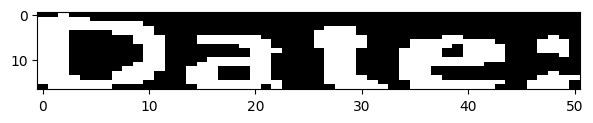

uate1
date
12
wordID 12


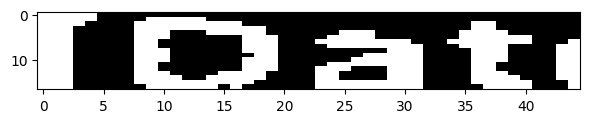

rd3t1
rd3t1
13
wordID 13


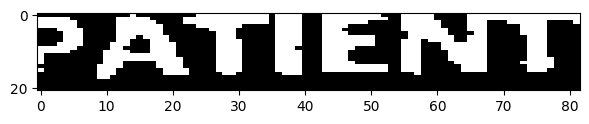

patier
papier
15
wordID 15


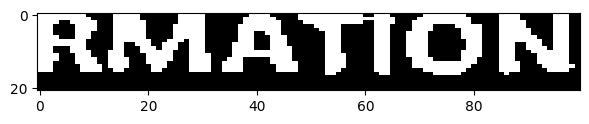

rmanon
reason
16
wordID 16


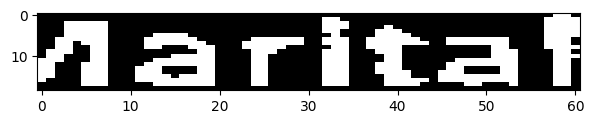

narita1
marital
17
wordID 17


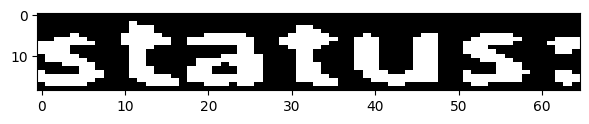

statusi
status
18
wordID 18


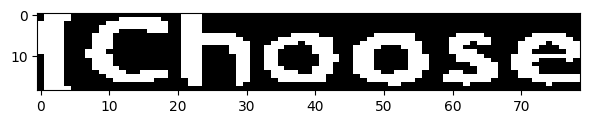

lchoose
choose
21
wordID 21


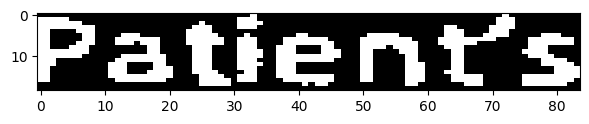

patiencs
patients
22
wordID 22


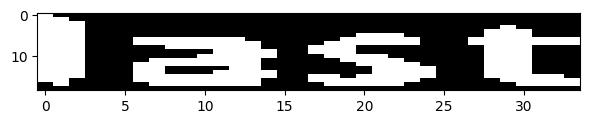

1ast
last
23
wordID 23


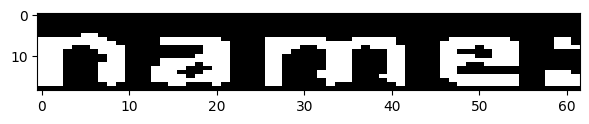

namel
name
24
wordID 24


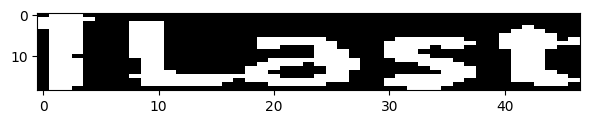

1ust
just
26
wordID 26


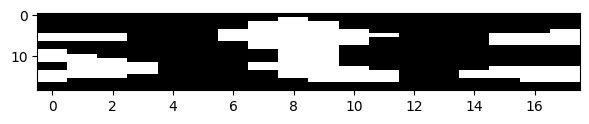

iti
it
27
wordID 27


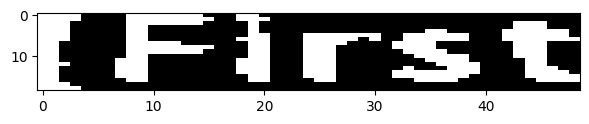

ifirst
first
28
wordID 28


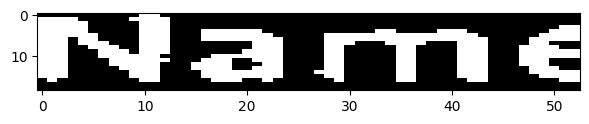

namf
name
29
wordID 29


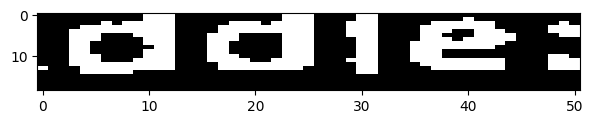

dd1e1
dd1e1
30
wordID 30


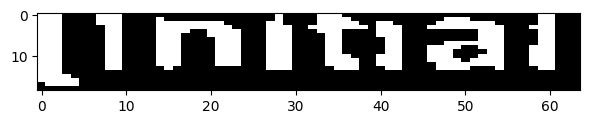

l1nit1al
lanital
31
wordID 31


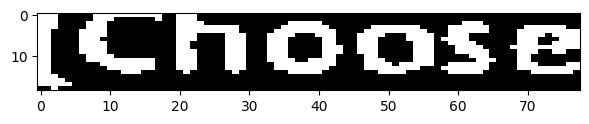

lcnoose
choose
33
wordID 33


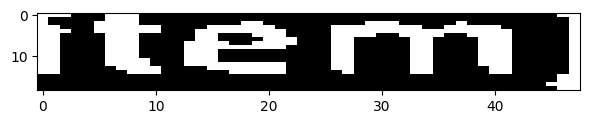

iteml
items
40
wordID 40


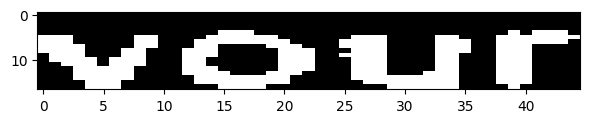

vour
your
41
wordID 41


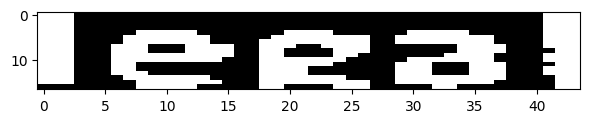

lera1
learn
42
wordID 42


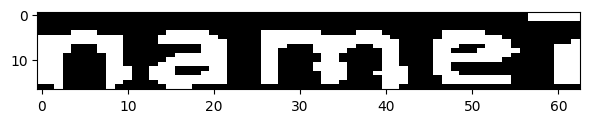

namei
name
44
wordID 44


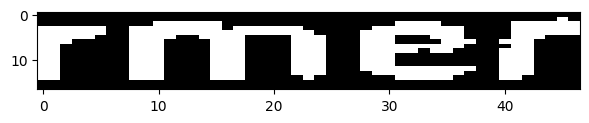

rmer
mer
45
wordID 45


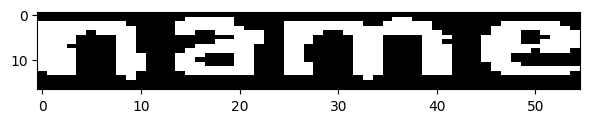

n3me
name
48
wordID 48


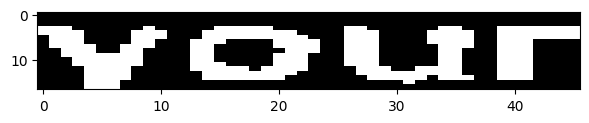

y2ur
your
49
wordID 49


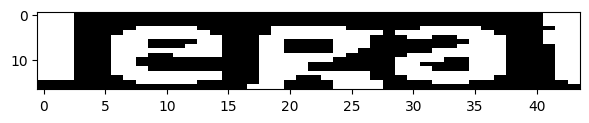

lera1
learn
51
wordID 51


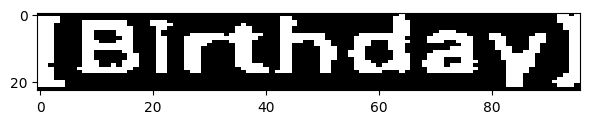

lbinhday1
lbinhday1
52
wordID 52


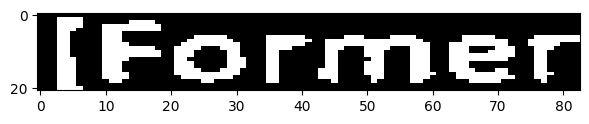

iformer
former
53
wordID 53


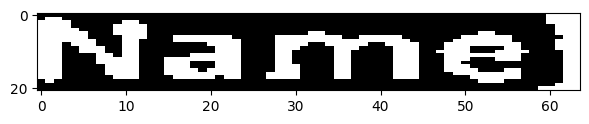

name1
name
56
wordID 56


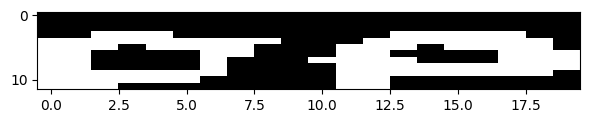

7a
a
57
wordID 57


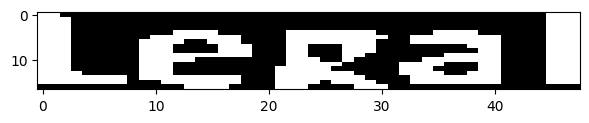

leral
legal
59
wordID 59


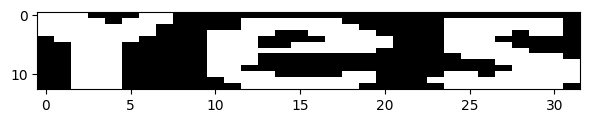

ye5
yes
60
wordID 60


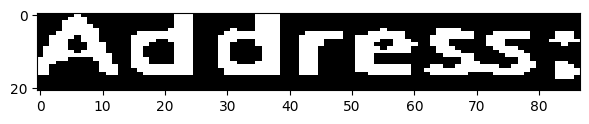

addren1
address
61
wordID 61


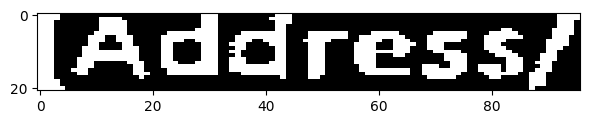

laddre5sl
laddre5sl
63
wordID 63


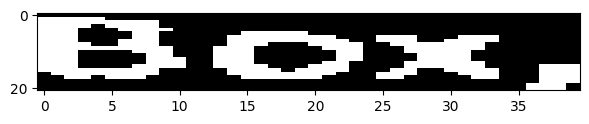

bdx
box
64
wordID 64


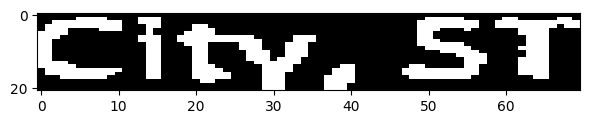

ciwst
cist
65
wordID 65


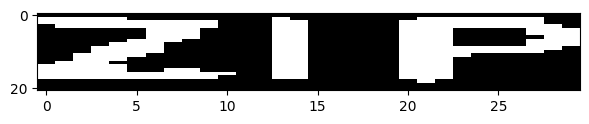

zlp
zip
67
wordID 67


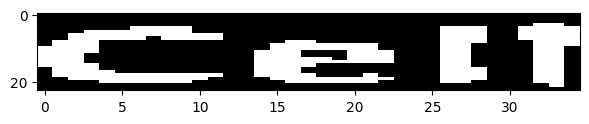

cei1
ceil
69
wordID 69


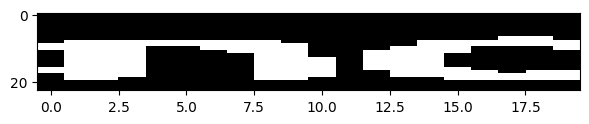

nc
no
73
wordID 73


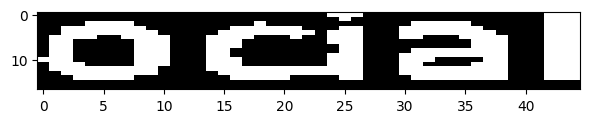

oaal
oral
74
wordID 74


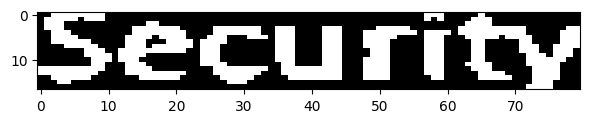

5ecuriw
ecurie
75
wordID 75


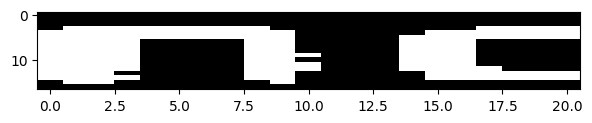

nc
no
82
wordID 82


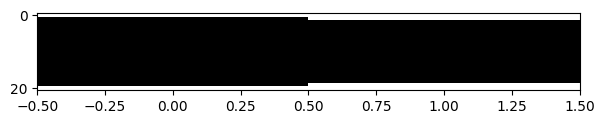

qj
j
83
wordID 83


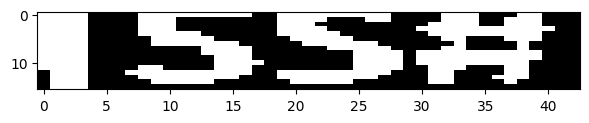

i55x
ix
84
wordID 84


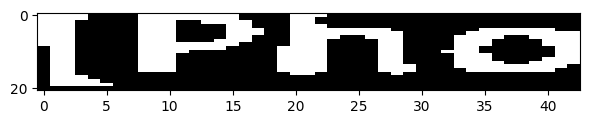

lpho
pho
85
wordID 85


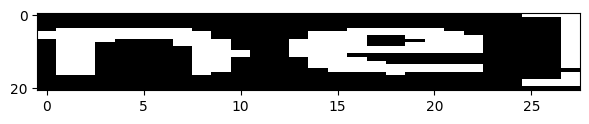

nel
new
100
wordID 100


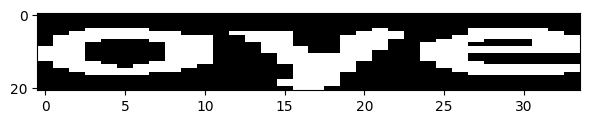

oye
one
102
wordID 102


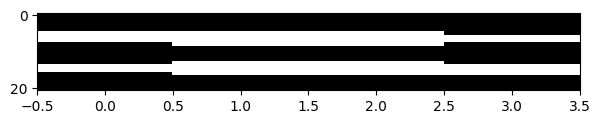

oq
of
109
wordID 109


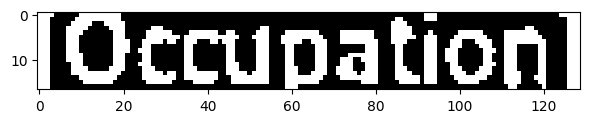

iocndation1
iocndation1
119
wordID 119


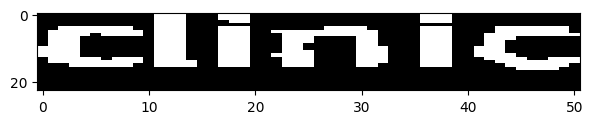

clinlc
clinic
120
wordID 120


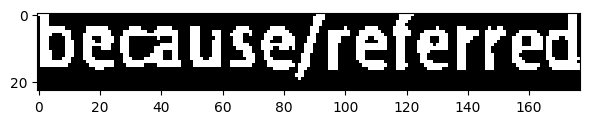

beuuselreferred
beuuselreferred
122
wordID 122


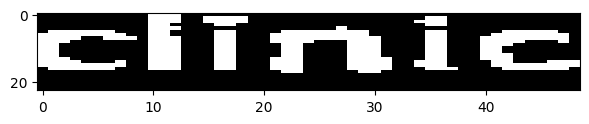

clinlc
clinic
124
wordID 124


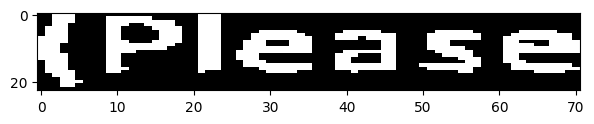

lp1ease
please
127
wordID 127


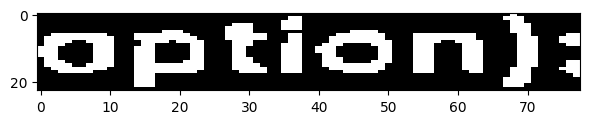

option11
options
128
wordID 128


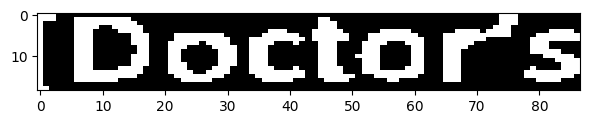

pdoctocs
doctors
129
wordID 129


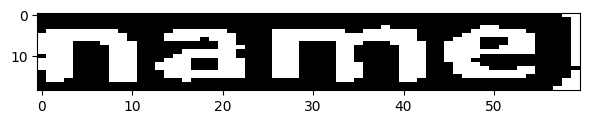

namel
name
130
wordID 130


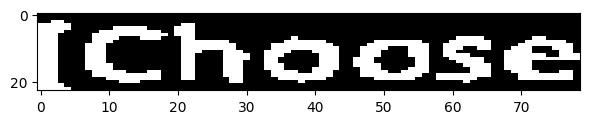

ichoose
choose
132
wordID 132


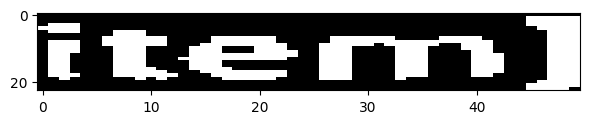

item1
items
134
wordID 134


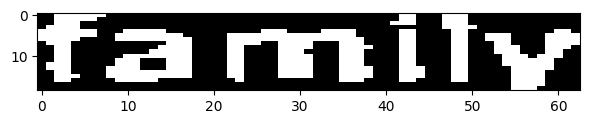

f3mlly
family
137
wordID 137


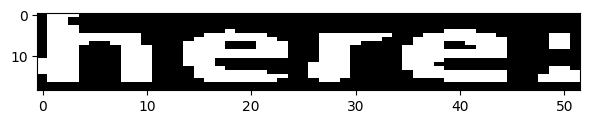

herei
here
138
wordID 138


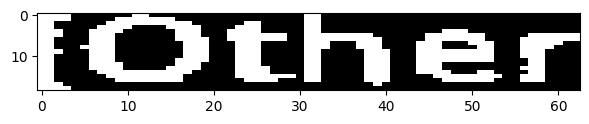

iother
other
139
wordID 139


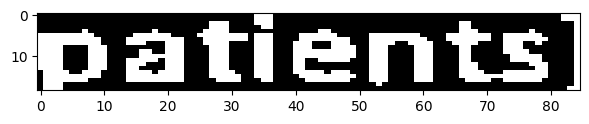

vatienu1
vatienu1
141
wordID 141


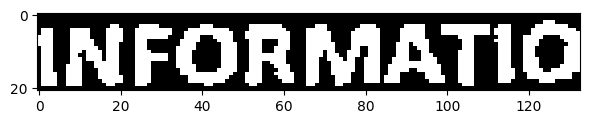

1nformat1o
1nformat1o
143
wordID 143


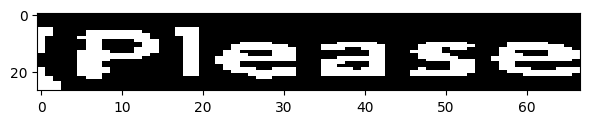

rip1ease
rip1ease
146
wordID 146


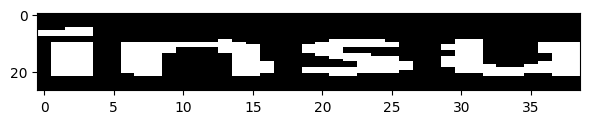

insu
ins
147
wordID 147


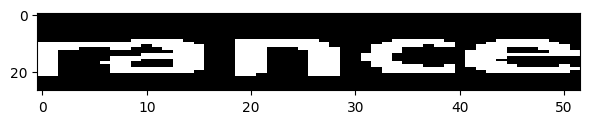

mnce
once
148
wordID 148


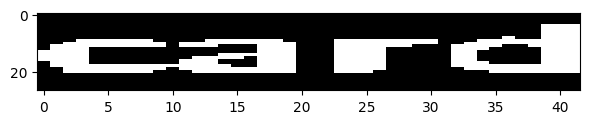

ard
and
150
wordID 150


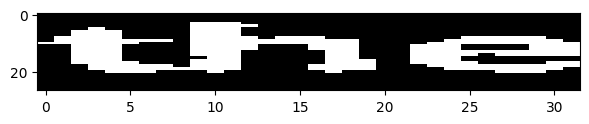

0e
be
151
wordID 151


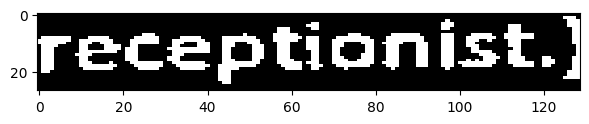

receptionist1
receptionist
152
wordID 152


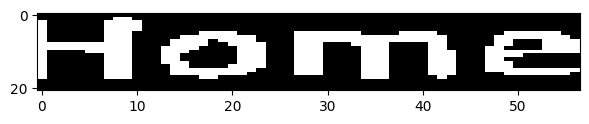

4ome
home
156
wordID 156


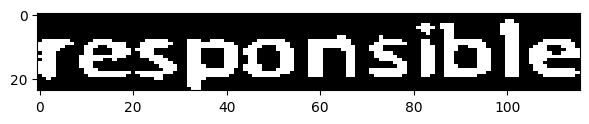

responsib1e
responsible
158
wordID 158


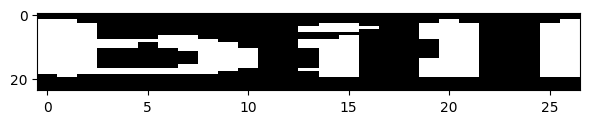

bi1l
bill
162
wordID 162


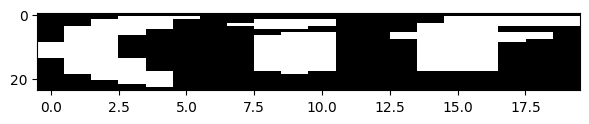

f1f
ff
163
wordID 163


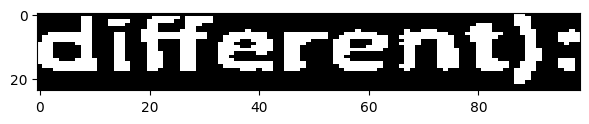

digerent1r
digerent
173
wordID 173


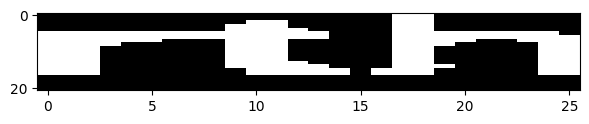

nh
no
176
wordID 176


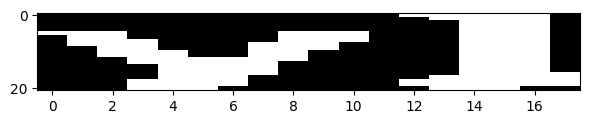

yj
y
179
wordID 179


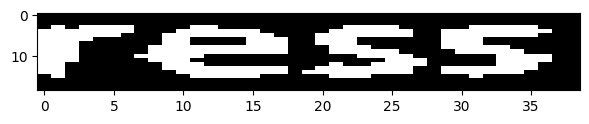

ress
press
180
wordID 180


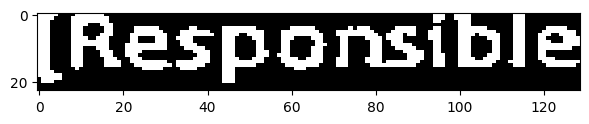

lrespomib1e
lrespomib1e
181
wordID 181


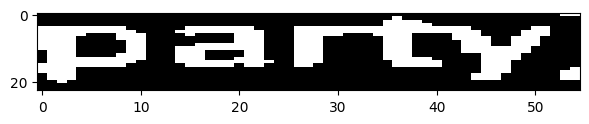

pami
pam
184
wordID 184


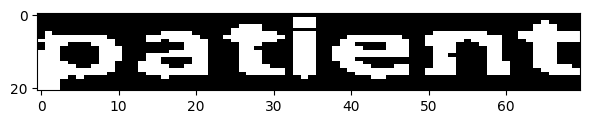

pat1ent
patient
187
wordID 187


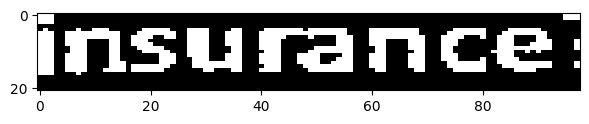

insuqngei
insuqngei
191
wordID 191


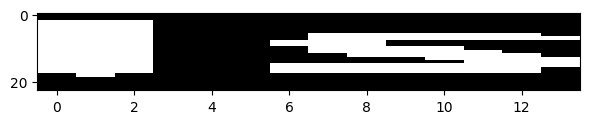

1s
is
193
wordID 193


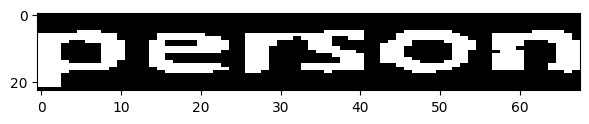

penon
xenon
196
wordID 196


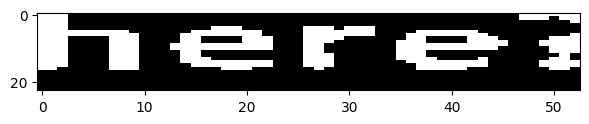

herei
here
197
wordID 197


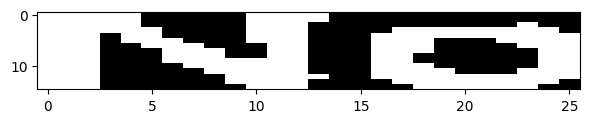

nc
no
200
wordID 200


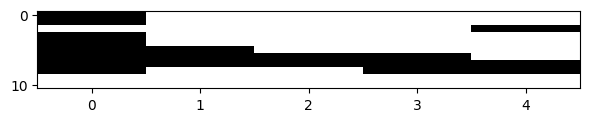

1
a
201
wordID 201


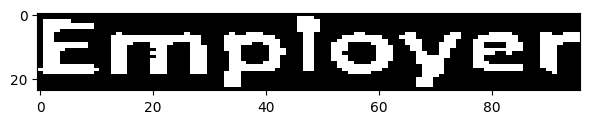

emp1oyer
employer
205
wordID 205


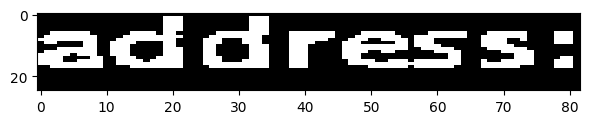

addrcsi
address
206
wordID 206


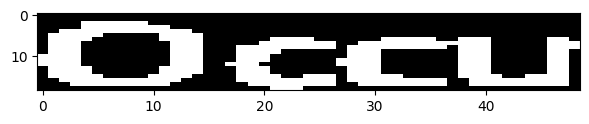

ocn
on
207
wordID 207


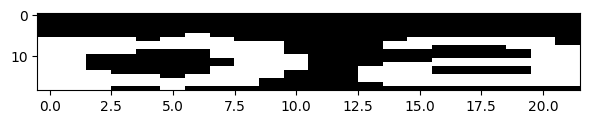

oa
of
208
wordID 208


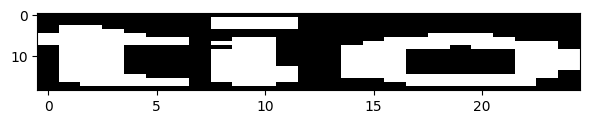

tio
to
215
wordID 215


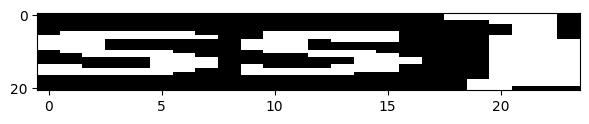

ssj
ss
217
wordID 217


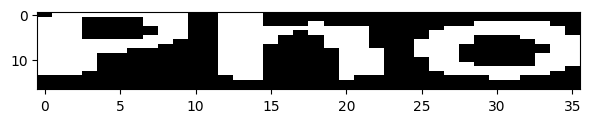

pno
no
218
wordID 218


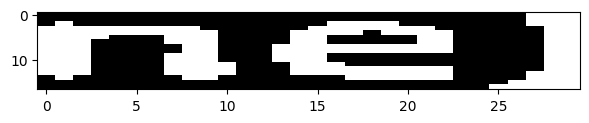

ne1
new
223
wordID 223


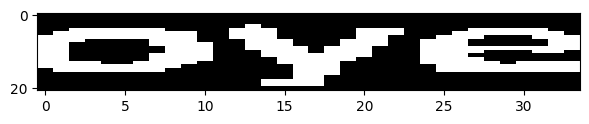

oye
one
224
wordID 224


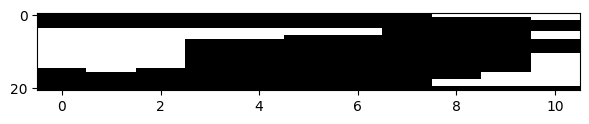

ri
i
233
wordID 233


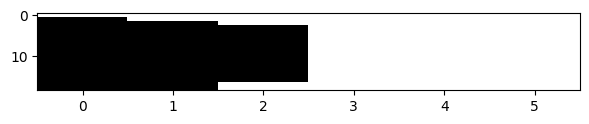

1
a
234
wordID 234


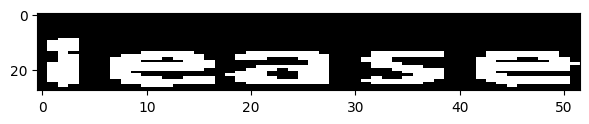

iease
lease
235
wordID 235


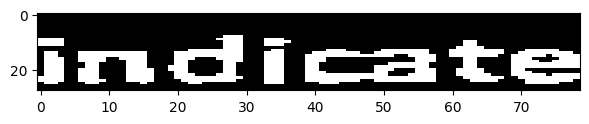

indiute
indite
236
wordID 236


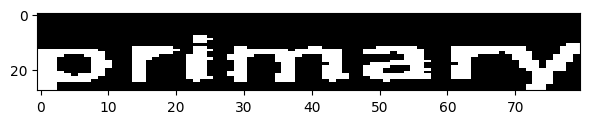

priman
prima
237
wordID 237


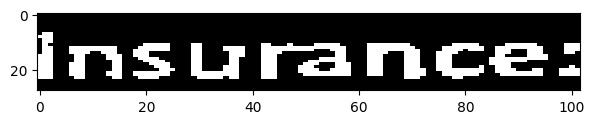

insumncei
insumncei
238
wordID 238


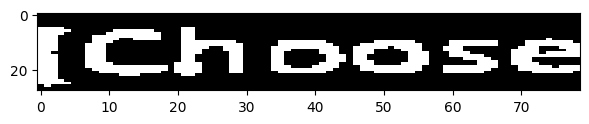

lchdo5e
lchdo5e
240
wordID 240


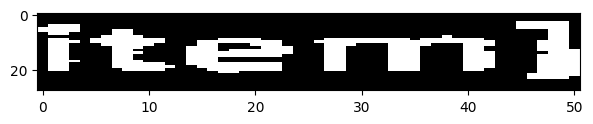

item1
items
242
wordID 242


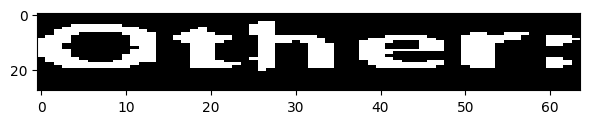

otherr
other
243
wordID 243


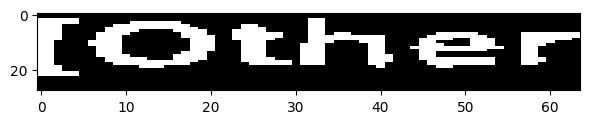

lother
other
244
wordID 244


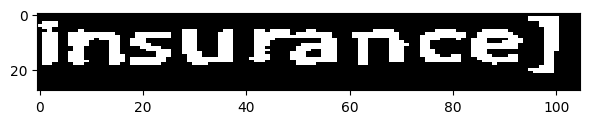

1nsumnce1
1nsumnce1
246
wordID 246


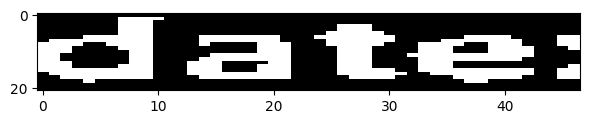

datei
date
249
wordID 249


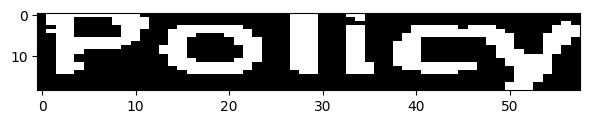

poliq
polio
250
wordID 250


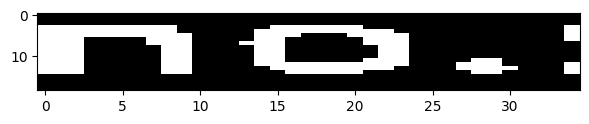

no1
not
259
wordID 259


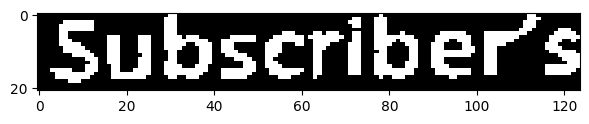

subscribecs
subscribers
263
wordID 263


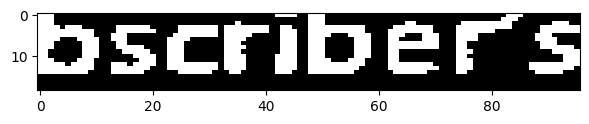

bscrjbers
scribers
264
wordID 264


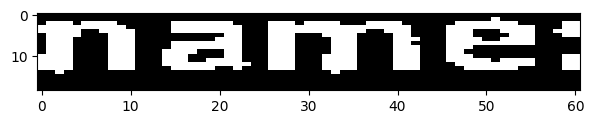

name1
name
265
wordID 265


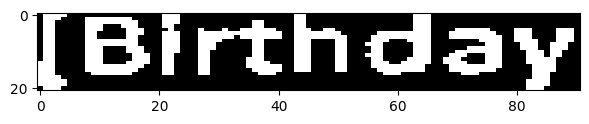

lbinhday
linhay
266
wordID 266


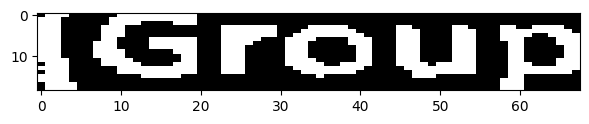

lgroup
group
268
wordID 268


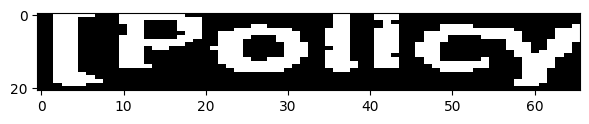

lpoliy
policy
276
wordID 276


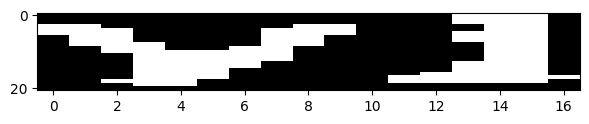

yl
l
277
wordID 277


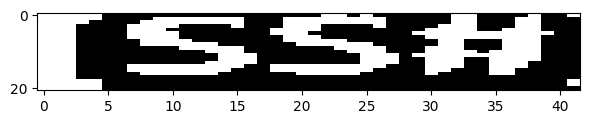

lssnj
assn
278
wordID 278


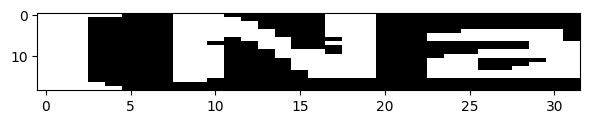

lna
la
280
wordID 280


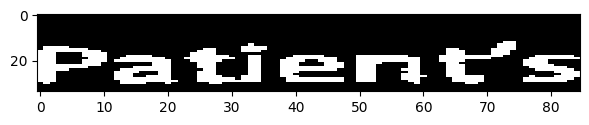

pacencs
parents
281
wordID 281


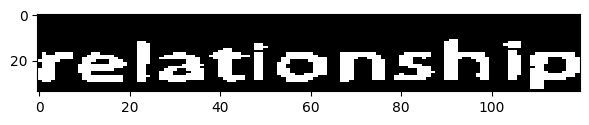

re1ationship
relationship
283
wordID 283


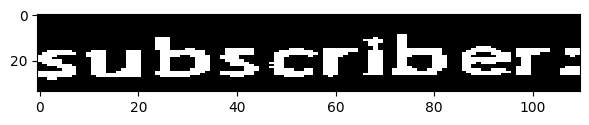

subscr1beri
subscriber
284
wordID 284


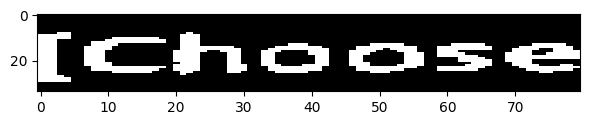

ichoose
choose
286
wordID 286


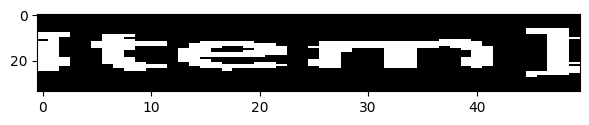

itemj
items
288
wordID 288


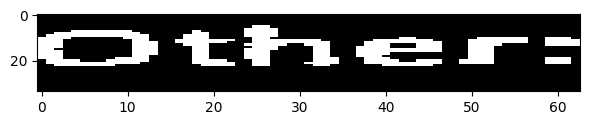

otherr
other
289
wordID 289


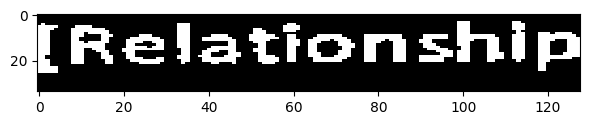

lre1ationship
relationship
291
wordID 291


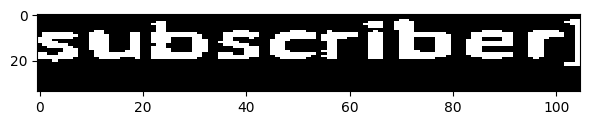

5ubscriberl
subscriber
292
wordID 292


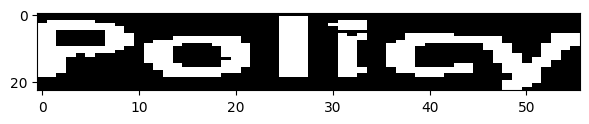

pollw
poll
295
wordID 295


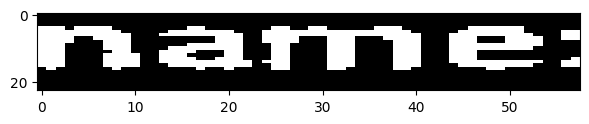

name1
name
296
wordID 296


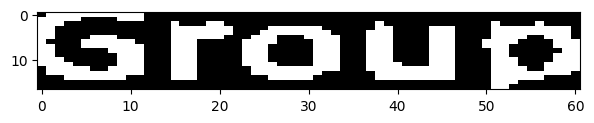

groun
group
300
wordID 300


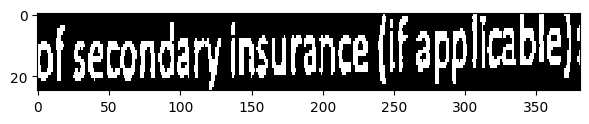

of5emndaainsurancellfapp1i4bleji
of5emndaainsurancellfapp1i4bleji
301
wordID 301


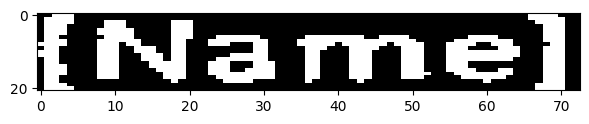

iname1
name
302
wordID 302


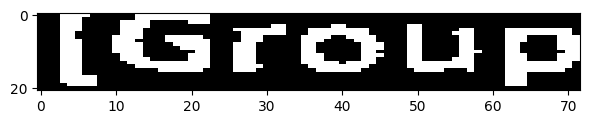

lgroup
group
304
wordID 304


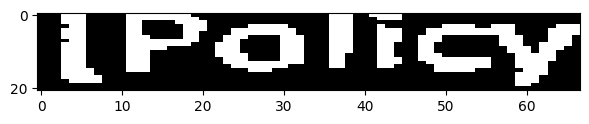

lpo1iq
lpo1iq
306
wordID 306


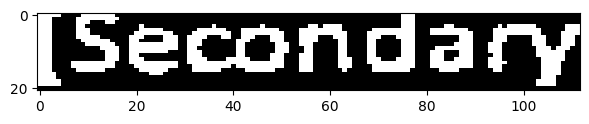

lsenndat
lsenndat
307
wordID 307


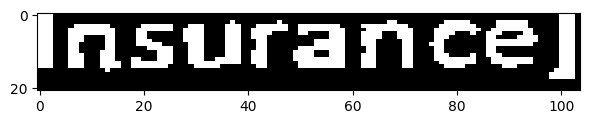

lnsurance1
insurance
308
wordID 308


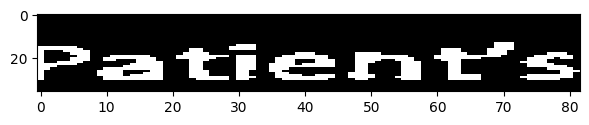

patienfs
patients
309
wordID 309


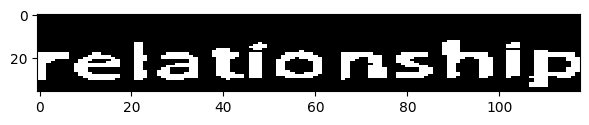

relatioaship
relationship
311
wordID 311


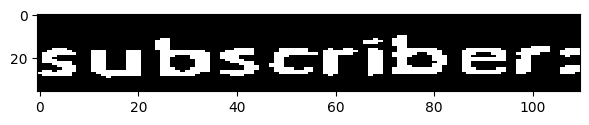

subscriberi
subscriber
312
wordID 312


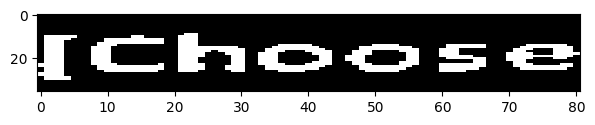

lchoo5e
choose
314
wordID 314


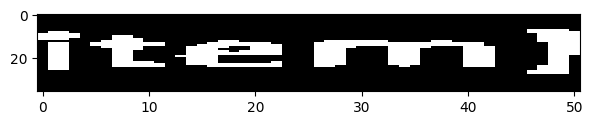

item1
items
316
wordID 316


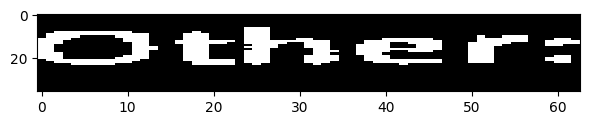

otherr
other
317
wordID 317


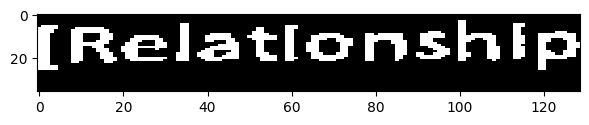

lrel3tionship
relationship
319
wordID 319


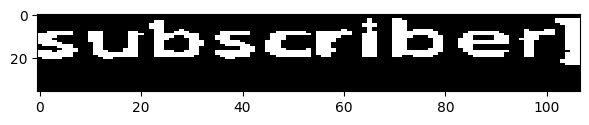

sub5criber1
subscriber
321
wordID 321


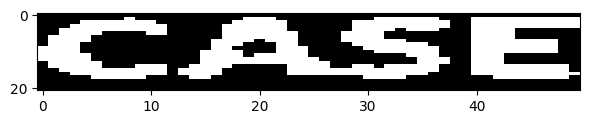

cme
me
323
wordID 323


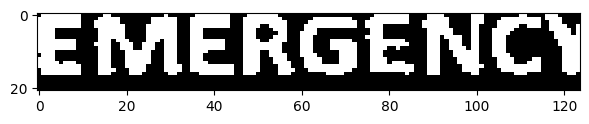

emergencn
emergency
324
wordID 324


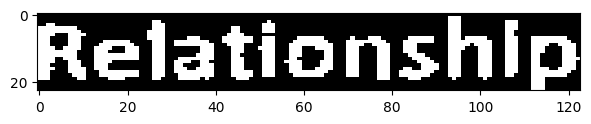

re1ationship
relationship
326
wordID 326


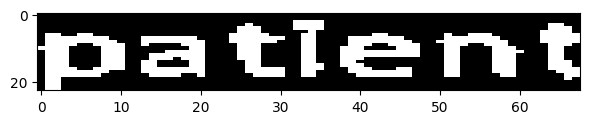

pat1ent
patient
328
wordID 328


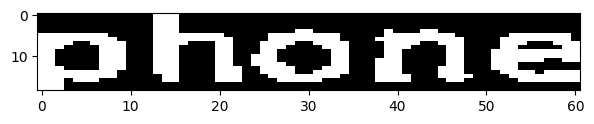

phcne
phone
335
wordID 335


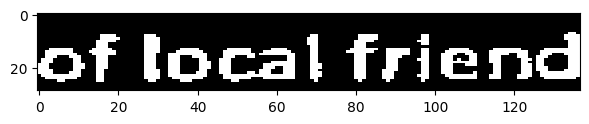

oflou1fr1end
oflou1fr1end
337
wordID 337


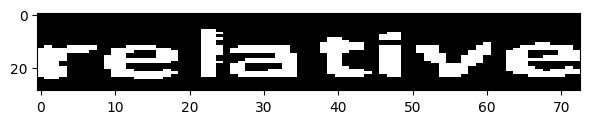

re1ative
relative
338
wordID 338


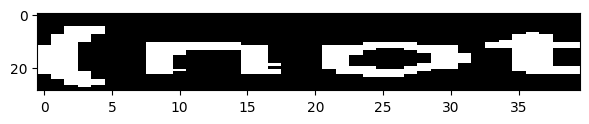

lnot
not
339
wordID 339


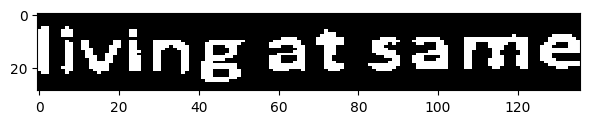

11vingatsame
11vingatsame
340
wordID 340


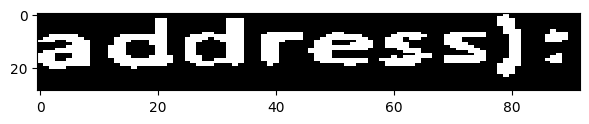

address1t
address
341
wordID 341


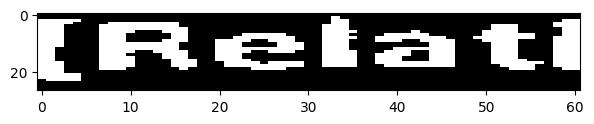

lrelati
relate
346
wordID 346


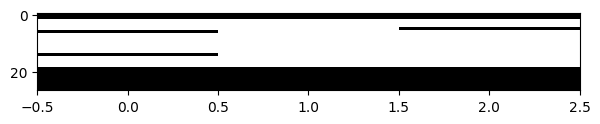

1
a
347
wordID 347


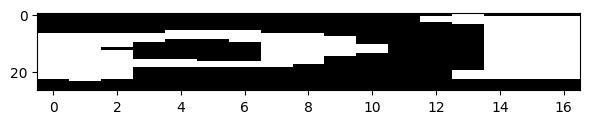

p1
pm
348
wordID 348


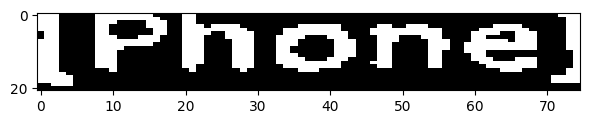

lphonel
phone
358
wordID 358


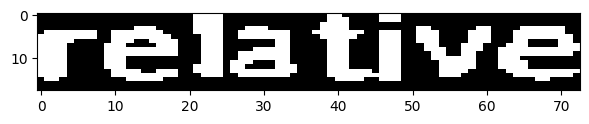

re1auve
resave
362
wordID 362


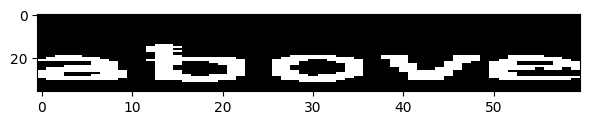

abcve
above
363
wordID 363


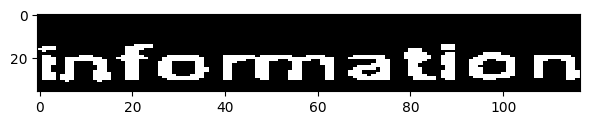

infowaticn
infowaticn
364
wordID 364


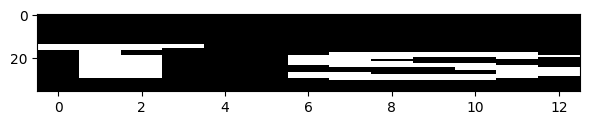

i5
in
371
wordID 371


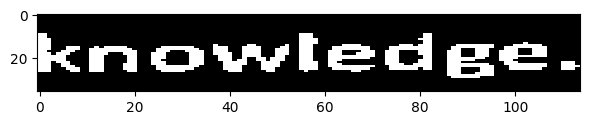

knooledge
knowledge
372
wordID 372


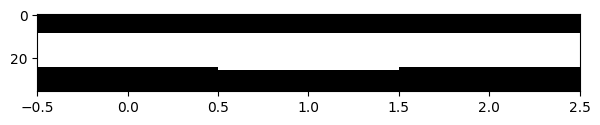

1
a
376
wordID 376


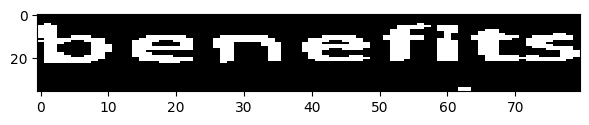

benefib
benefit
378
wordID 378


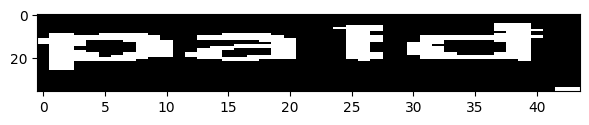

pa1d
paid
379
wordID 379


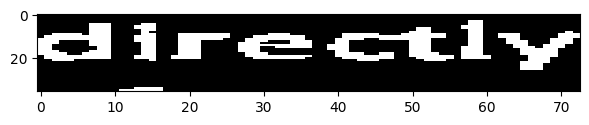

dlrejly
direcly
383
wordID 383


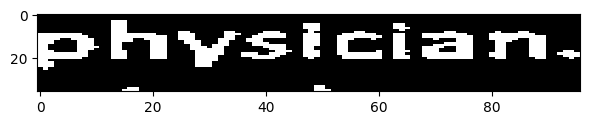

pyystclan
pyystclan
384
wordID 384


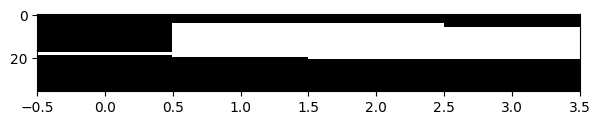

1
a
385
wordID 385


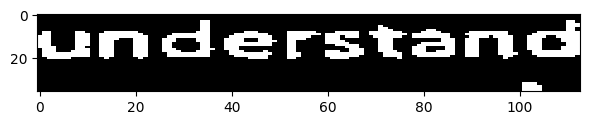

understanp
understand
386
wordID 386


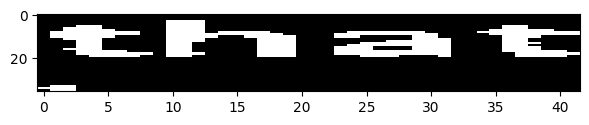

zhat
that
387
wordID 387


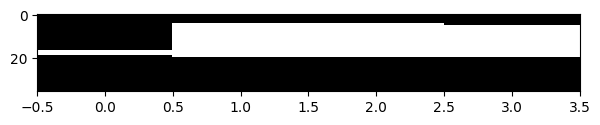

1
a
389
wordID 389


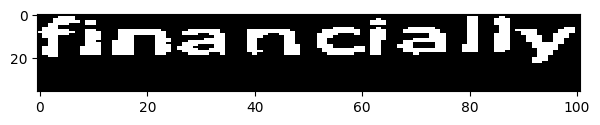

financfal1y
financially
390
wordID 390


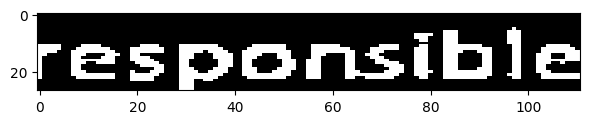

respomib1e
respomib1e
392
wordID 392


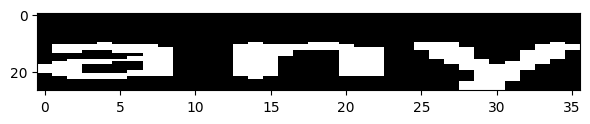

3ny
any
394
wordID 394


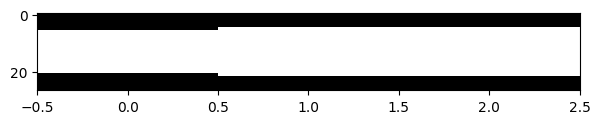

1
a
395
wordID 395


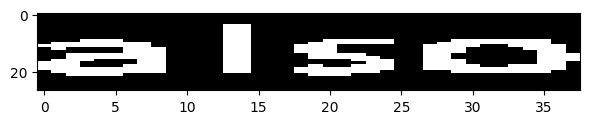

al5o
also
397
wordID 397


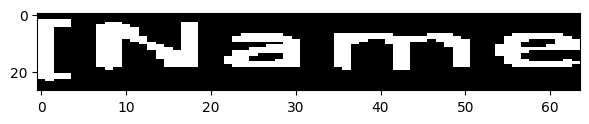

iname
name
399
wordID 399


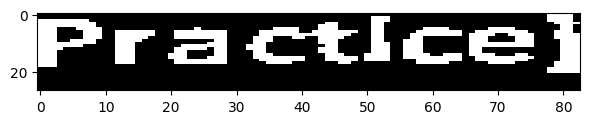

pranice1
prance
401
wordID 401


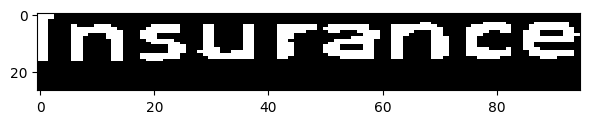

in5urance
insurance
404
wordID 404


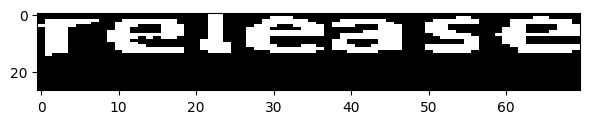

rele3se
release
406
wordID 406


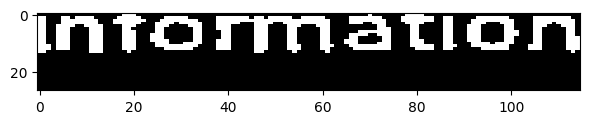

intopatlon
intonation
407
wordID 407


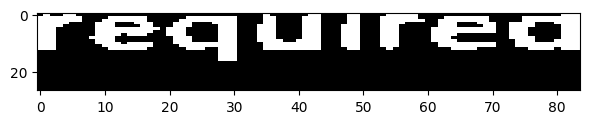

requirea
required
409
wordID 409


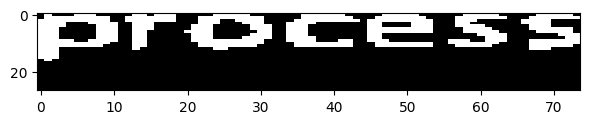

proces5
process
410
wordID 410


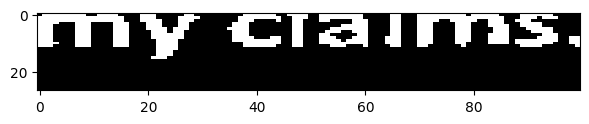

mygiaims
mygiaims
411
wordID 411


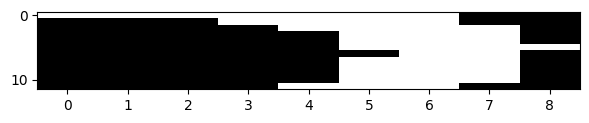

1
a
414
wordID 414


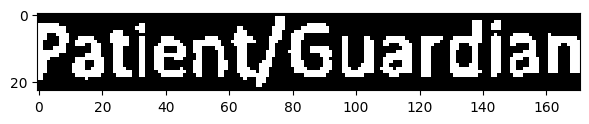

pat1envguardian
pat1envguardian
415
wordID 415


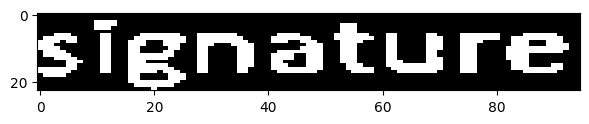

siinature
signature


In [ ]:
for i in spellingErrorsDict:
    image = None
    wordID = i
    indexVal = np.where(WordSegmentationsWithID[:,0] == wordID)[0][0]
    print(indexVal)
    WordSegment = BinarizedImage[WordSegmentationsWithID[indexVal][1]:WordSegmentationsWithID[indexVal][2],WordSegmentationsWithID[indexVal][3]:WordSegmentationsWithID[indexVal][4]]

    #Showing Word Segment:
    print("wordID", wordID)
    plotLengthX = 7

    plt.rcParams['figure.figsize'] = [plotLengthX, 1]
    plt.imshow(WordSegment, cmap='gray', vmin=0, vmax=1, aspect='auto', interpolation='none')
    plt.show()

    print(spellingErrorsDict[i])
    print(corrections[i])


Replace Spelling errors with Corrections

In [ ]:
# spellingErrorsDict = {foundWordsDict[word] for wordID in corrections.keys() if foundWordsDict[word] not in detectedDictionary}

for wordID in corrections.keys():
    foundWordsDict[wordID] = corrections[wordID]

print(foundWordsDict)

{0: 'name', 1: 'ot', 2: 'practice', 3: 'jzgisl', 4: 'ha', 5: 'l', 6: 'sun', 7: 'for', 8: 'cpt', 9: 'ipl', 10: 'roads', 11: 'date', 12: 'rd3t1', 13: 'papier', 14: 'info', 15: 'reason', 16: 'marital', 17: 'status', 18: 'choose', 19: 'an', 20: 'item', 21: 'patients', 22: 'last', 23: 'name', 24: 'just', 25: 'nam', 26: 'it', 27: 'first', 28: 'name', 29: 'dd1e1', 30: 'lanital', 31: 'choose', 32: 'an', 33: 'items', 34: 'binh', 35: 'cate', 36: 'f', 37: 'not', 38: 'what', 39: 'is', 40: 'your', 41: 'learn', 42: 'name', 43: 'fo', 44: 'mer', 45: 'name', 46: 'is', 47: 'this', 48: 'your', 49: 'learn', 50: 'name', 51: 'lbinhday1', 52: 'former', 53: 'name', 54: 'i', 55: 'a', 56: 'a', 57: 'legal', 58: 'name', 59: 'yes', 60: 'address', 61: 'laddre5sl', 62: 'po', 63: 'box', 64: 'cist', 65: 'zip', 66: 'code', 67: 'ceil', 68: 'phone', 69: 'no', 70: 'home', 71: 'phone', 72: 'no', 73: 'oral', 74: 'ecurie', 75: 'no', 76: 'l', 77: 'p', 78: 'h', 79: 'o', 80: 'n', 81: 'e', 82: 'j', 83: 'ix', 84: 'pho', 85: 'new'

In [ ]:
import sys
import os

# Used to import python files from a different directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Content Classification\\PDF_Text_Extraction")

from TF_IDF import TF_IDF

trainFolderPath = r"G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training"
languageDictionaryPath = r"G:\My Drive\EPR_420\Code\main\dictionaries\english_words_dictionary.json"

# y_label generated within constructor 
tf_idf = TF_IDF(trainFolderPath, languageDictionaryPath)
print(tf_idf.Get_y_labels_train())
tf_idf.CalculateVocabList()
tf_idf.CalculateTermFreqTable()
tf_idf.Calculate_TF_IDF_Train()


from KNN import KNN

tf_idf_train = tf_idf.Get_TF_IDF_Train()

testFolderPath = r"G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Testing"

tf_idf_test = tf_idf.Get_TF_IDF_Text(list(foundWordsDict.values()))

print(tf_idf_test)


knn = KNN(3, 8)
knn.load(tf_idf_train, tf_idf.Get_y_labels_train())
knn._predict(tf_idf_test)



[5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6
 6 6 6 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4]
0 G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training\5) Dietary Menu - Training\05.13.19-attachment 3 lp58145 dmh menu cards x7 (180113)-2.pdf
1 G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training\5) Dietary Menu - Training\6SatWeek1.pdf
2 G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training\5) Dietary Menu - Training\Adult-Hospital-Menu.pdf
3 G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training\5) Dietary Menu - Training\CHEF_Menu-2.pdf
4 G:\My Drive\EPR_420\Code\Content Classification\Testing Document Templates\A) Latin Language PDFs\A) English PDFs\Training\5) Dietary Menu - Trainin

array([5, 1, 3, 6, 3, 3, 4, 3])